In [1]:
from dataloader import DAVIS_Seq2, normalize_image, BallDataset, Balltest
from model import BaseFeatup
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json
from loss import order_loss, chamer_distance_loss
import random
from ModelInfer import ModelInfer

In [2]:
!nvidia-smi

Fri Apr  5 17:54:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:15:00.0 Off |                    0 |
| N/A   32C    P0             57W /  300W |    7641MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!export CUDA_VISIBLE_DEVICES=0

In [6]:
data_set = BallDataset("ellipse/uniform_samples_80.json", output_first=True)
test_set = Balltest("ellipse/uniform_samples_80.json")
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [7]:
first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx = next(iter(data_loader))
pre_idx, curr_idx

(tensor([1]), tensor([0]))

Text(0.5, 1.0, 'First Frame in test set')

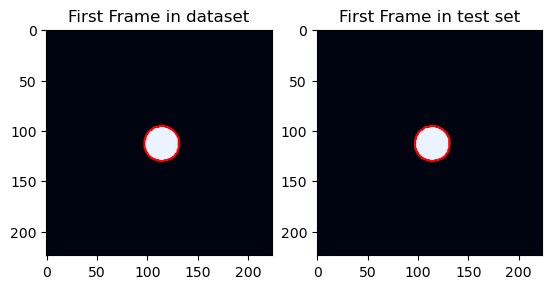

In [8]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize_image(first_frame[index].permute(1, 2, 0)))
plt.plot(first_boundary[index][:, 0], first_boundary[index][:, 1], 'r')
plt.title("First Frame in dataset")
plt.subplot(1, 2, 2)
plt.imshow(normalize_image(test_set[0][0].permute(1, 2, 0)))
plt.plot(first_boundary[index][:, 0], first_boundary[index][:, 1], 'r')
plt.title("First Frame in test set")

Text(0.5, 1.0, 'Curr Frame')

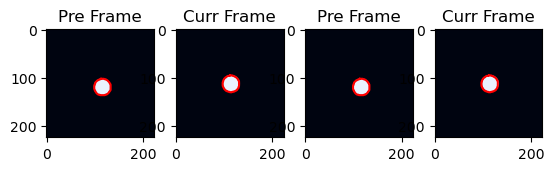

In [9]:
index = 0
plt.subplot(1, 4, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')
plt.subplot(1, 4, 3)
plt.imshow(normalize_image(test_set[pre_idx][0].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 4)
plt.imshow(normalize_image(test_set[curr_idx][0].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')

In [10]:
model = BaseFeatup()

/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [12]:
model = model.cuda()
results = model(
    first_frame.cuda(),
    first_boundary.cuda(),
    pre_frame.cuda(),
    curr_frame.cuda(),
    pre_boundary.cuda(),
)

In [13]:
order_loss(results[-1], curr_boundary.cuda())

tensor(10.3148, device='cuda:0', grad_fn=<DivBackward0>)

In [14]:
test_set = Balltest("ellipse/uniform_samples_80.json")

In [15]:
model_infer = ModelInfer(test_set)

In [16]:
model_infer.infer_model(model)

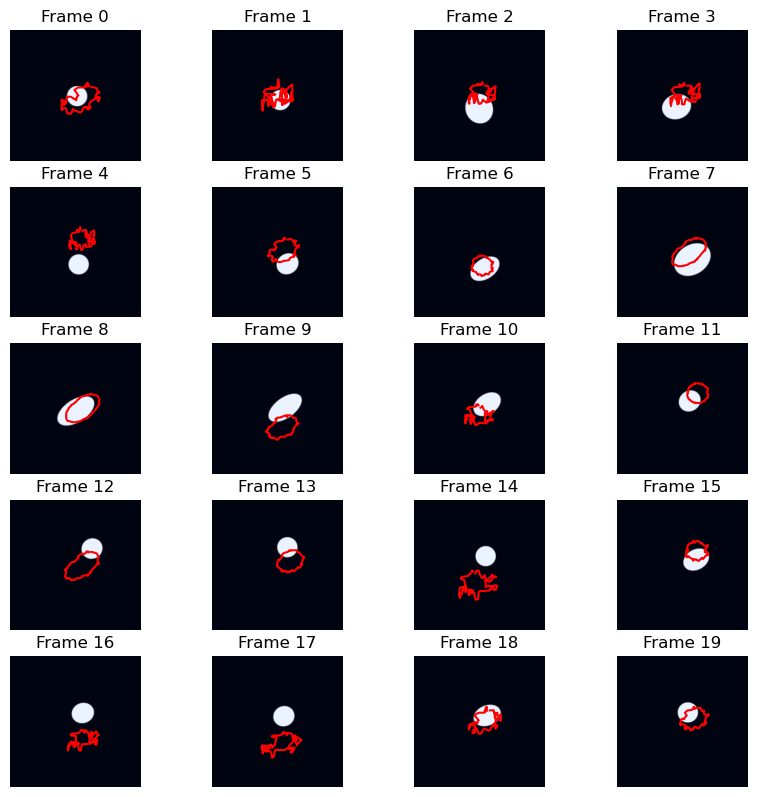

In [17]:
plt.figure(figsize=(10, 20))
for i in range(len(test_set)):
    plt.subplot(10, 4, i + 1)
    img, sgm, boundary = test_set[i]
    plt.imshow(normalize_image(img.permute(1, 2, 0)))
    boundary = model_infer.get_boundary(i)
    plt.plot(boundary.cpu()[:, 0], boundary.cpu()[:, 1], "r")
    plt.axis("off")
    plt.title(f"Frame {i}")

In [18]:
model = BaseFeatup().to("cuda")
model_infer = ModelInfer(test_set)
data_set = BallDataset("ellipse/uniform_samples_80.json", output_first=True)
loss_func = order_loss
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [19]:
dict_loss = {}
dict_iou = {}
interval_epochs = 50
interval_num = 155
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
gradient_clip = 2
test_set = Balltest("ellipse/uniform_samples_80.json")
model_infer = ModelInfer(test_set)
epoch_index = 0

In [23]:
interval_num = 250

Epoch 1001, Loss: 17.37
Epoch 1002, Loss: 13.29
Epoch 1003, Loss: 11.96
Epoch 1004, Loss: 11.13
Epoch 1005, Loss: 11.15


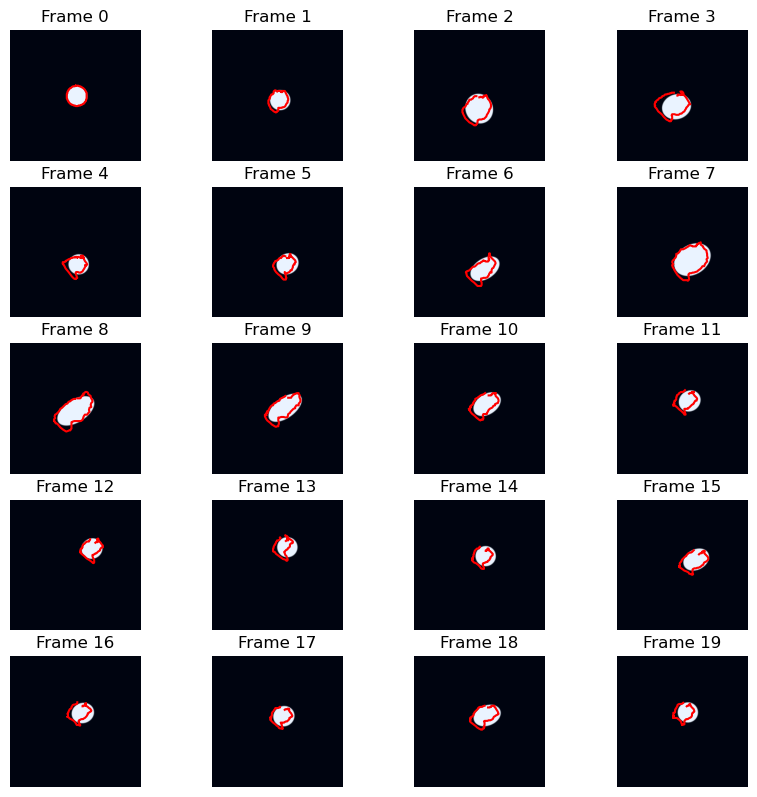

Epoch 1005, IOU: 0.665291
Epoch 1006, Loss: 15.74
Epoch 1007, Loss: 11.74
Epoch 1008, Loss: 12.37
Epoch 1009, Loss: 11.32
Epoch 1010, Loss: 11.43


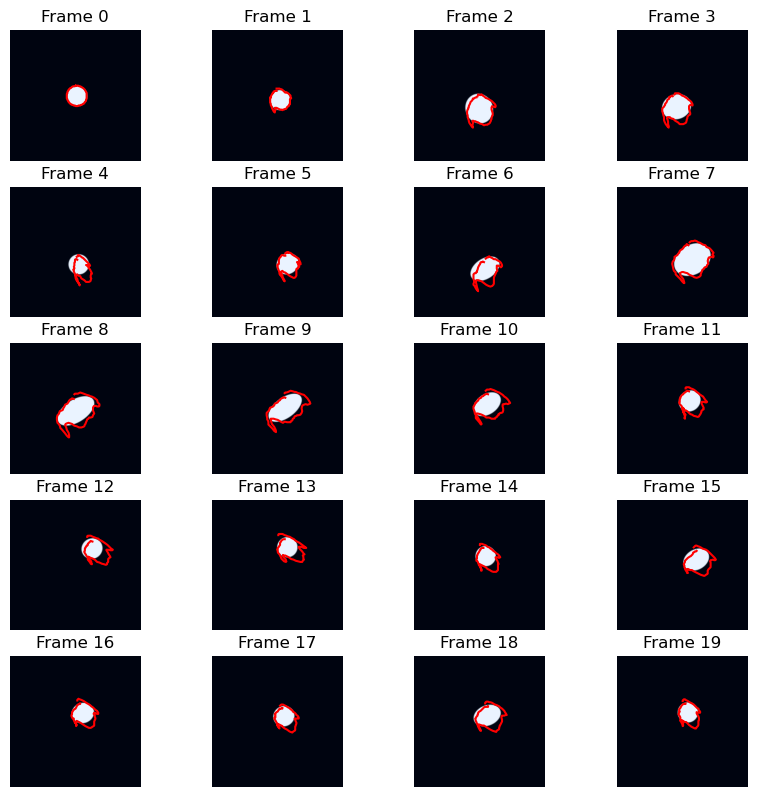

Epoch 1010, IOU: 0.685480
Epoch 1011, Loss: 20.02
Epoch 1012, Loss: 13.88
Epoch 1013, Loss: 13.76
Epoch 1014, Loss: 13.92
Epoch 1015, Loss: 13.20


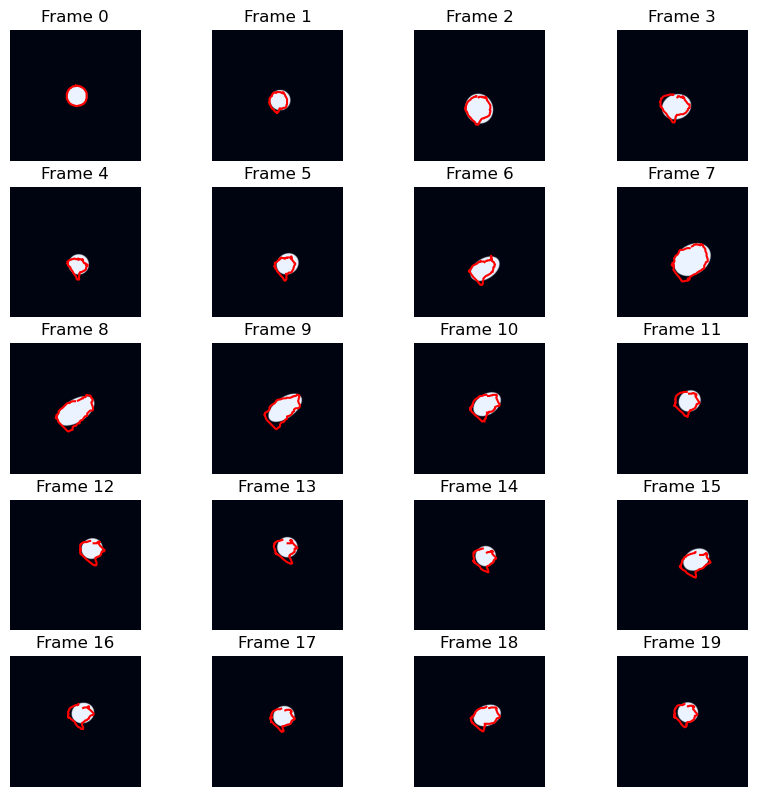

Epoch 1015, IOU: 0.715525
Epoch 1016, Loss: 14.80
Epoch 1017, Loss: 11.80
Epoch 1018, Loss: 11.49
Epoch 1019, Loss: 11.16
Epoch 1020, Loss: 11.65


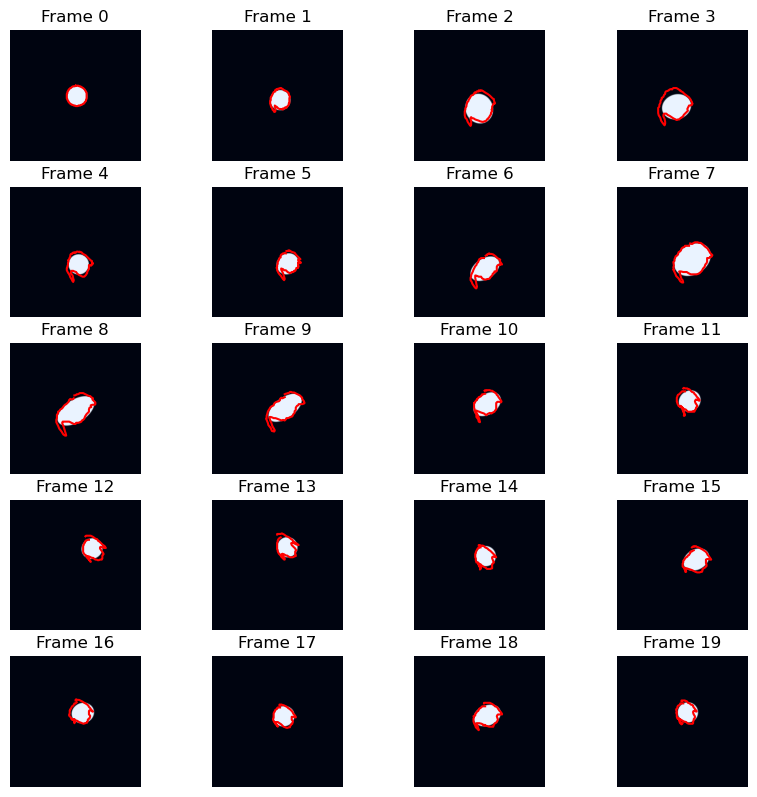

Epoch 1020, IOU: 0.774973
Epoch 1021, Loss: 15.07
Epoch 1022, Loss: 12.46
Epoch 1023, Loss: 13.68
Epoch 1024, Loss: 11.01
Epoch 1025, Loss: 11.03


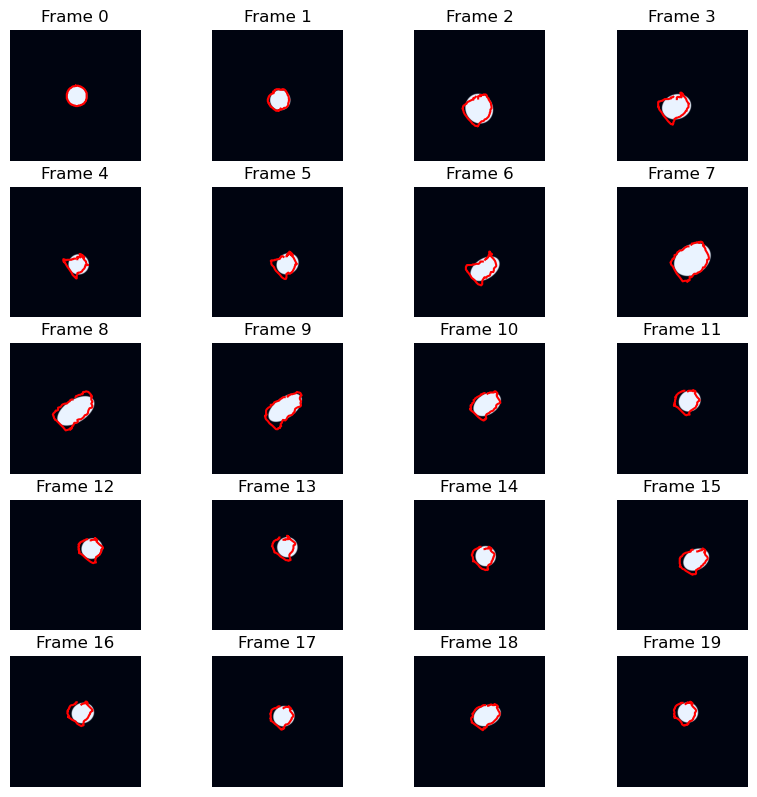

Epoch 1025, IOU: 0.746632
Epoch 1026, Loss: 15.44
Epoch 1027, Loss: 11.39
Epoch 1028, Loss: 10.40
Epoch 1029, Loss: 10.30
Epoch 1030, Loss: 11.92


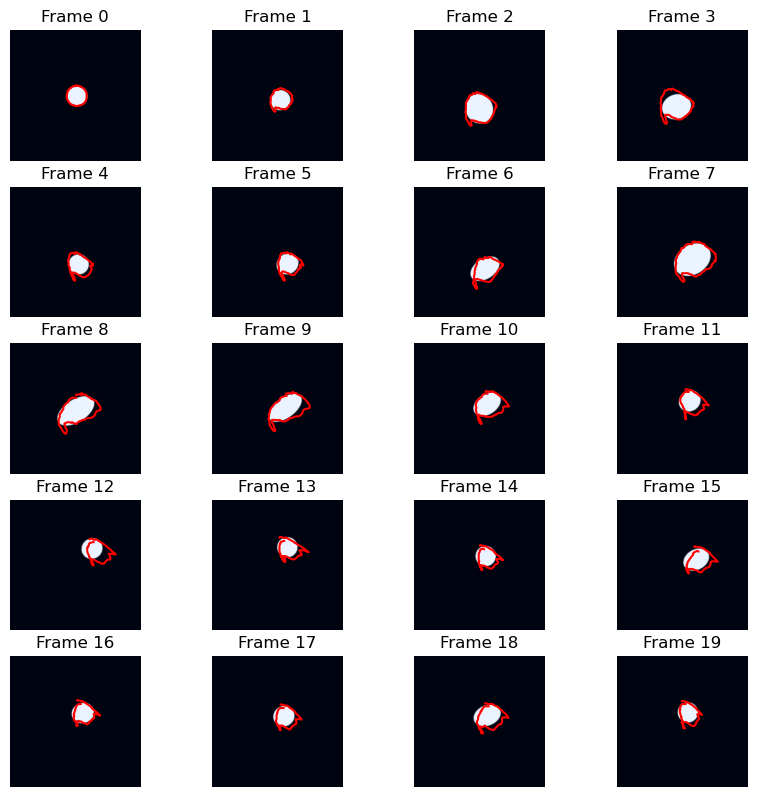

Epoch 1030, IOU: 0.711917
Epoch 1031, Loss: 18.63
Epoch 1032, Loss: 14.34
Epoch 1033, Loss: 13.77
Epoch 1034, Loss: 12.44
Epoch 1035, Loss: 12.07


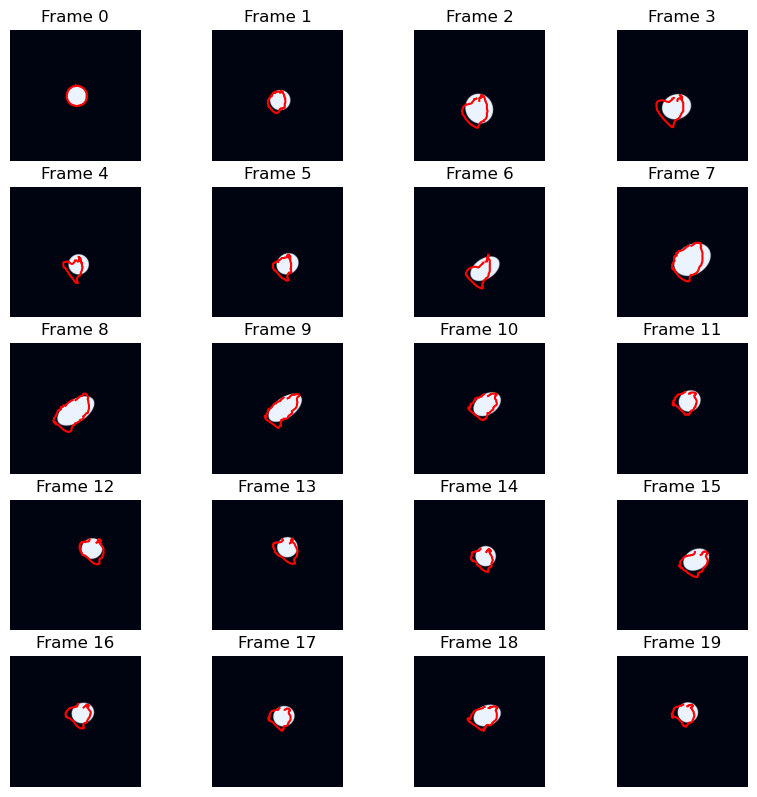

Epoch 1035, IOU: 0.638836
Epoch 1036, Loss: 16.64
Epoch 1037, Loss: 11.57
Epoch 1038, Loss: 14.57
Epoch 1039, Loss: 12.27
Epoch 1040, Loss: 12.07


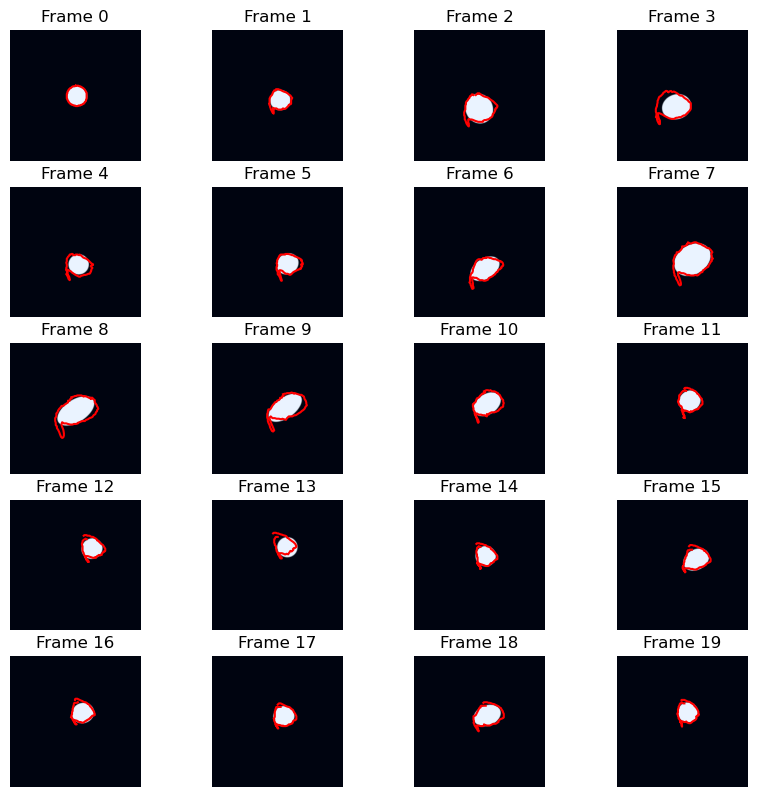

Epoch 1040, IOU: 0.779842
Epoch 1041, Loss: 15.64
Epoch 1042, Loss: 14.33
Epoch 1043, Loss: 13.72
Epoch 1044, Loss: 11.46
Epoch 1045, Loss: 11.37


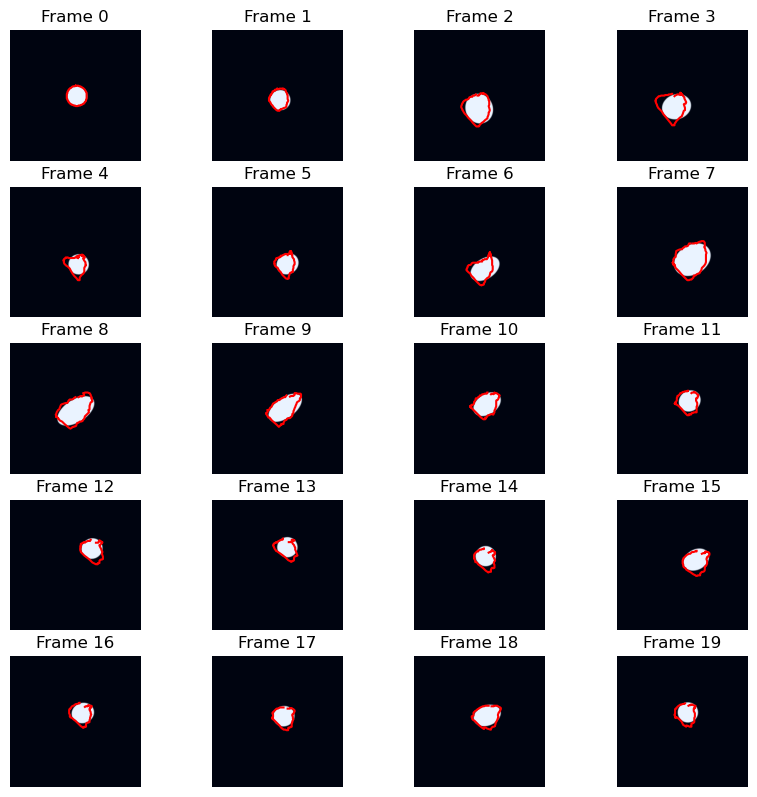

Epoch 1045, IOU: 0.757902
Epoch 1046, Loss: 18.02
Epoch 1047, Loss: 12.78
Epoch 1048, Loss: 11.45
Epoch 1049, Loss: 11.71
Epoch 1050, Loss: 12.42


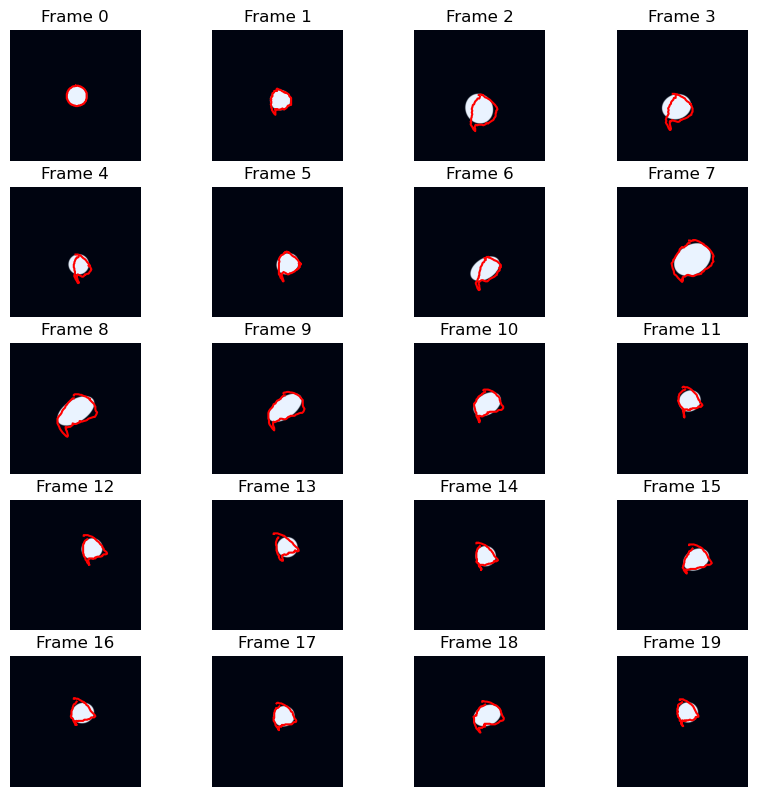

Epoch 1050, IOU: 0.734867
Epoch 1051, Loss: 19.71
Epoch 1052, Loss: 13.68
Epoch 1053, Loss: 12.55
Epoch 1054, Loss: 12.52
Epoch 1055, Loss: 11.67


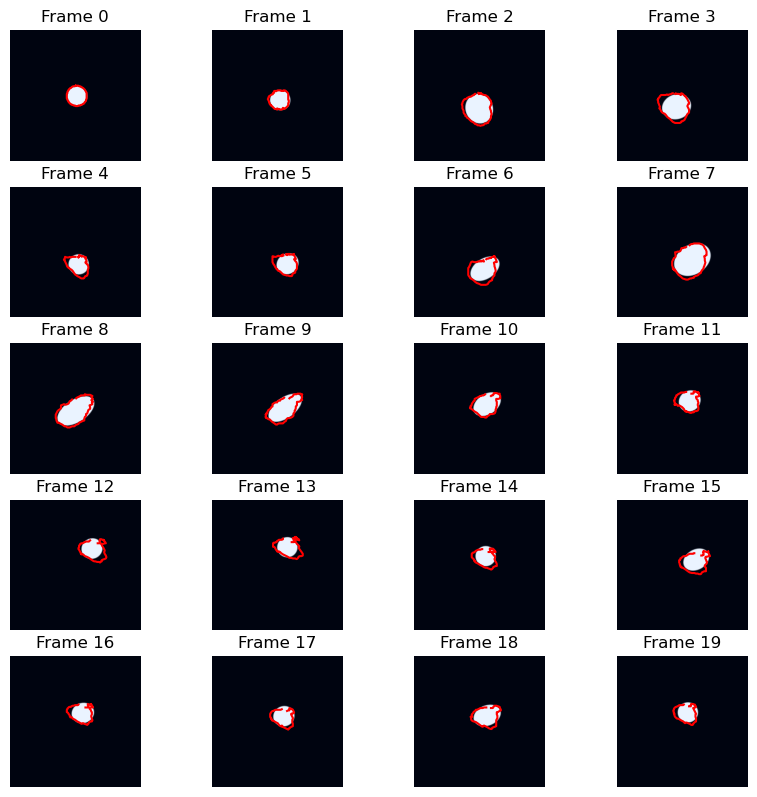

Epoch 1055, IOU: 0.758822
Epoch 1056, Loss: 17.22
Epoch 1057, Loss: 12.81
Epoch 1058, Loss: 11.05
Epoch 1059, Loss: 11.49
Epoch 1060, Loss: 11.60


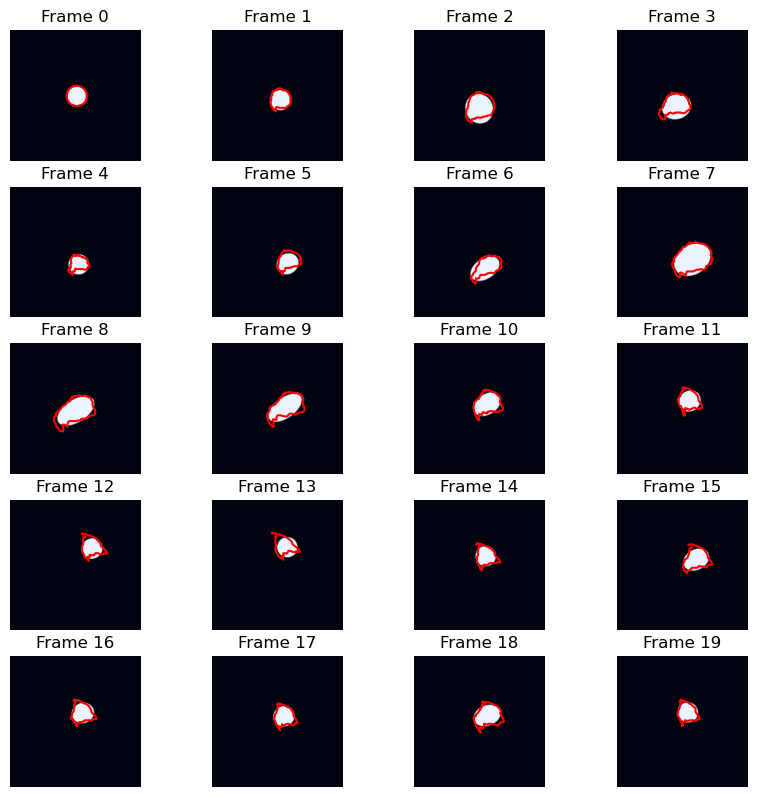

Epoch 1060, IOU: 0.742056
Epoch 1061, Loss: 17.83
Epoch 1062, Loss: 12.95
Epoch 1063, Loss: 11.56
Epoch 1064, Loss: 11.86
Epoch 1065, Loss: 11.48


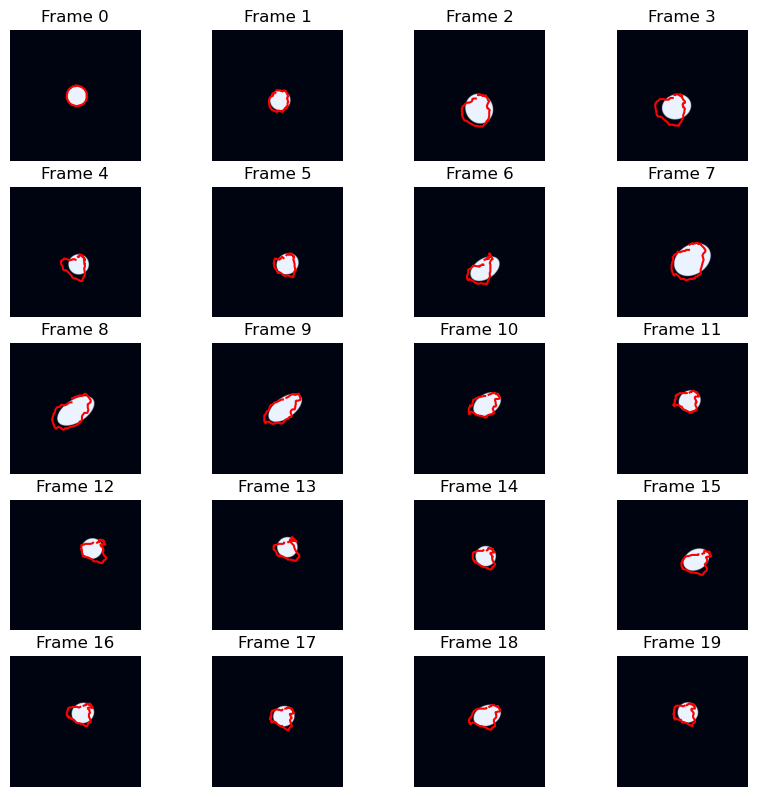

Epoch 1065, IOU: 0.688827
Epoch 1066, Loss: 14.83
Epoch 1067, Loss: 12.37
Epoch 1068, Loss: 14.46
Epoch 1069, Loss: 13.07
Epoch 1070, Loss: 13.10


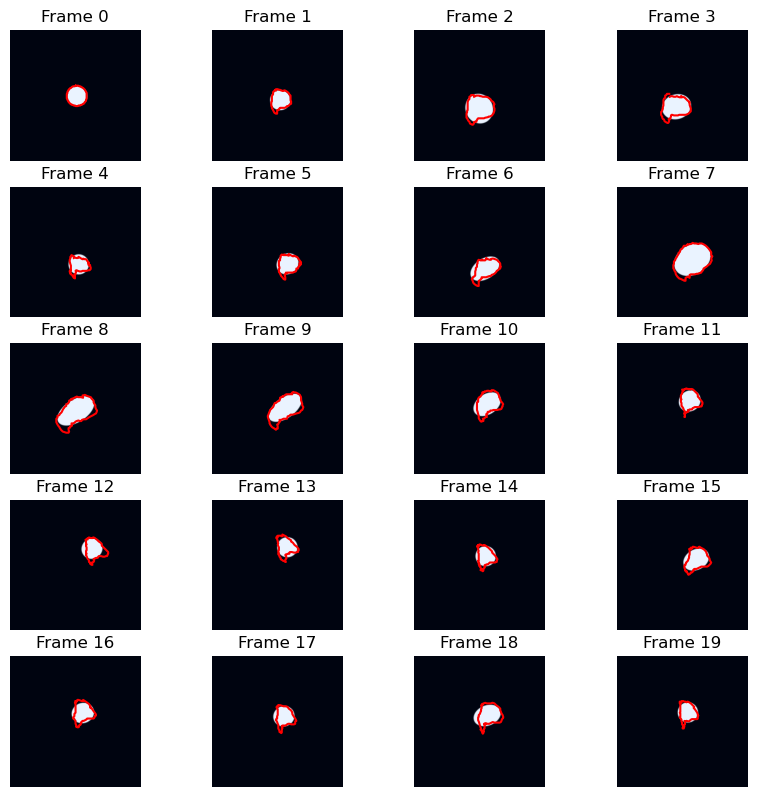

Epoch 1070, IOU: 0.746365
Epoch 1071, Loss: 16.85
Epoch 1072, Loss: 12.97
Epoch 1073, Loss: 10.56
Epoch 1074, Loss: 10.96
Epoch 1075, Loss: 11.31


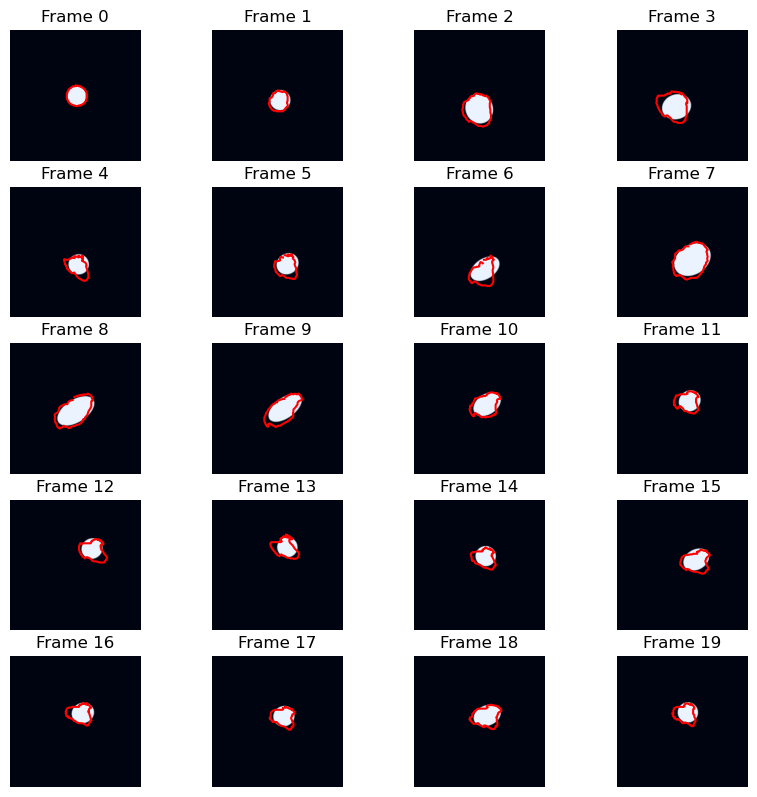

Epoch 1075, IOU: 0.721356
Epoch 1076, Loss: 15.95
Epoch 1077, Loss: 12.66
Epoch 1078, Loss: 10.71
Epoch 1079, Loss: 10.25
Epoch 1080, Loss: 11.08


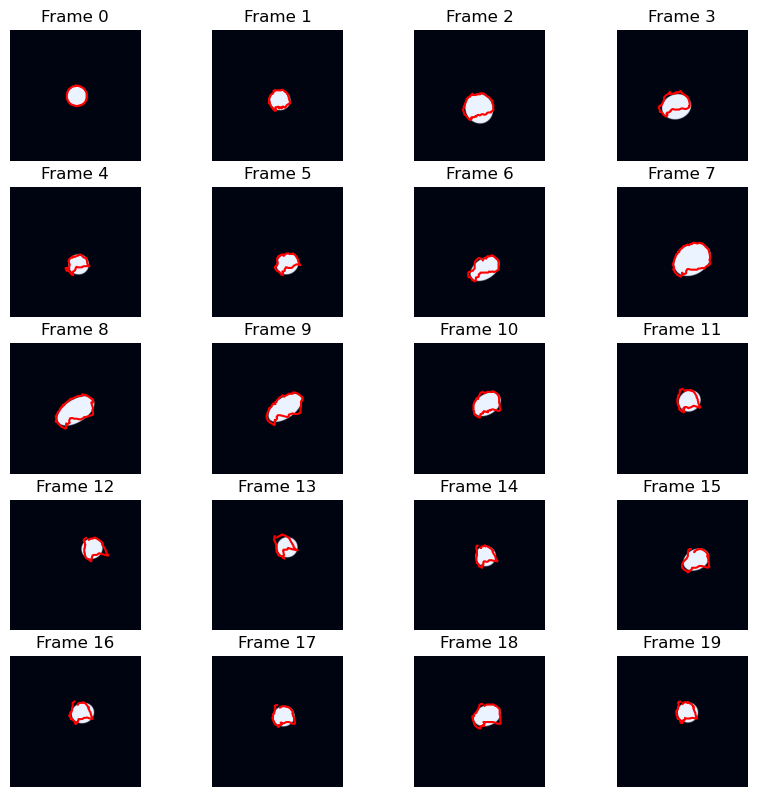

Epoch 1080, IOU: 0.739731
Epoch 1081, Loss: 14.77
Epoch 1082, Loss: 12.46
Epoch 1083, Loss: 11.39
Epoch 1084, Loss: 11.36
Epoch 1085, Loss: 10.55


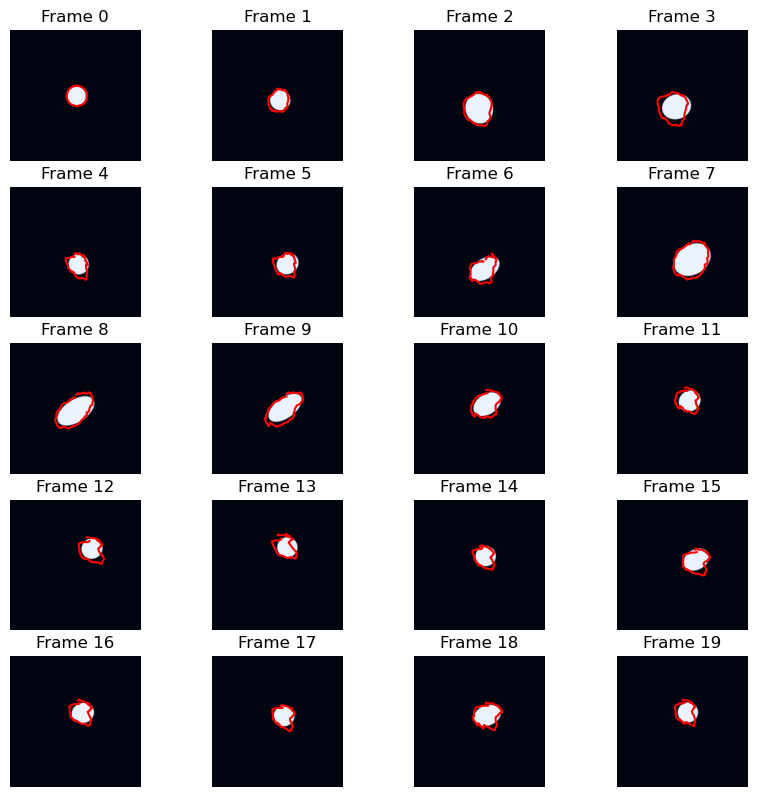

Epoch 1085, IOU: 0.751609
Epoch 1086, Loss: 13.90
Epoch 1087, Loss: 12.01
Epoch 1088, Loss: 11.61
Epoch 1089, Loss: 11.27
Epoch 1090, Loss: 13.93


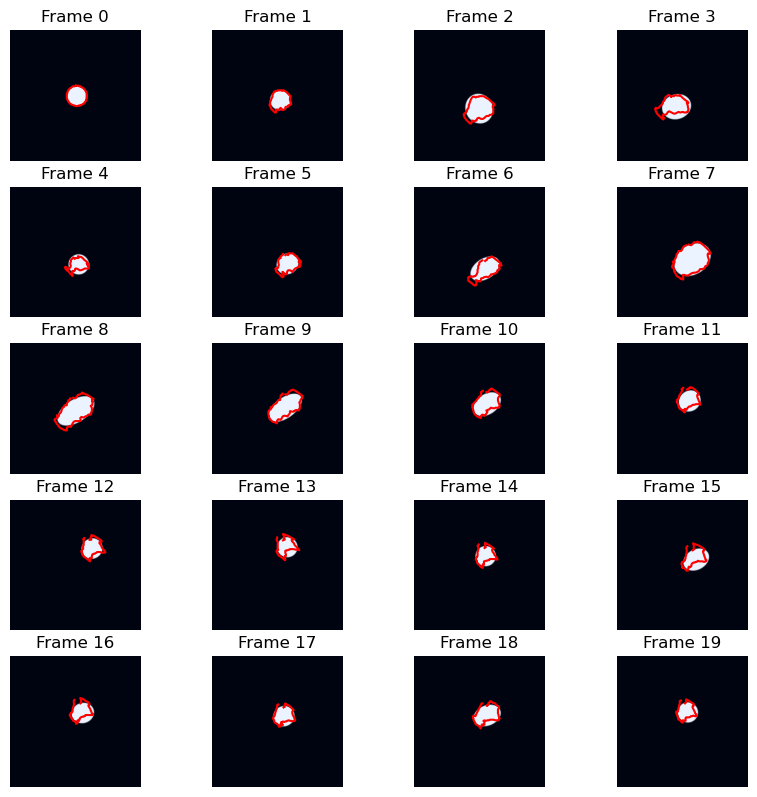

Epoch 1090, IOU: 0.723715
Epoch 1091, Loss: 13.56
Epoch 1092, Loss: 11.69
Epoch 1093, Loss: 10.59
Epoch 1094, Loss: 10.98
Epoch 1095, Loss: 13.28


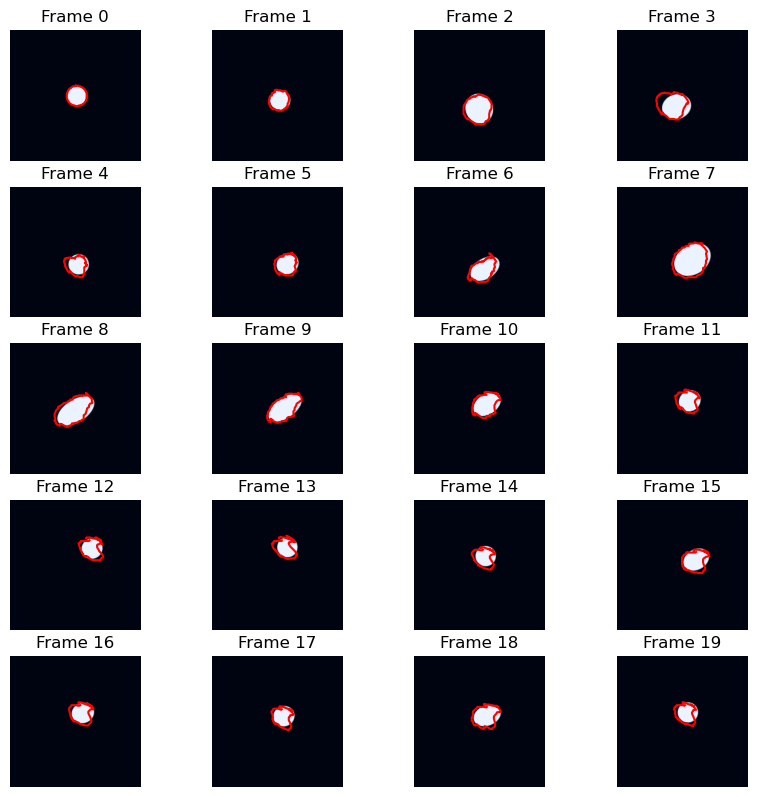

Epoch 1095, IOU: 0.765128
Epoch 1096, Loss: 12.97
Epoch 1097, Loss: 12.55
Epoch 1098, Loss: 13.53
Epoch 1099, Loss: 11.73
Epoch 1100, Loss: 10.30


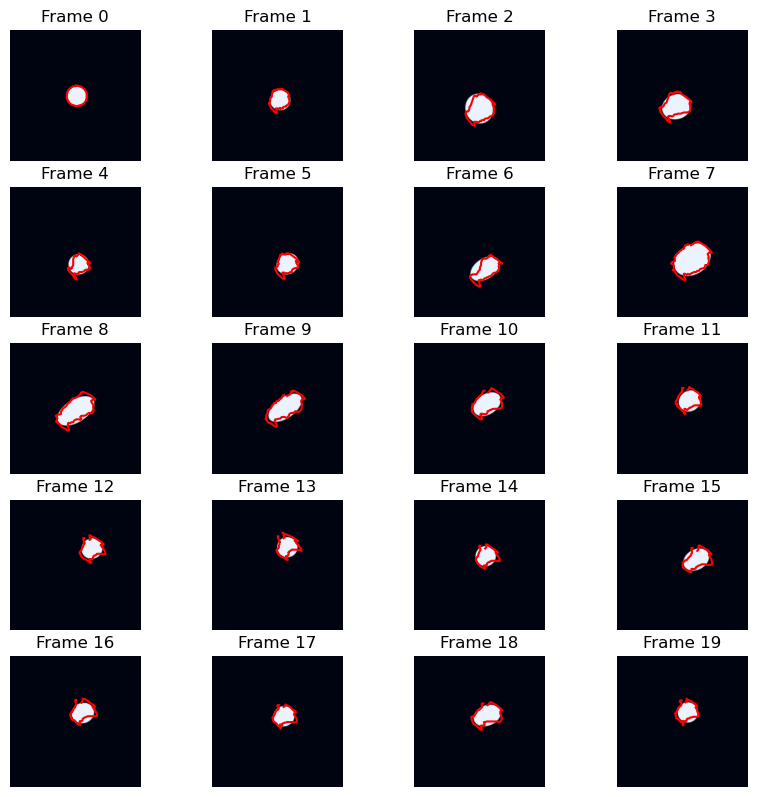

Epoch 1100, IOU: 0.753267
Epoch 1101, Loss: 15.03
Epoch 1102, Loss: 11.80
Epoch 1103, Loss: 11.38
Epoch 1104, Loss: 10.62
Epoch 1105, Loss: 11.59


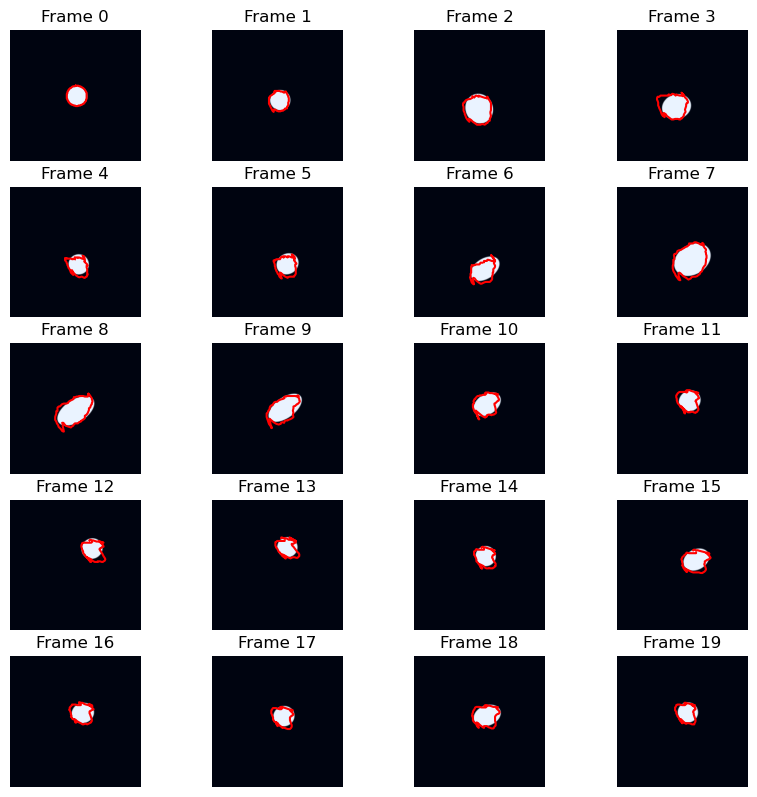

Epoch 1105, IOU: 0.767085
Epoch 1106, Loss: 14.80
Epoch 1107, Loss: 12.45
Epoch 1108, Loss: 11.47
Epoch 1109, Loss: 10.12
Epoch 1110, Loss: 11.31


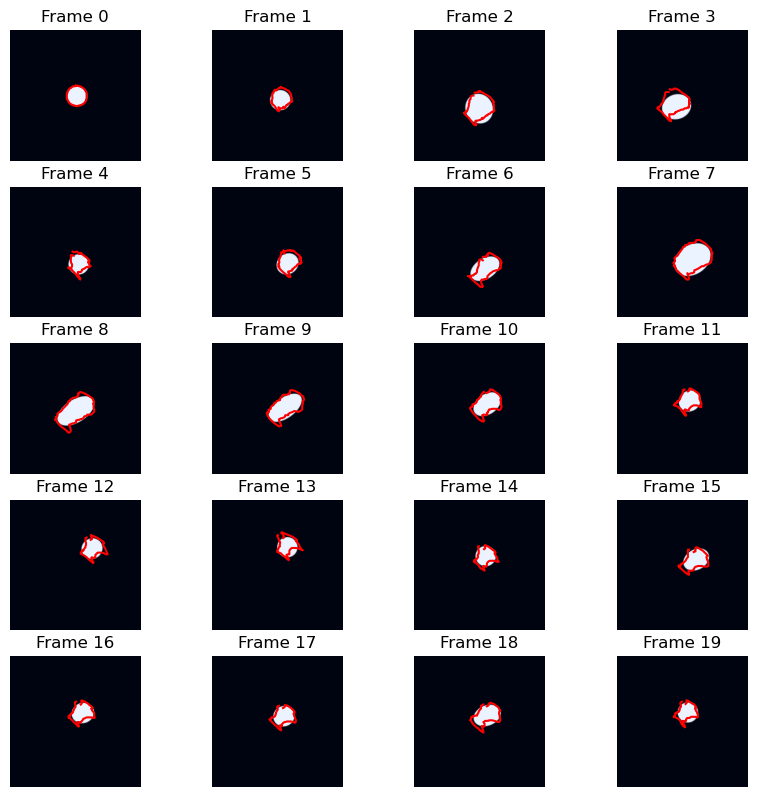

Epoch 1110, IOU: 0.730546
Epoch 1111, Loss: 15.43
Epoch 1112, Loss: 14.68
Epoch 1113, Loss: 12.16
Epoch 1114, Loss: 11.56
Epoch 1115, Loss: 12.18


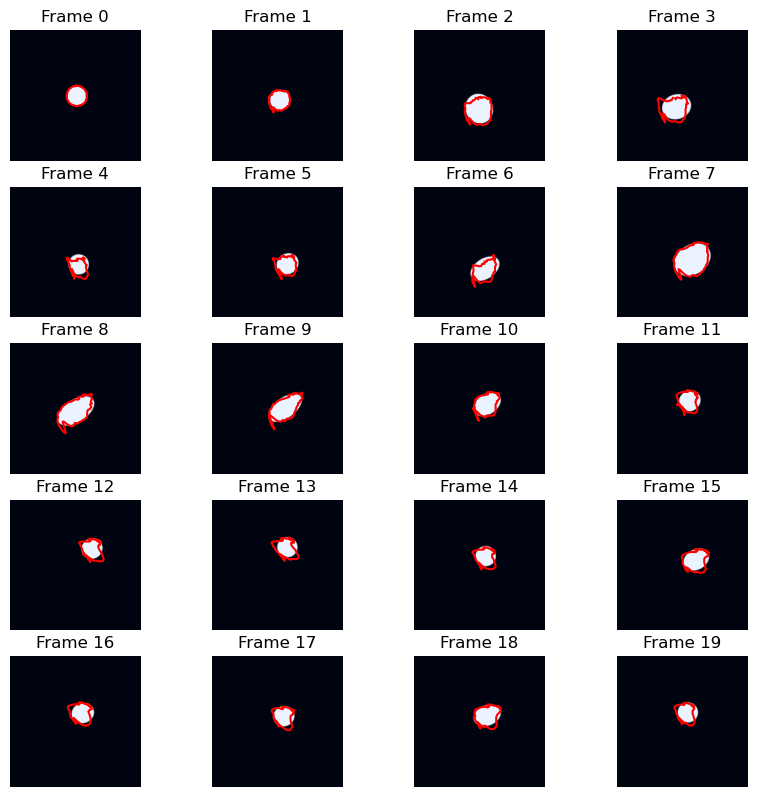

Epoch 1115, IOU: 0.761361
Epoch 1116, Loss: 15.17
Epoch 1117, Loss: 13.25
Epoch 1118, Loss: 11.79
Epoch 1119, Loss: 11.36
Epoch 1120, Loss: 11.12


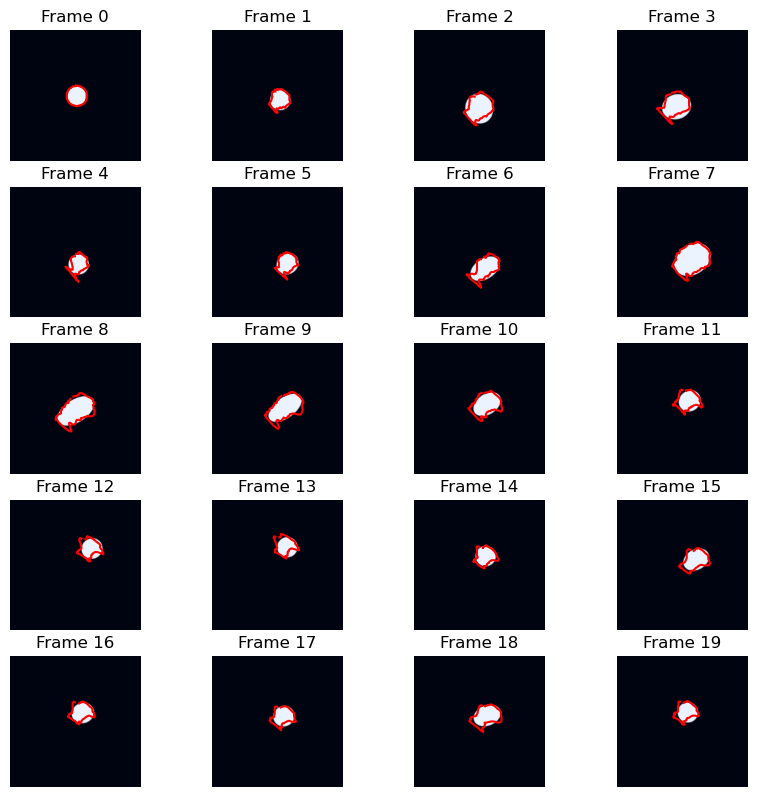

Epoch 1120, IOU: 0.755937
Epoch 1121, Loss: 15.09
Epoch 1122, Loss: 11.76
Epoch 1123, Loss: 11.44
Epoch 1124, Loss: 9.96
Epoch 1125, Loss: 11.41


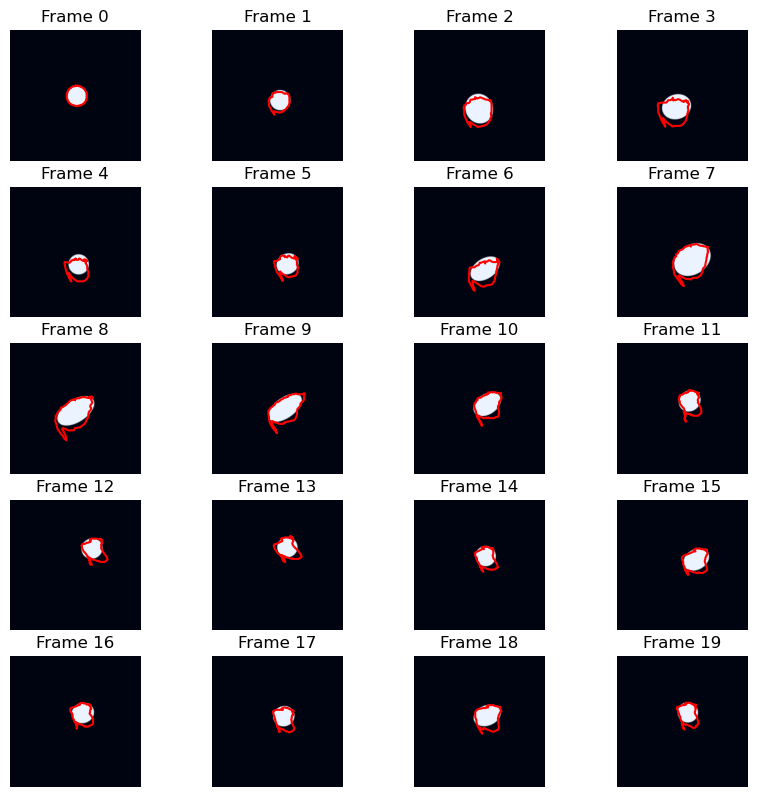

Epoch 1125, IOU: 0.716724
Epoch 1126, Loss: 17.52
Epoch 1127, Loss: 13.50
Epoch 1128, Loss: 13.96
Epoch 1129, Loss: 14.12
Epoch 1130, Loss: 12.77


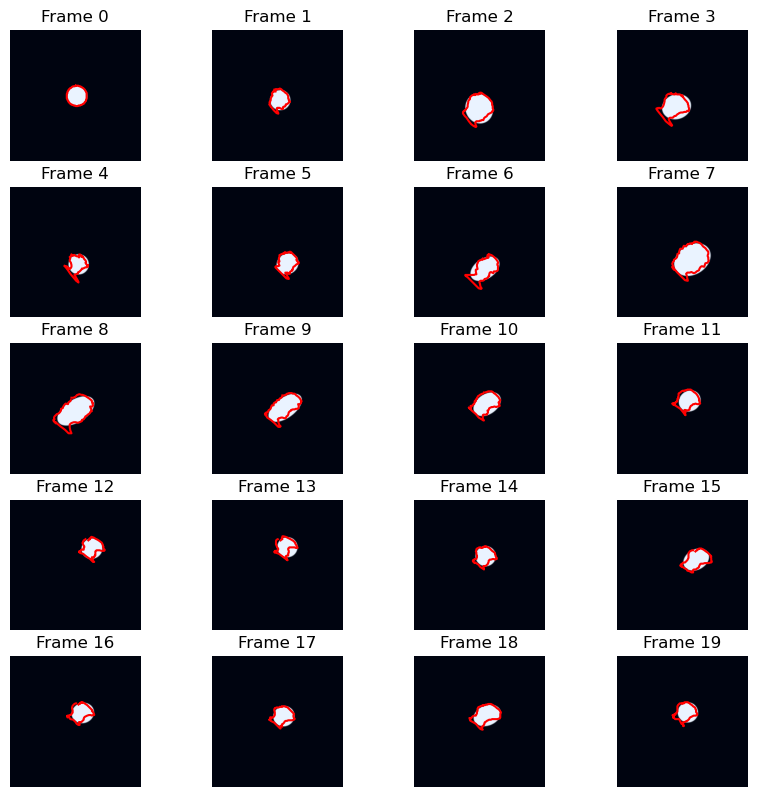

Epoch 1130, IOU: 0.755619
Epoch 1131, Loss: 14.40
Epoch 1132, Loss: 12.08
Epoch 1133, Loss: 11.15
Epoch 1134, Loss: 12.11
Epoch 1135, Loss: 12.43


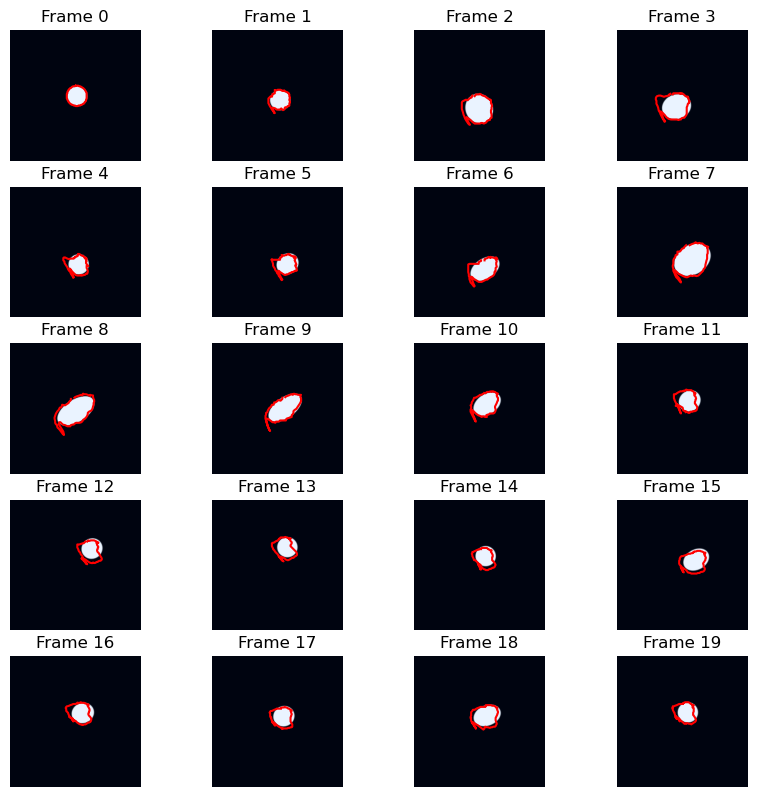

Epoch 1135, IOU: 0.755994
Epoch 1136, Loss: 15.03
Epoch 1137, Loss: 11.52
Epoch 1138, Loss: 10.78
Epoch 1139, Loss: 12.94
Epoch 1140, Loss: 11.39


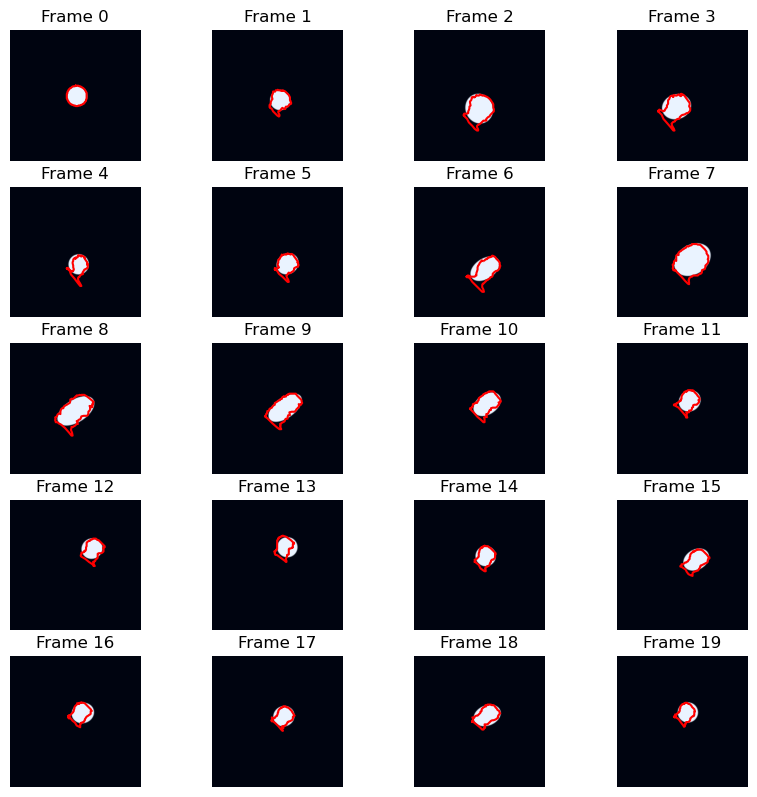

Epoch 1140, IOU: 0.749432
Epoch 1141, Loss: 15.97
Epoch 1142, Loss: 12.47
Epoch 1143, Loss: 11.10
Epoch 1144, Loss: 11.65
Epoch 1145, Loss: 12.96


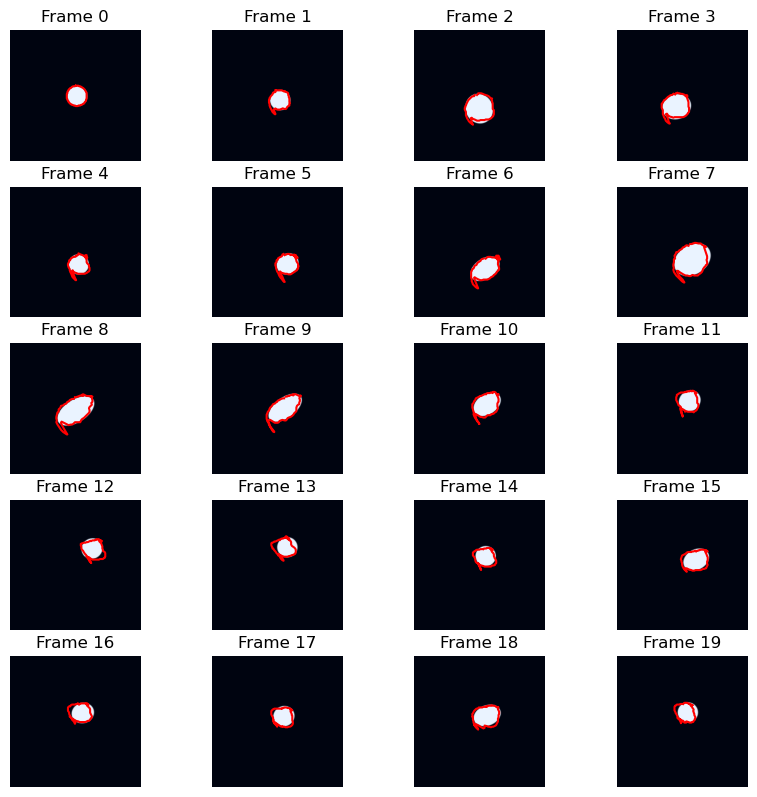

Epoch 1145, IOU: 0.813223
Epoch 1146, Loss: 15.04
Epoch 1147, Loss: 13.47
Epoch 1148, Loss: 11.13
Epoch 1149, Loss: 11.08
Epoch 1150, Loss: 11.64


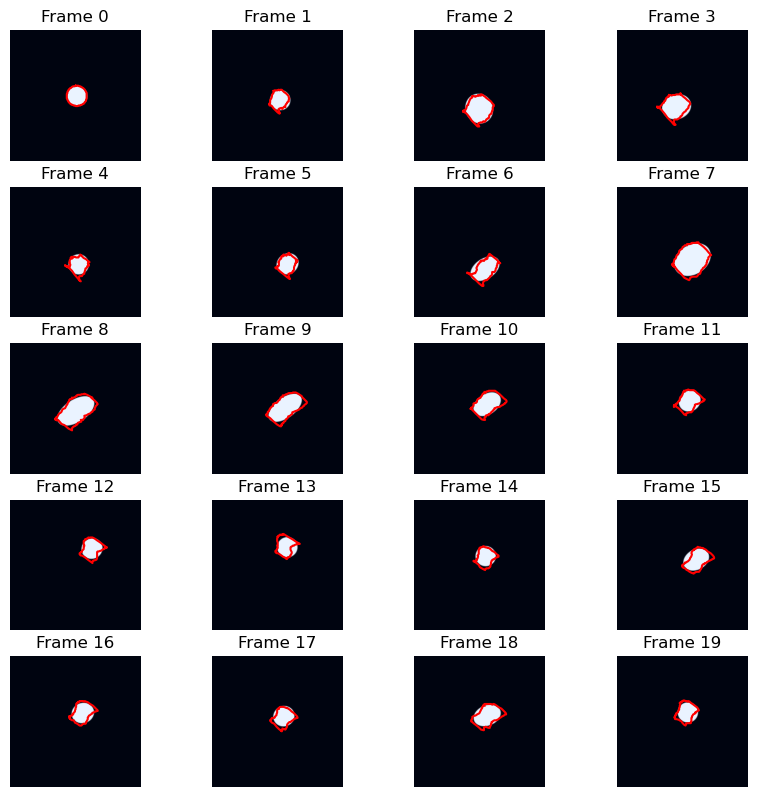

Epoch 1150, IOU: 0.784413
Epoch 1151, Loss: 15.86
Epoch 1152, Loss: 12.99
Epoch 1153, Loss: 11.38
Epoch 1154, Loss: 11.83
Epoch 1155, Loss: 10.86


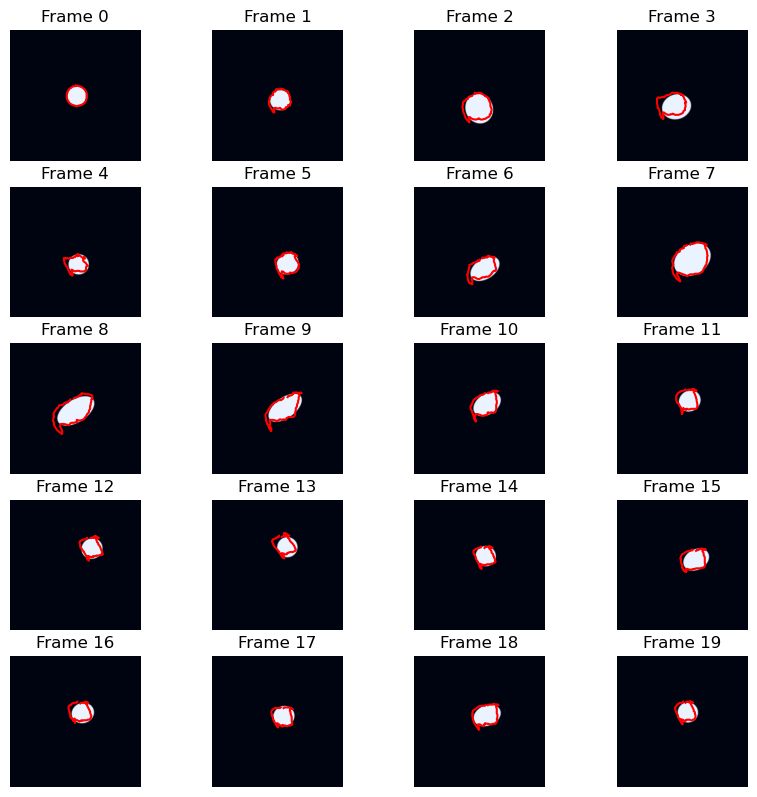

Epoch 1155, IOU: 0.741129
Epoch 1156, Loss: 14.23
Epoch 1157, Loss: 12.56
Epoch 1158, Loss: 12.19
Epoch 1159, Loss: 10.87
Epoch 1160, Loss: 11.70


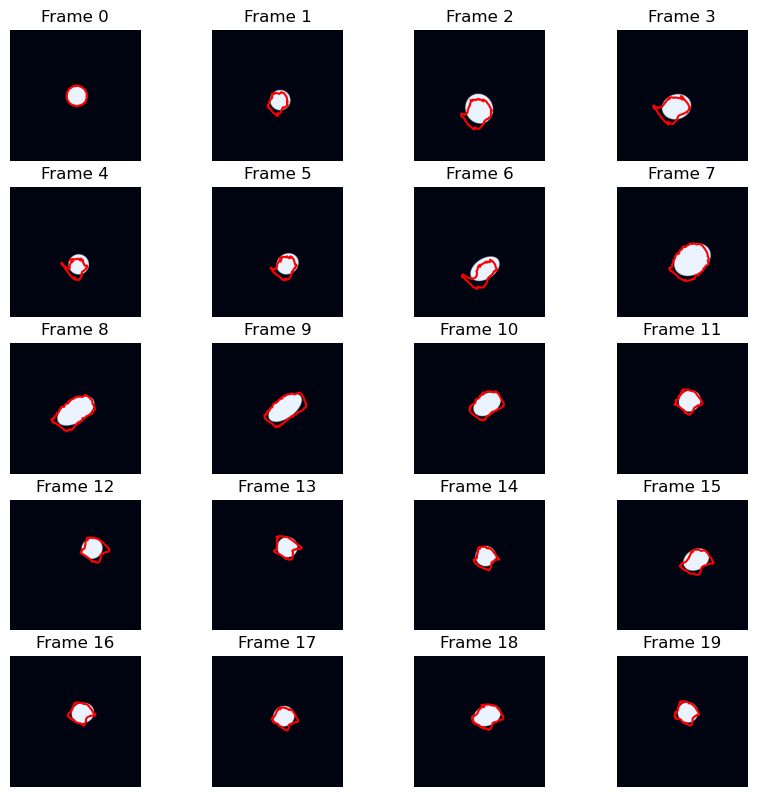

Epoch 1160, IOU: 0.724277
Epoch 1161, Loss: 16.66
Epoch 1162, Loss: 14.65
Epoch 1163, Loss: 14.25
Epoch 1164, Loss: 11.92
Epoch 1165, Loss: 12.08


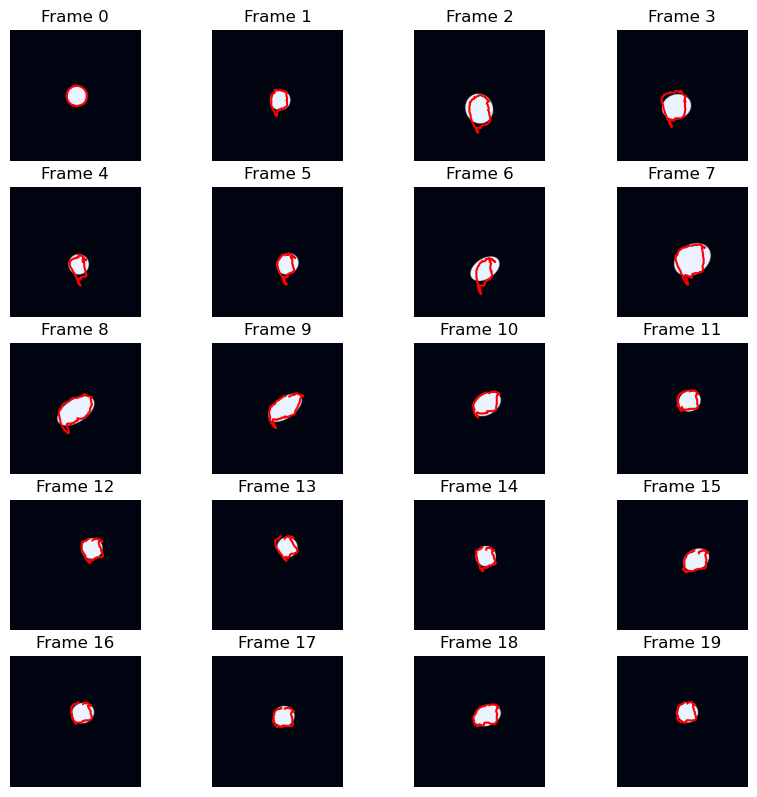

Epoch 1165, IOU: 0.764887
Epoch 1166, Loss: 15.98
Epoch 1167, Loss: 11.62
Epoch 1168, Loss: 12.27
Epoch 1169, Loss: 11.60
Epoch 1170, Loss: 12.17


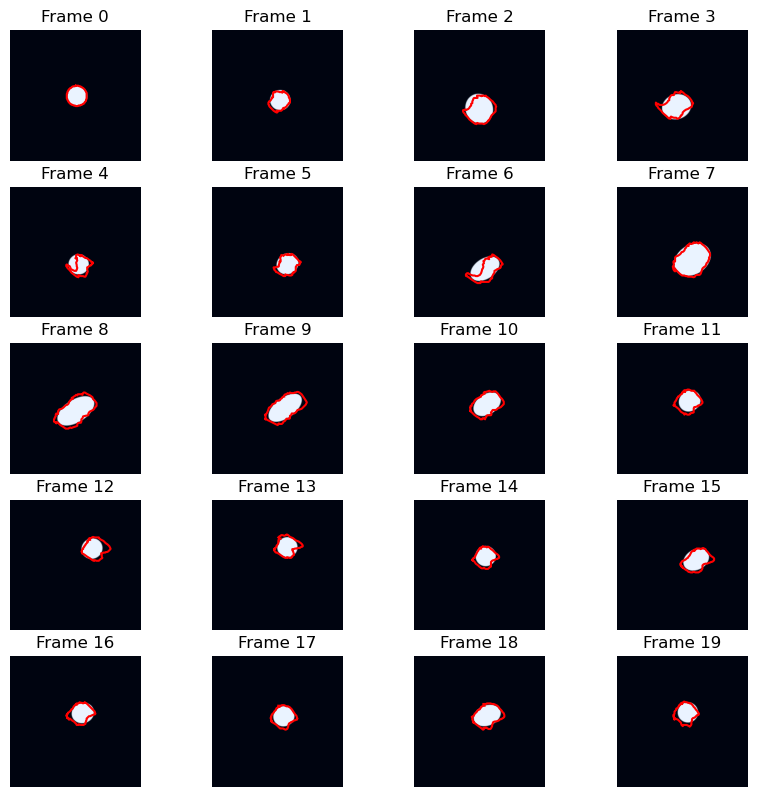

Epoch 1170, IOU: 0.767163
Epoch 1171, Loss: 12.93
Epoch 1172, Loss: 12.23
Epoch 1173, Loss: 9.90
Epoch 1174, Loss: 9.30
Epoch 1175, Loss: 9.68


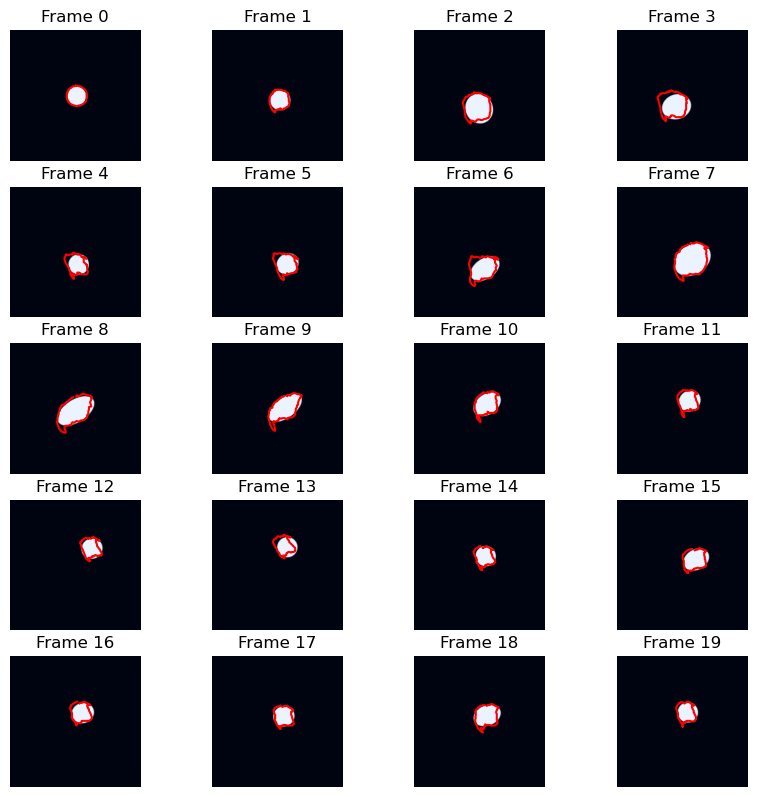

Epoch 1175, IOU: 0.767956
Epoch 1176, Loss: 14.31
Epoch 1177, Loss: 10.44
Epoch 1178, Loss: 11.67
Epoch 1179, Loss: 10.50
Epoch 1180, Loss: 10.58


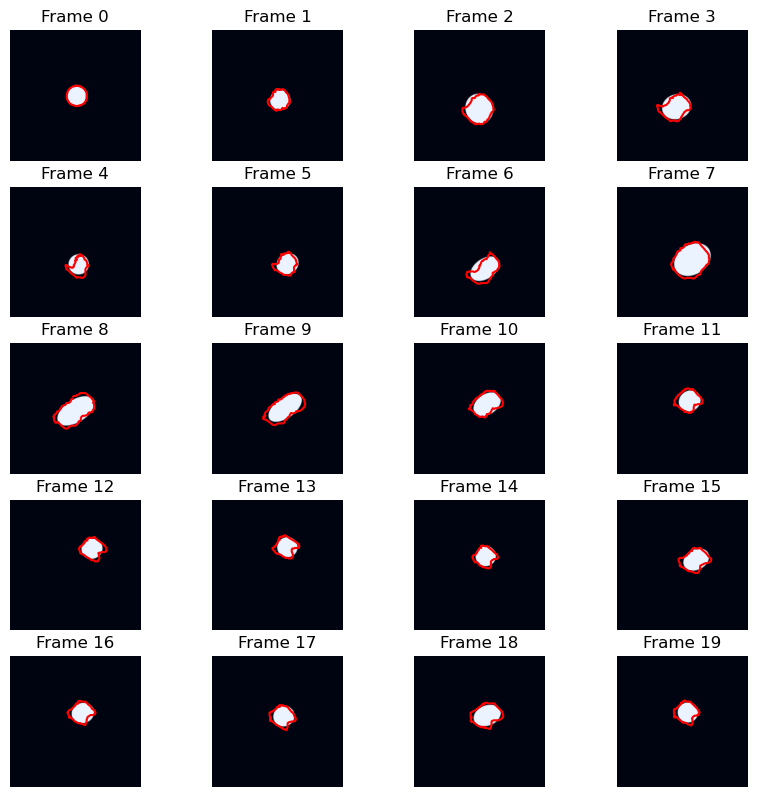

Epoch 1180, IOU: 0.787056
Epoch 1181, Loss: 12.70
Epoch 1182, Loss: 11.55
Epoch 1183, Loss: 11.96
Epoch 1184, Loss: 9.82
Epoch 1185, Loss: 10.01


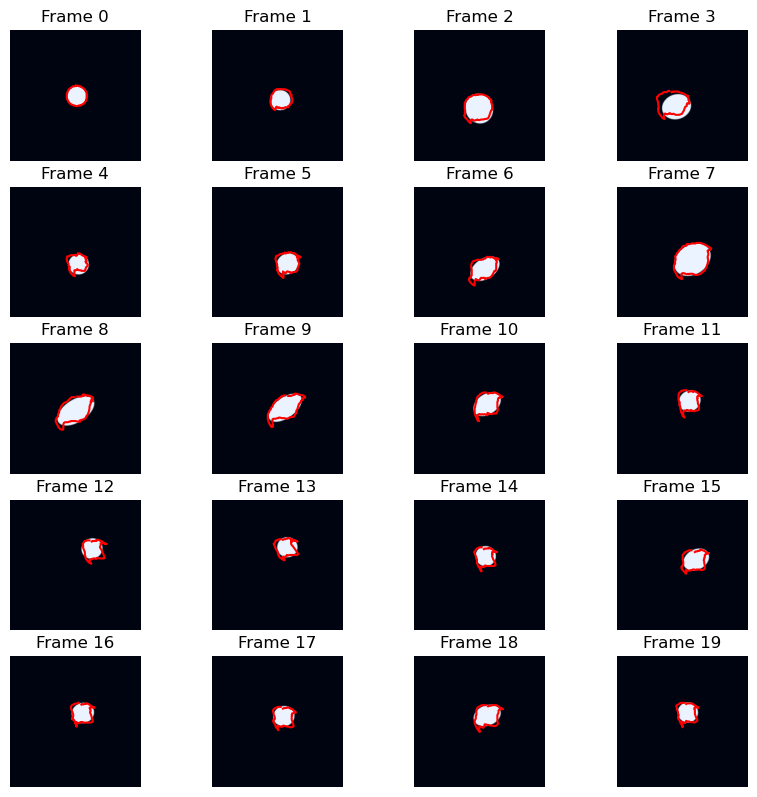

Epoch 1185, IOU: 0.779461
Epoch 1186, Loss: 14.88
Epoch 1187, Loss: 10.83
Epoch 1188, Loss: 12.25
Epoch 1189, Loss: 11.48
Epoch 1190, Loss: 10.71


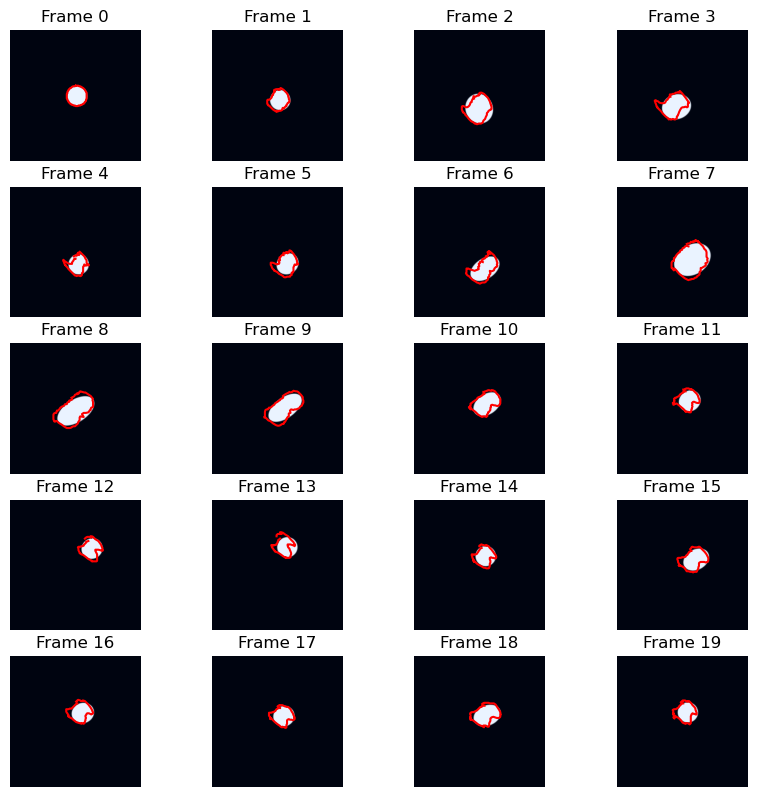

Epoch 1190, IOU: 0.743904
Epoch 1191, Loss: 14.67
Epoch 1192, Loss: 12.93
Epoch 1193, Loss: 10.60
Epoch 1194, Loss: 11.51
Epoch 1195, Loss: 10.48


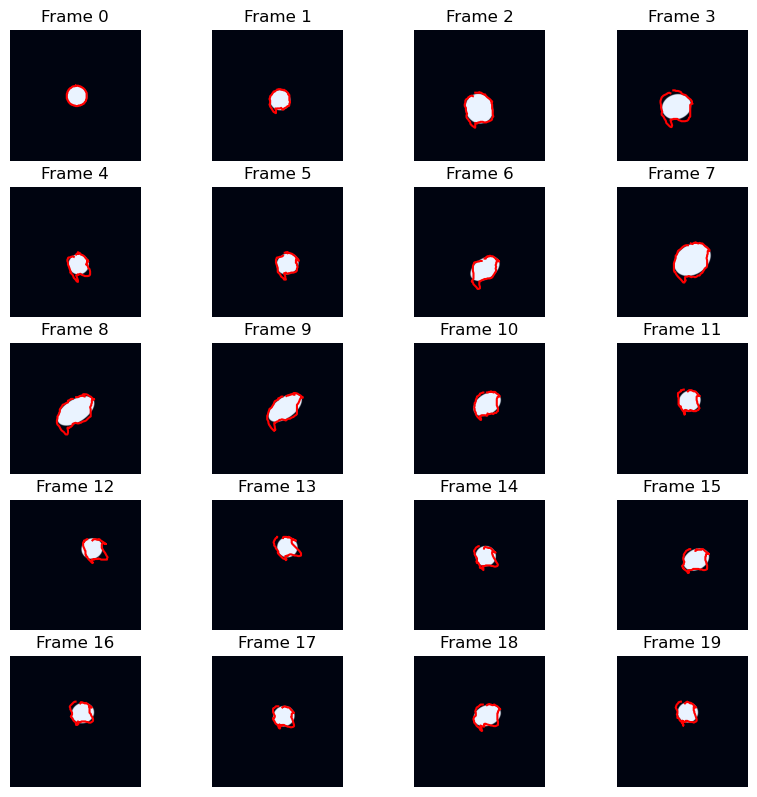

Epoch 1195, IOU: 0.794021
Epoch 1196, Loss: 14.67
Epoch 1197, Loss: 11.41
Epoch 1198, Loss: 10.35
Epoch 1199, Loss: 10.55
Epoch 1200, Loss: 10.32


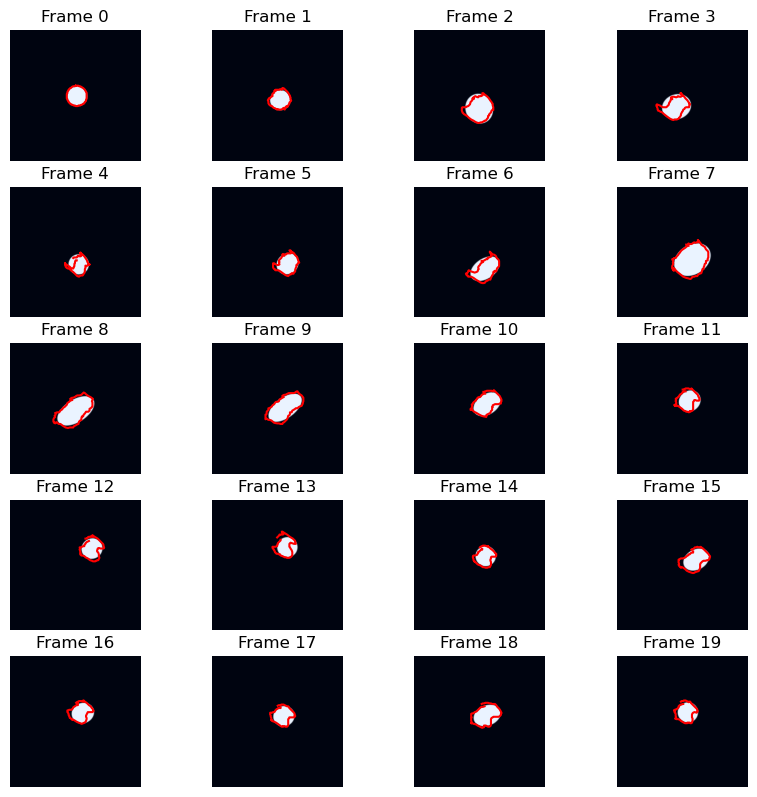

Epoch 1200, IOU: 0.772219
Epoch 1201, Loss: 14.35
Epoch 1202, Loss: 12.11
Epoch 1203, Loss: 11.68
Epoch 1204, Loss: 10.74
Epoch 1205, Loss: 10.31


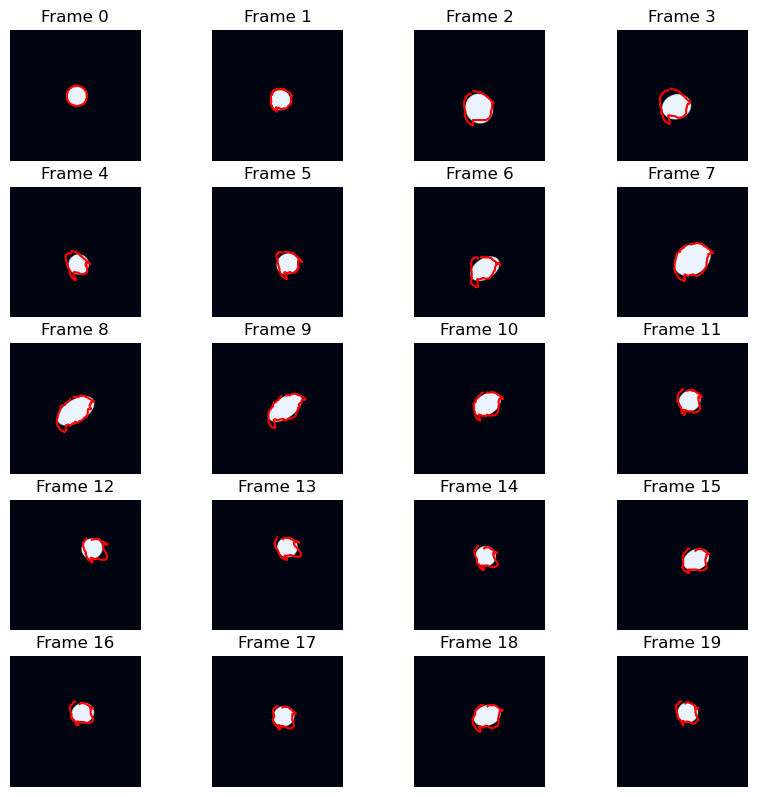

Epoch 1205, IOU: 0.777652
Epoch 1206, Loss: 17.83
Epoch 1207, Loss: 14.20
Epoch 1208, Loss: 13.66
Epoch 1209, Loss: 14.83
Epoch 1210, Loss: 11.54


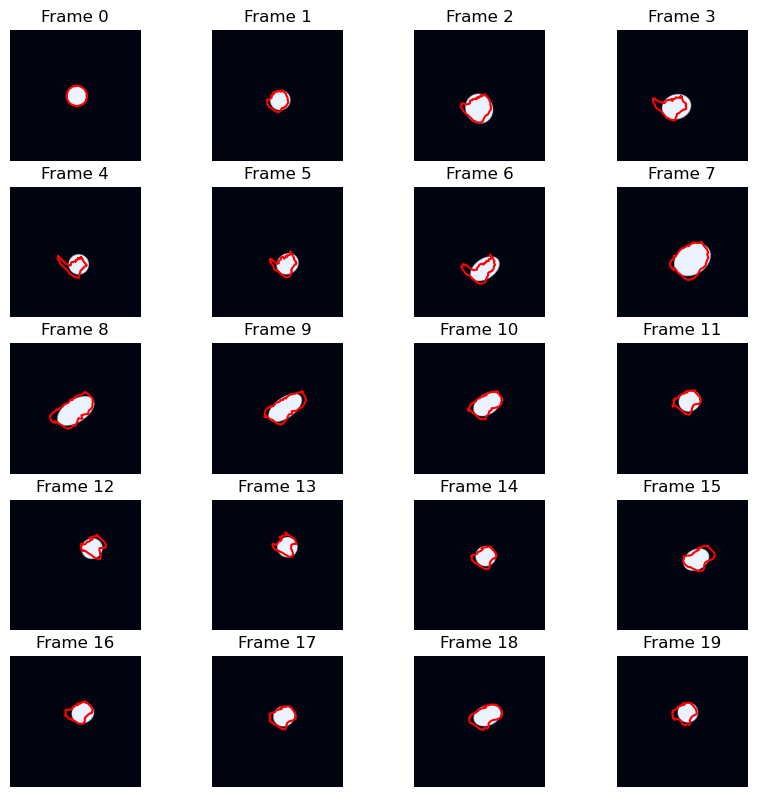

Epoch 1210, IOU: 0.704431
Epoch 1211, Loss: 17.53
Epoch 1212, Loss: 12.61
Epoch 1213, Loss: 12.64
Epoch 1214, Loss: 11.97
Epoch 1215, Loss: 12.40


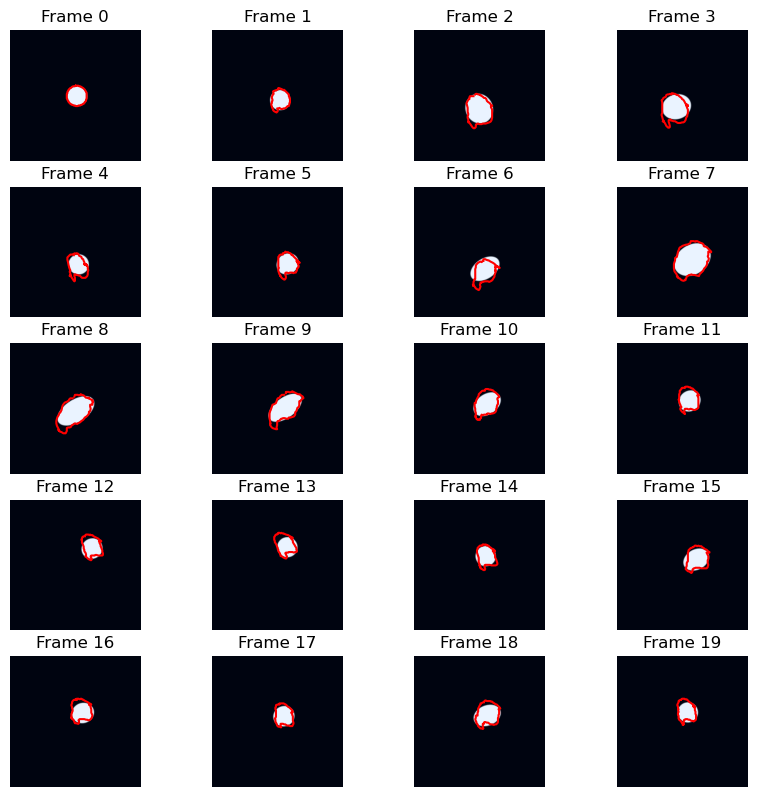

Epoch 1215, IOU: 0.744280
Epoch 1216, Loss: 15.53
Epoch 1217, Loss: 12.09
Epoch 1218, Loss: 11.74
Epoch 1219, Loss: 11.05
Epoch 1220, Loss: 13.11


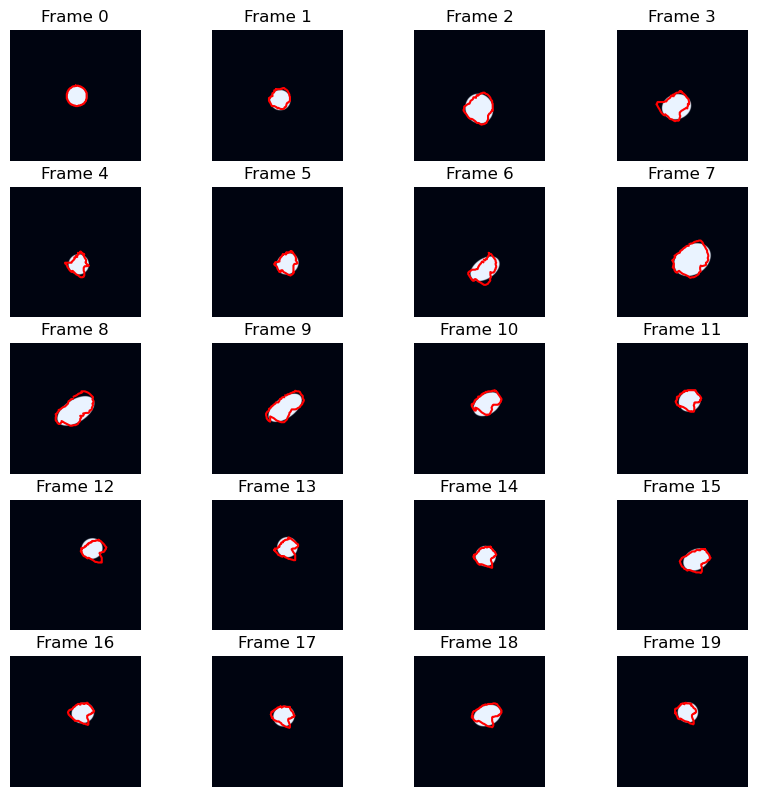

Epoch 1220, IOU: 0.781945
Epoch 1221, Loss: 14.24
Epoch 1222, Loss: 11.91
Epoch 1223, Loss: 11.06
Epoch 1224, Loss: 11.19
Epoch 1225, Loss: 12.30


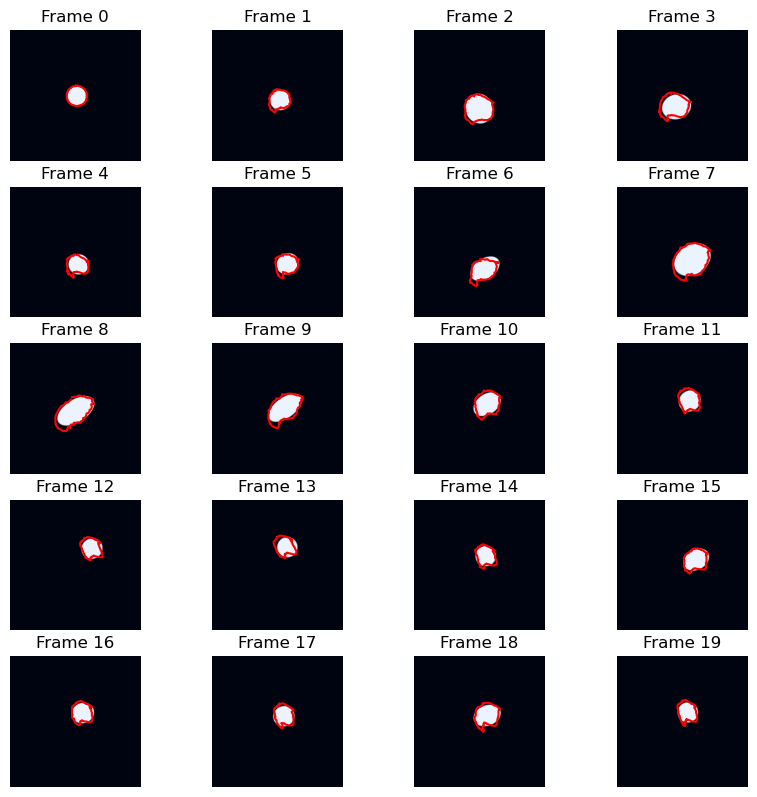

Epoch 1225, IOU: 0.795633
Epoch 1226, Loss: 12.33
Epoch 1227, Loss: 10.64
Epoch 1228, Loss: 9.75
Epoch 1229, Loss: 10.00
Epoch 1230, Loss: 9.90


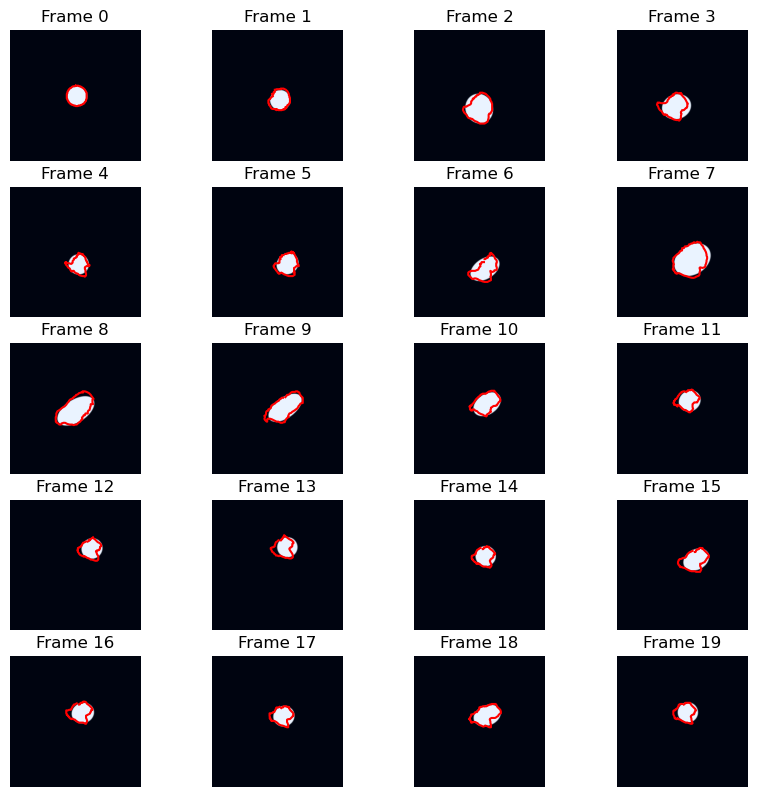

Epoch 1230, IOU: 0.772262
Epoch 1231, Loss: 12.96
Epoch 1232, Loss: 11.62
Epoch 1233, Loss: 10.99
Epoch 1234, Loss: 10.38
Epoch 1235, Loss: 11.00


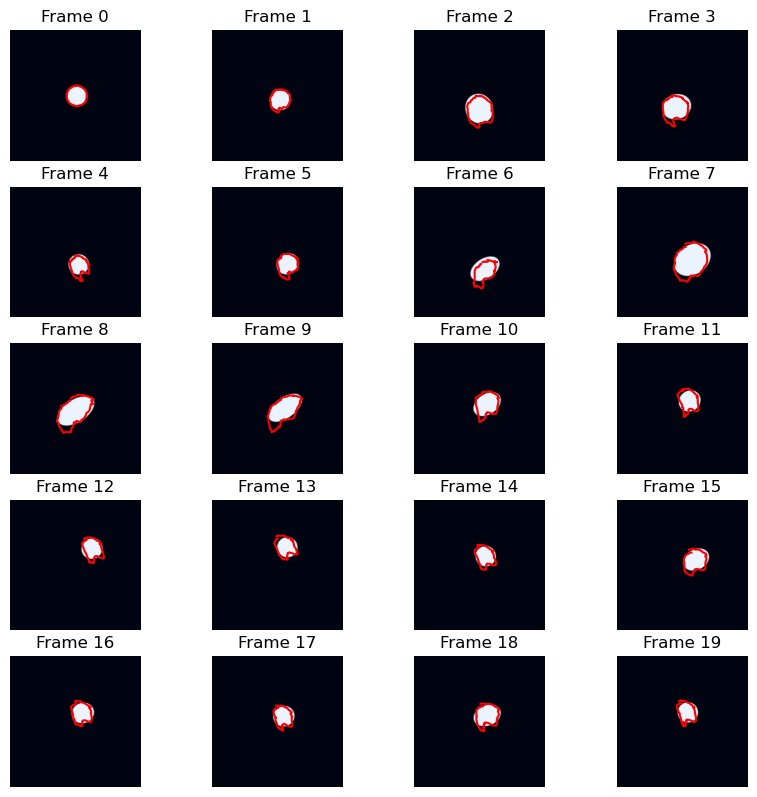

Epoch 1235, IOU: 0.759563
Epoch 1236, Loss: 17.79
Epoch 1237, Loss: 14.23
Epoch 1238, Loss: 14.16
Epoch 1239, Loss: 13.64
Epoch 1240, Loss: 12.39


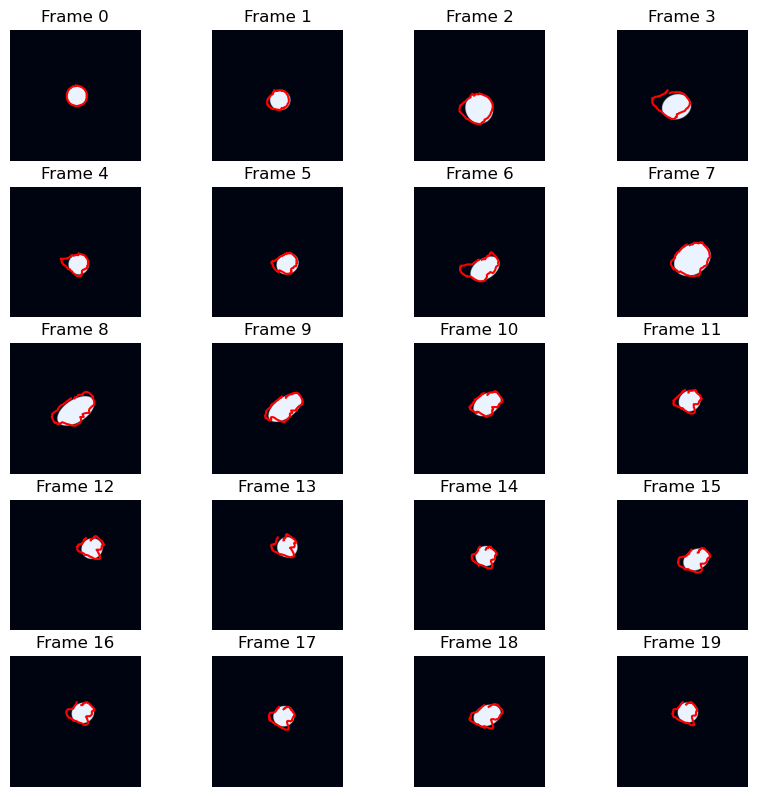

Epoch 1240, IOU: 0.768257
Epoch 1241, Loss: 16.93
Epoch 1242, Loss: 11.46
Epoch 1243, Loss: 11.97
Epoch 1244, Loss: 12.02
Epoch 1245, Loss: 12.54


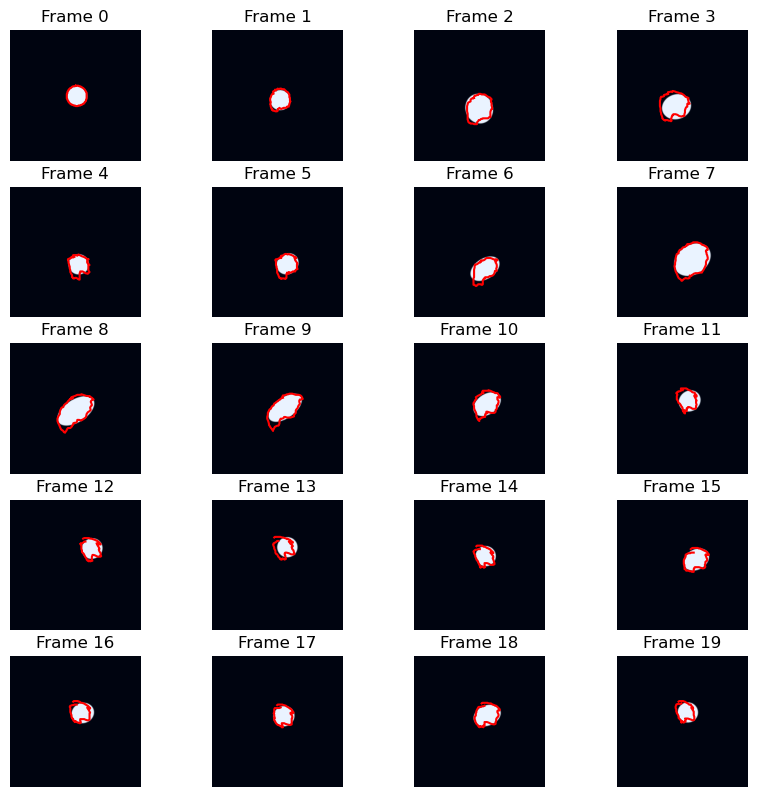

Epoch 1245, IOU: 0.772702
Epoch 1246, Loss: 13.46
Epoch 1247, Loss: 12.93
Epoch 1248, Loss: 12.32
Epoch 1249, Loss: 11.77
Epoch 1250, Loss: 12.62


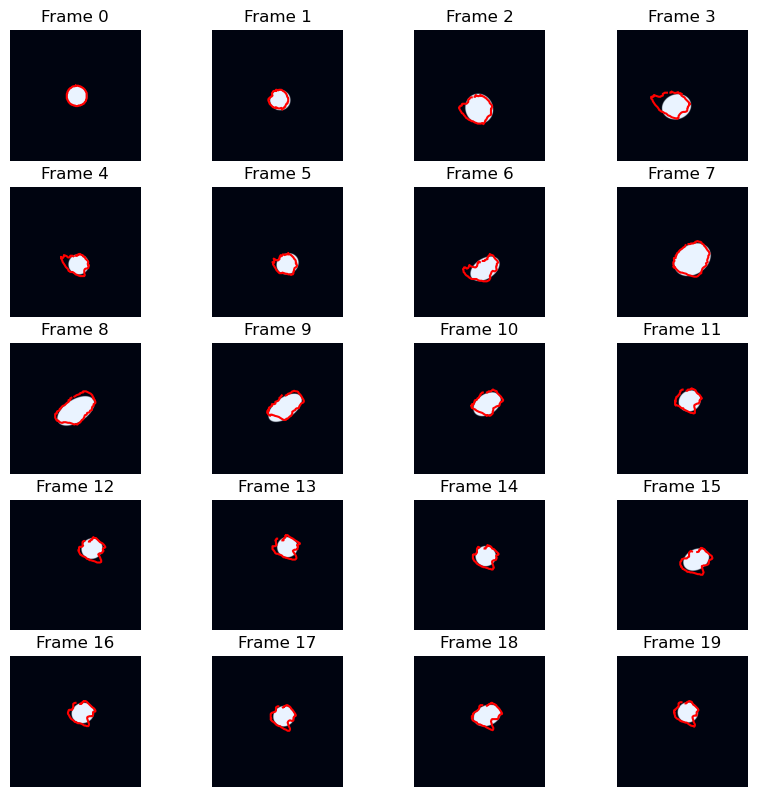

Epoch 1250, IOU: 0.774972
Epoch 1251, Loss: 14.68
Epoch 1252, Loss: 12.07
Epoch 1253, Loss: 12.40
Epoch 1254, Loss: 12.88
Epoch 1255, Loss: 10.35


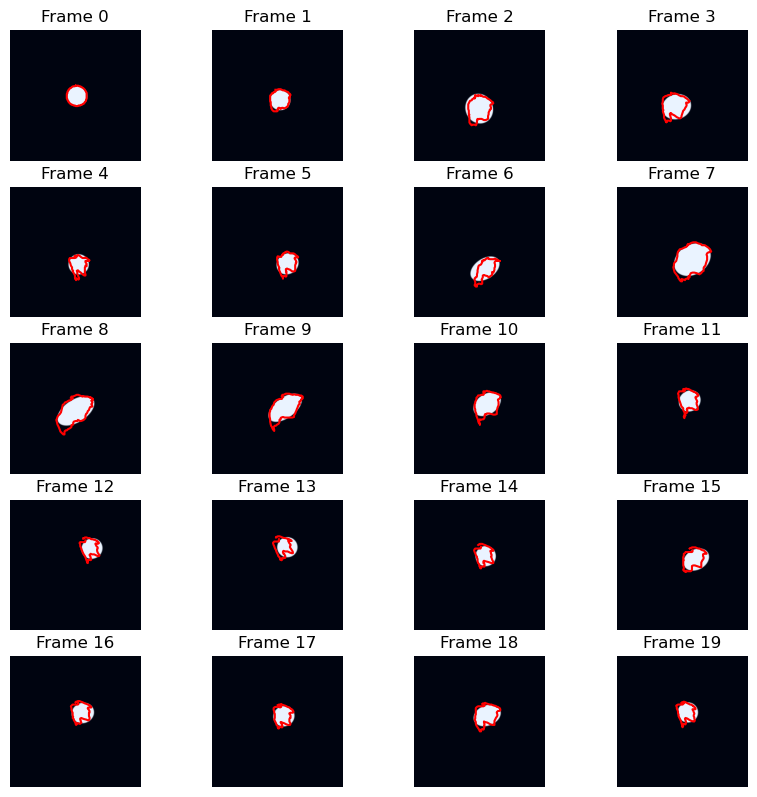

Epoch 1255, IOU: 0.731893
Epoch 1256, Loss: 15.86
Epoch 1257, Loss: 12.72
Epoch 1258, Loss: 11.55
Epoch 1259, Loss: 10.10
Epoch 1260, Loss: 10.59


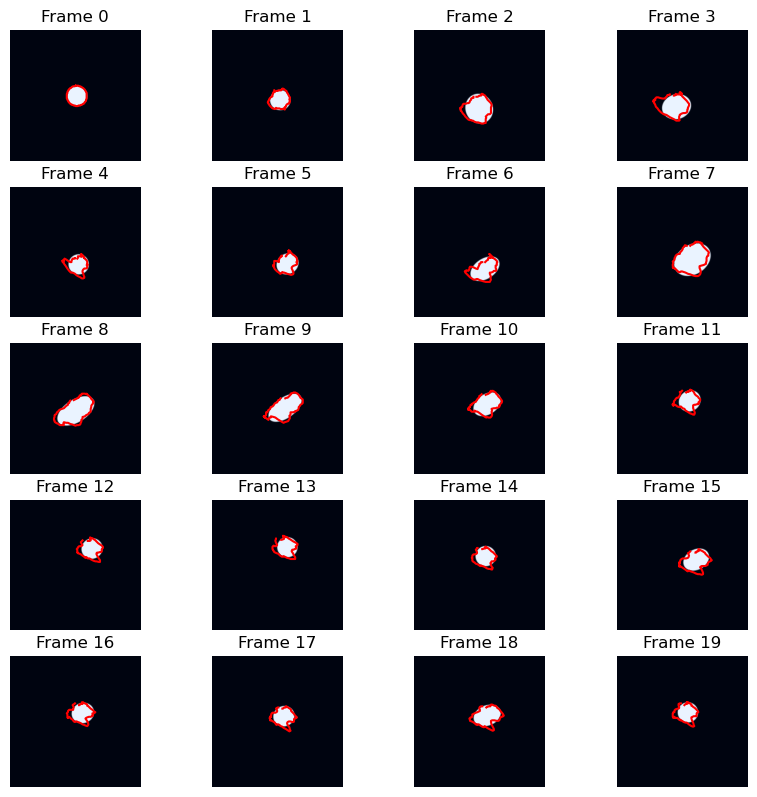

Epoch 1260, IOU: 0.770225
Epoch 1261, Loss: 15.16
Epoch 1262, Loss: 12.32
Epoch 1263, Loss: 10.74
Epoch 1264, Loss: 11.12
Epoch 1265, Loss: 10.55


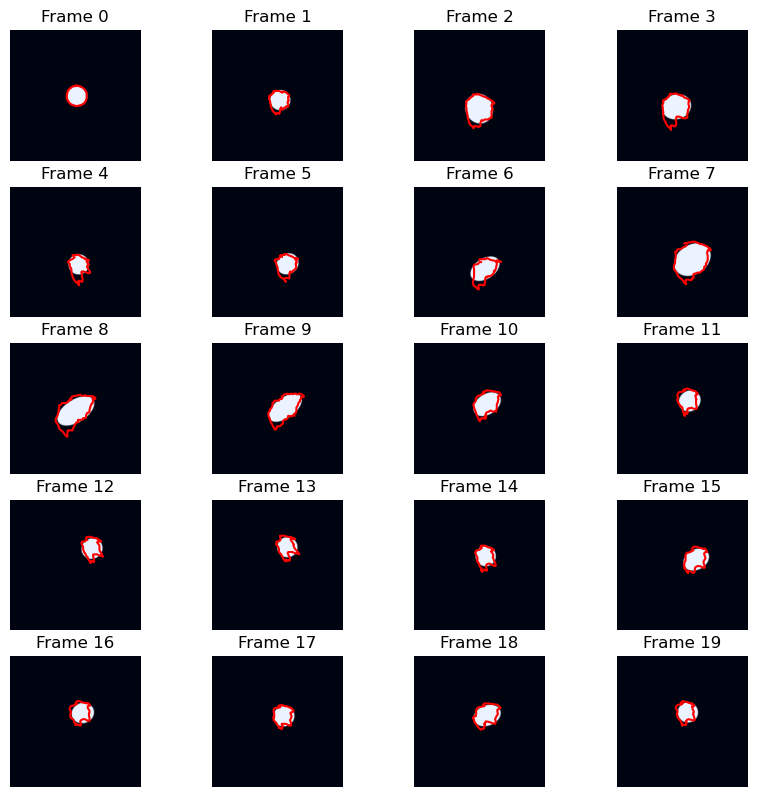

Epoch 1265, IOU: 0.754693
Epoch 1266, Loss: 16.04
Epoch 1267, Loss: 12.56
Epoch 1268, Loss: 11.61
Epoch 1269, Loss: 11.11
Epoch 1270, Loss: 10.89


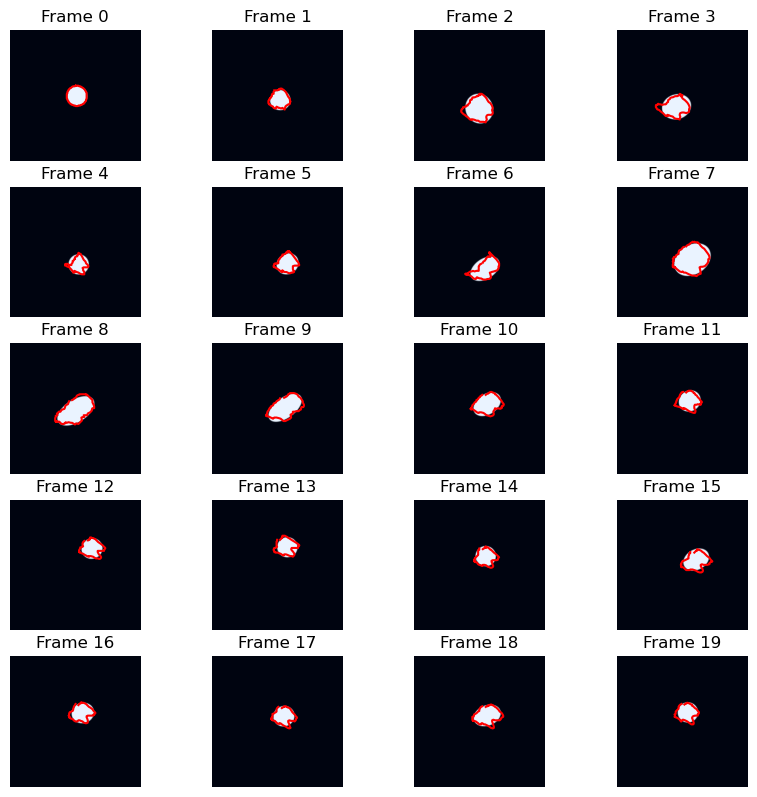

Epoch 1270, IOU: 0.787963
Epoch 1271, Loss: 13.48
Epoch 1272, Loss: 10.91
Epoch 1273, Loss: 10.91
Epoch 1274, Loss: 11.72
Epoch 1275, Loss: 10.92


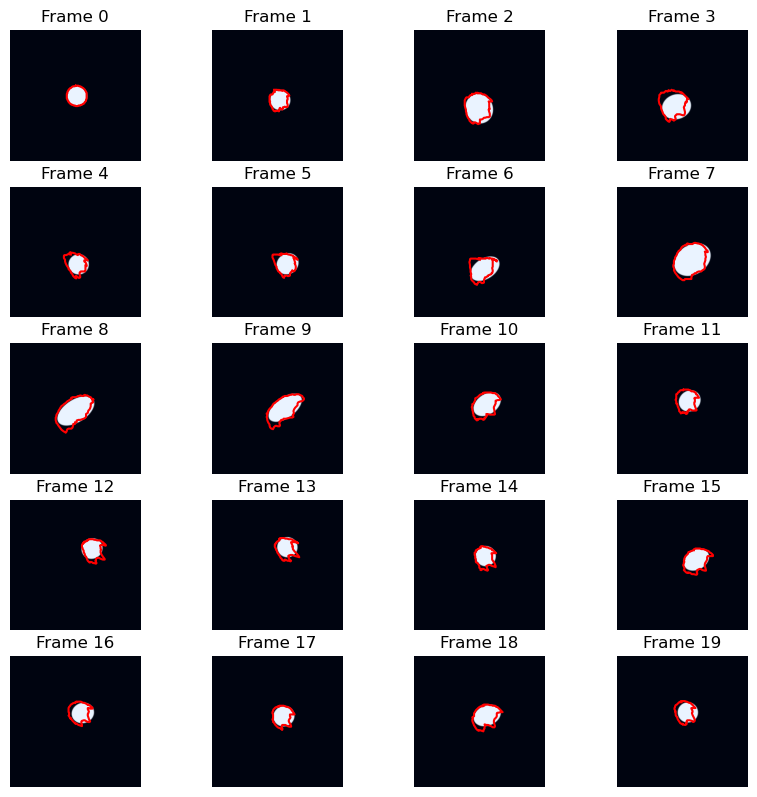

Epoch 1275, IOU: 0.748587
Epoch 1276, Loss: 14.81
Epoch 1277, Loss: 10.88
Epoch 1278, Loss: 12.26
Epoch 1279, Loss: 12.77
Epoch 1280, Loss: 10.81


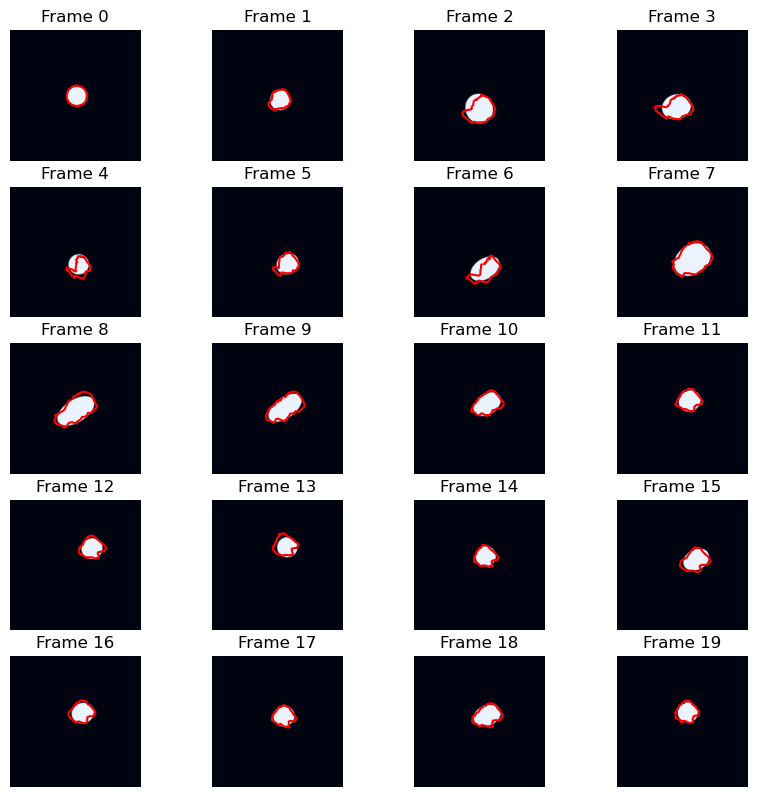

Epoch 1280, IOU: 0.779868
Epoch 1281, Loss: 13.84
Epoch 1282, Loss: 10.74
Epoch 1283, Loss: 10.03
Epoch 1284, Loss: 10.95
Epoch 1285, Loss: 10.97


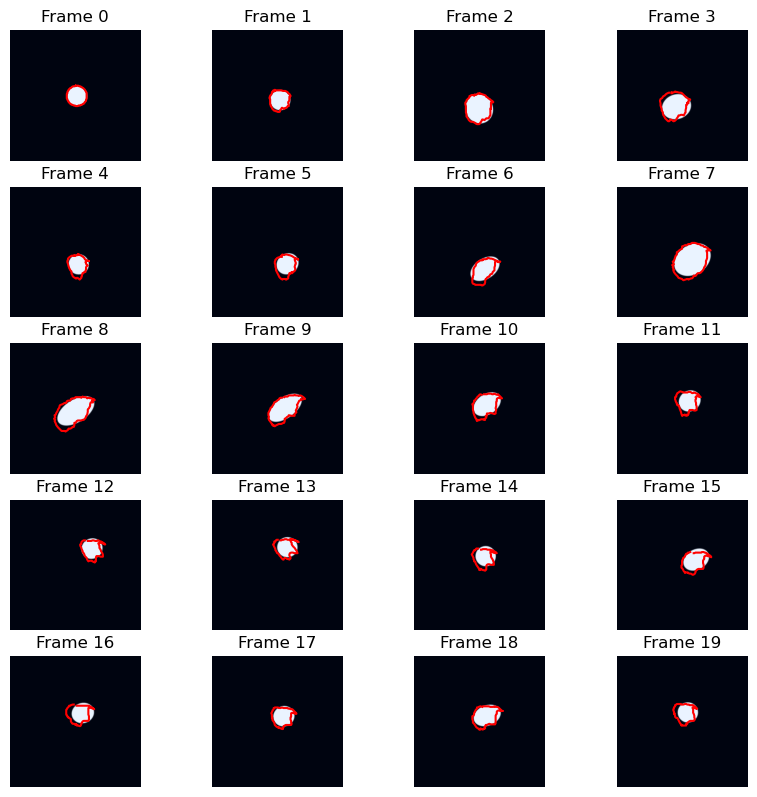

Epoch 1285, IOU: 0.751927
Epoch 1286, Loss: 14.08
Epoch 1287, Loss: 12.49
Epoch 1288, Loss: 11.89
Epoch 1289, Loss: 10.60
Epoch 1290, Loss: 11.05


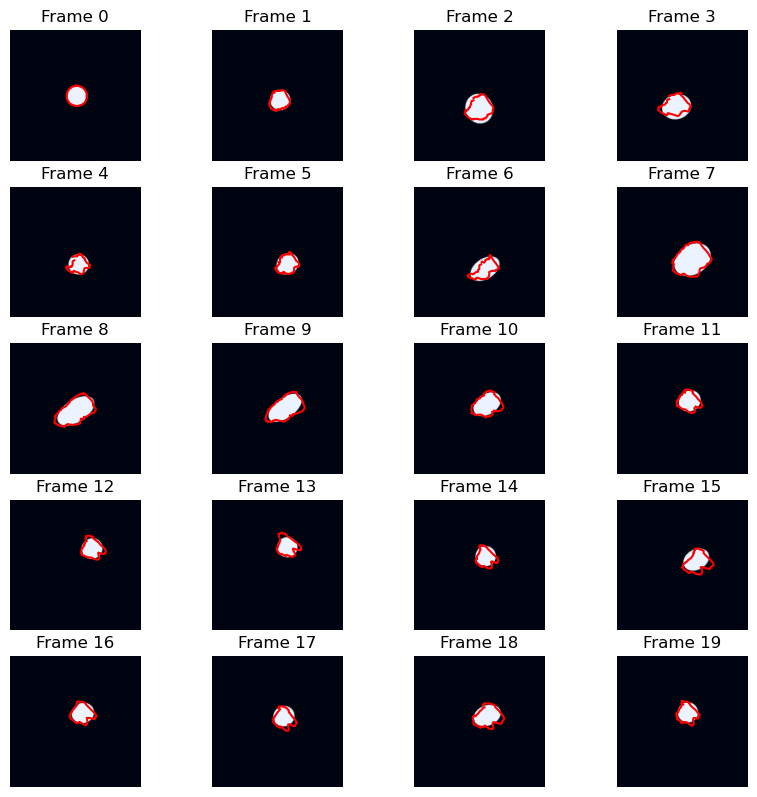

Epoch 1290, IOU: 0.766593
Epoch 1291, Loss: 15.30
Epoch 1292, Loss: 12.14
Epoch 1293, Loss: 11.18
Epoch 1294, Loss: 11.17
Epoch 1295, Loss: 11.11


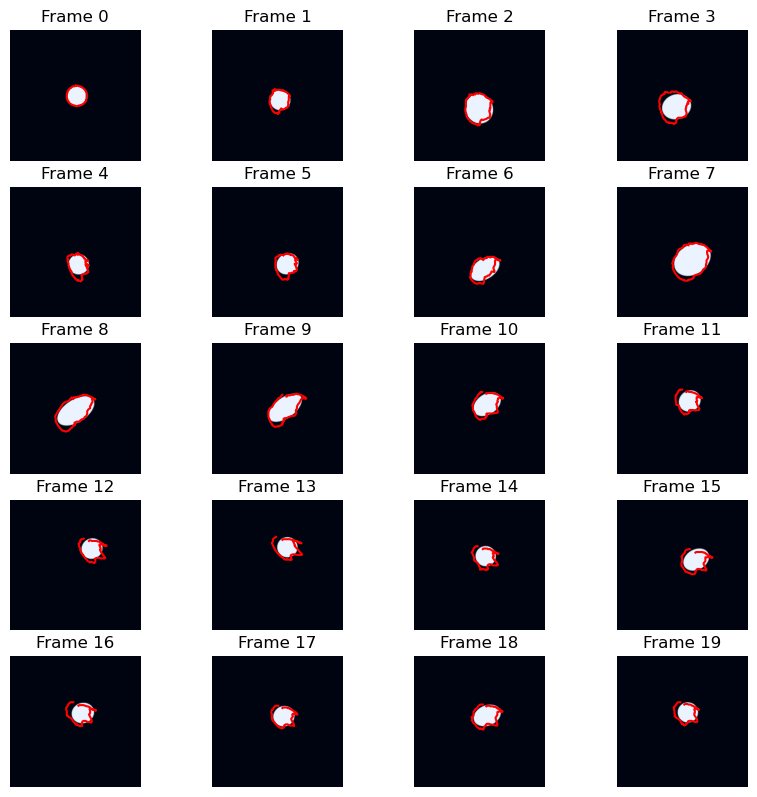

Epoch 1295, IOU: 0.752793
Epoch 1296, Loss: 14.94
Epoch 1297, Loss: 10.83
Epoch 1298, Loss: 10.48
Epoch 1299, Loss: 11.05
Epoch 1300, Loss: 10.18


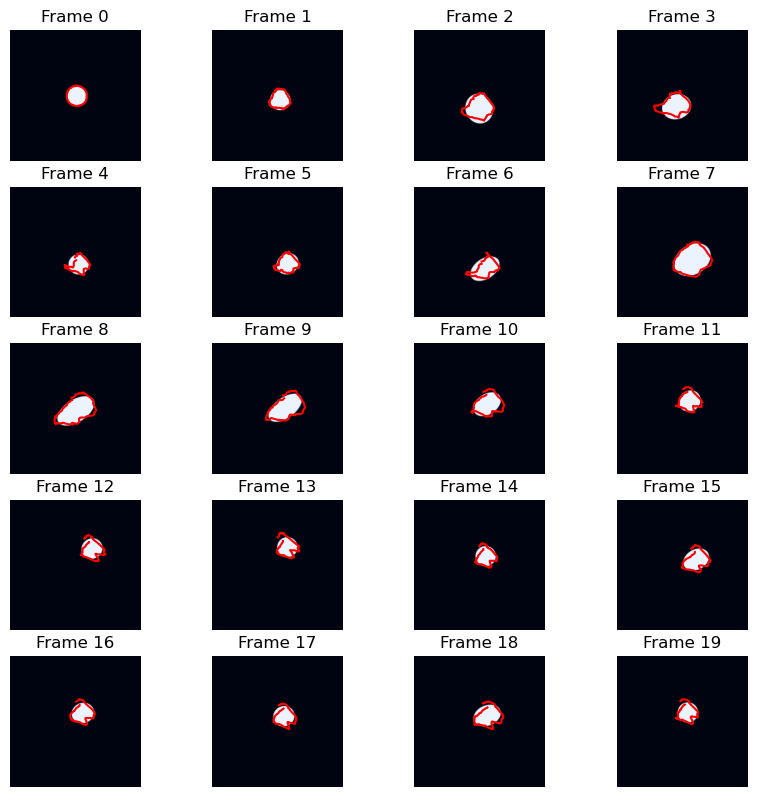

Epoch 1300, IOU: 0.746141
Epoch 1301, Loss: 17.07
Epoch 1302, Loss: 12.48
Epoch 1303, Loss: 12.38
Epoch 1304, Loss: 12.02
Epoch 1305, Loss: 11.74


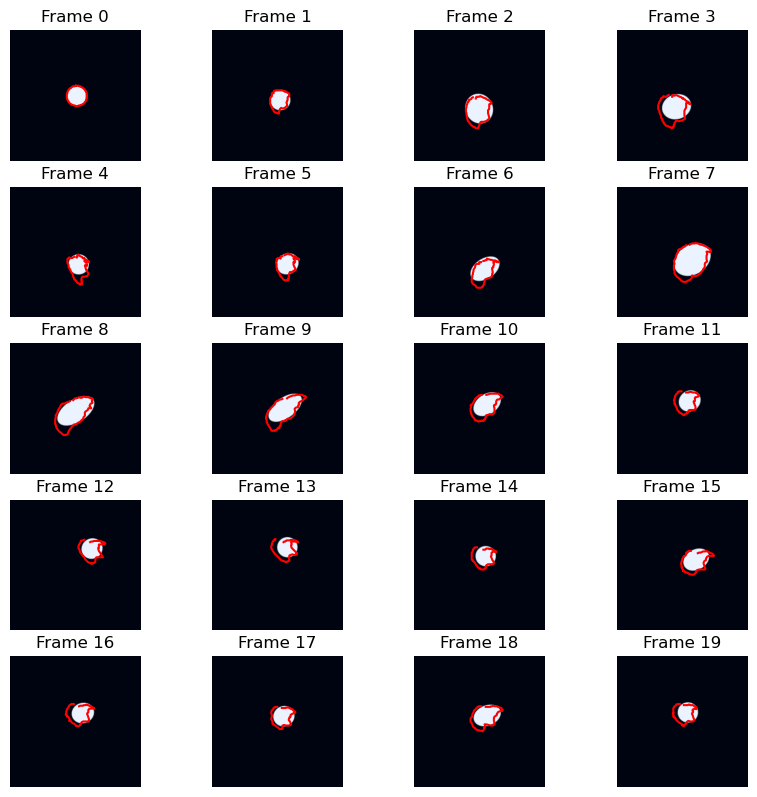

Epoch 1305, IOU: 0.695700
Epoch 1306, Loss: 15.68
Epoch 1307, Loss: 13.14
Epoch 1308, Loss: 10.72
Epoch 1309, Loss: 10.97
Epoch 1310, Loss: 11.79


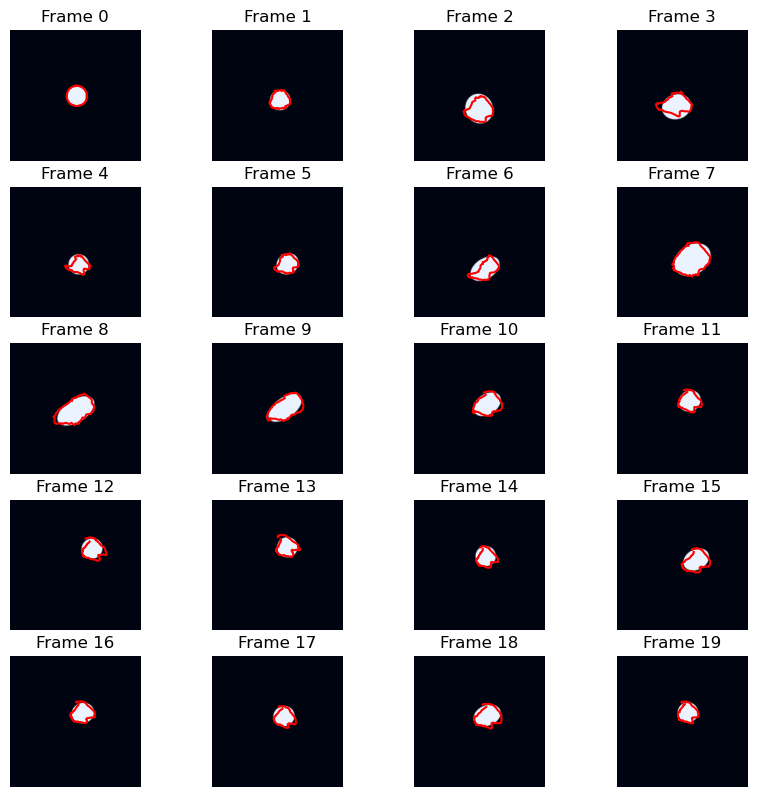

Epoch 1310, IOU: 0.775154
Epoch 1311, Loss: 13.77
Epoch 1312, Loss: 11.88
Epoch 1313, Loss: 10.43
Epoch 1314, Loss: 9.34
Epoch 1315, Loss: 10.55


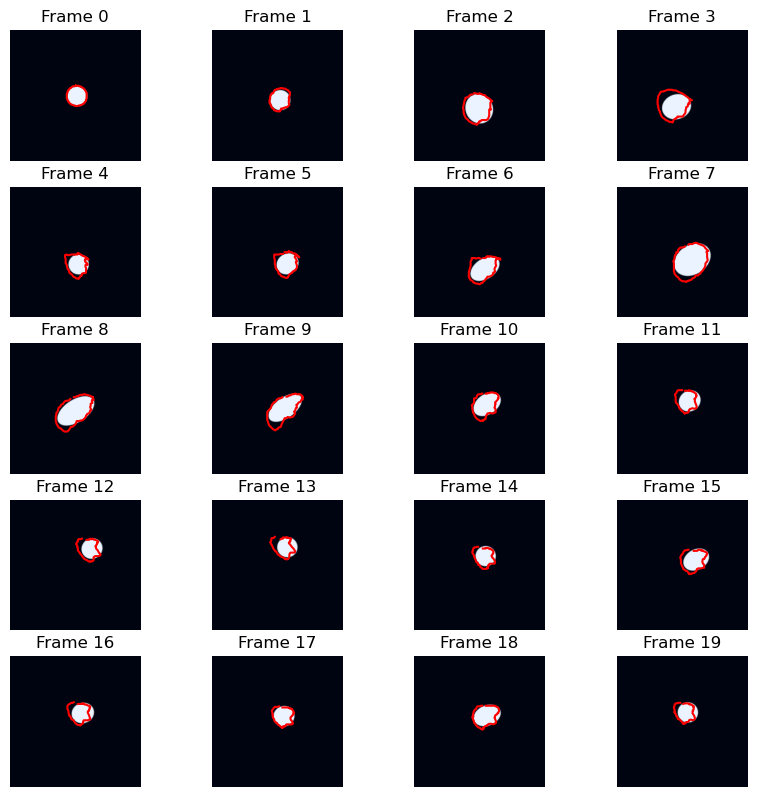

Epoch 1315, IOU: 0.740608
Epoch 1316, Loss: 13.68
Epoch 1317, Loss: 10.73
Epoch 1318, Loss: 11.22
Epoch 1319, Loss: 9.78
Epoch 1320, Loss: 9.93


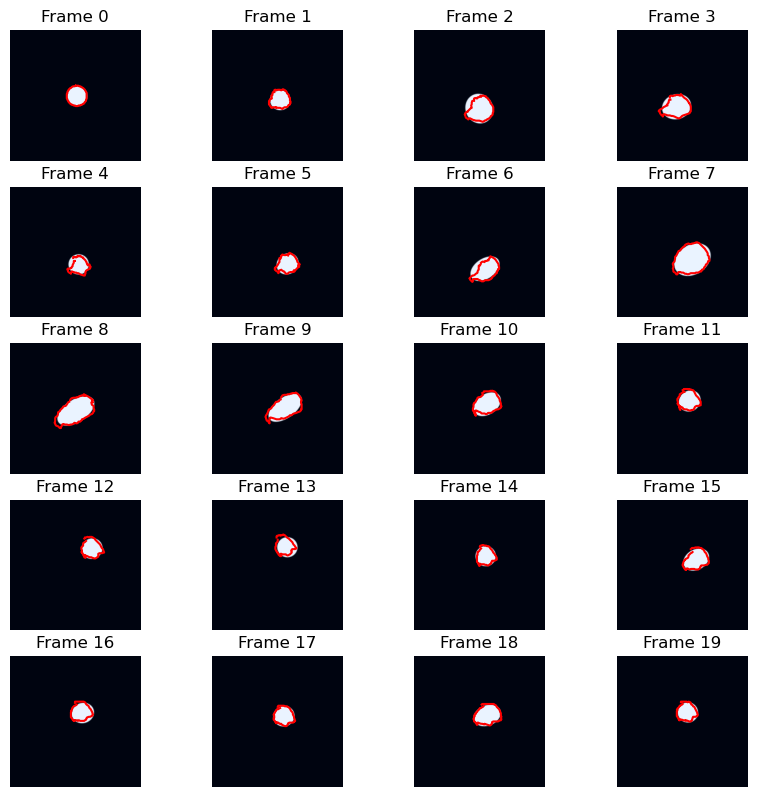

Epoch 1320, IOU: 0.798383
Epoch 1321, Loss: 13.54
Epoch 1322, Loss: 11.00
Epoch 1323, Loss: 11.13
Epoch 1324, Loss: 11.62
Epoch 1325, Loss: 11.52


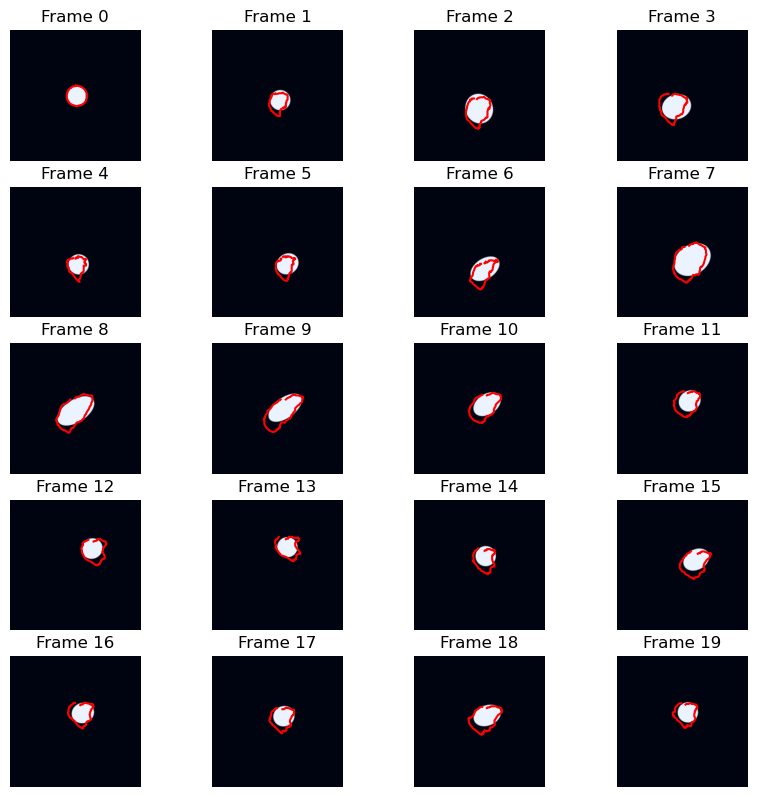

Epoch 1325, IOU: 0.682959
Epoch 1326, Loss: 14.72
Epoch 1327, Loss: 11.57
Epoch 1328, Loss: 11.61
Epoch 1329, Loss: 11.95
Epoch 1330, Loss: 9.98


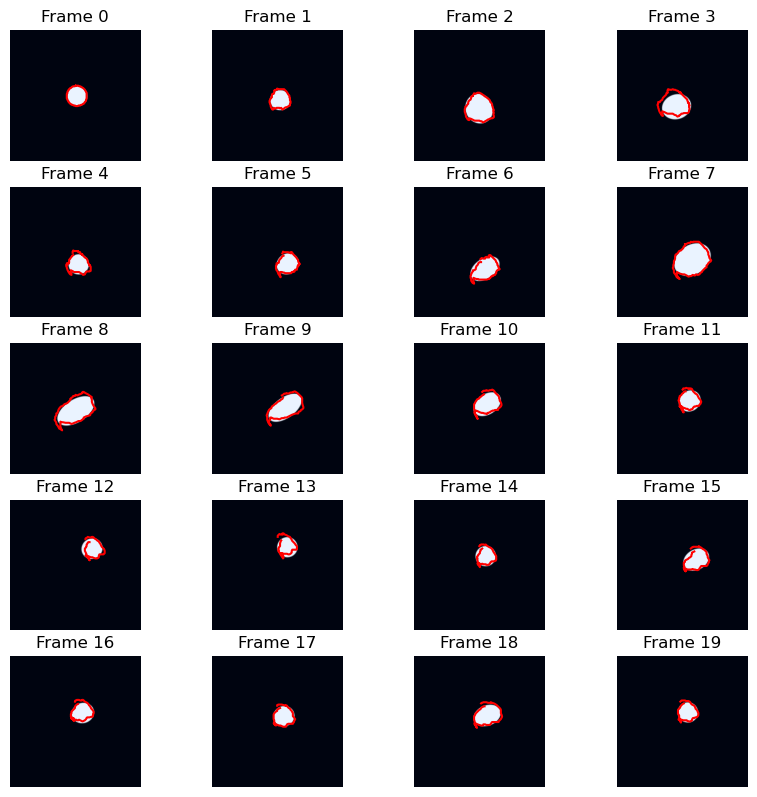

Epoch 1330, IOU: 0.790070
Epoch 1331, Loss: 13.08
Epoch 1332, Loss: 10.63
Epoch 1333, Loss: 10.48
Epoch 1334, Loss: 9.76
Epoch 1335, Loss: 11.34


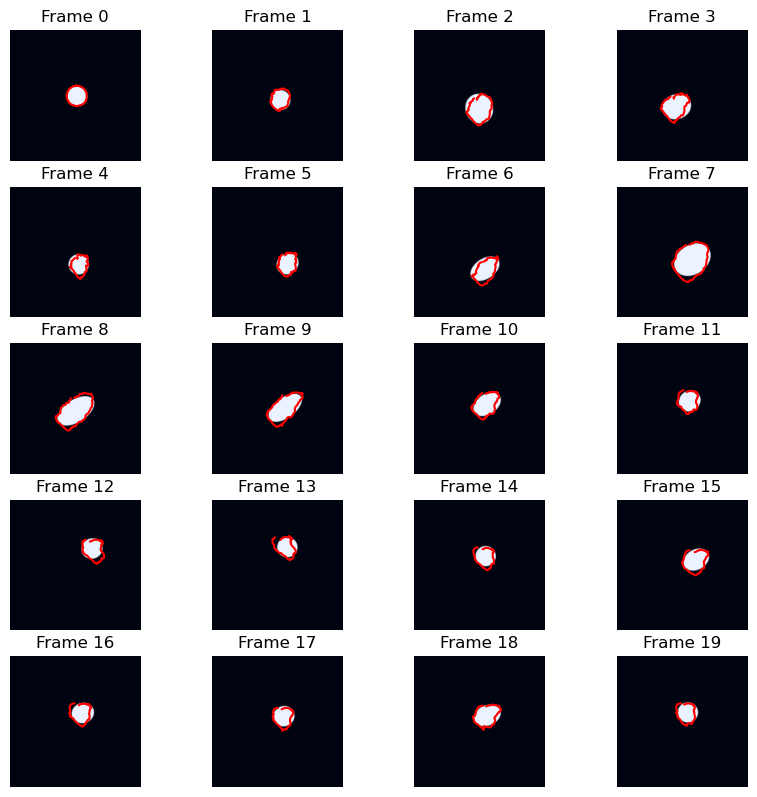

Epoch 1335, IOU: 0.784748
Epoch 1336, Loss: 14.21
Epoch 1337, Loss: 12.84
Epoch 1338, Loss: 11.86
Epoch 1339, Loss: 10.99
Epoch 1340, Loss: 10.23


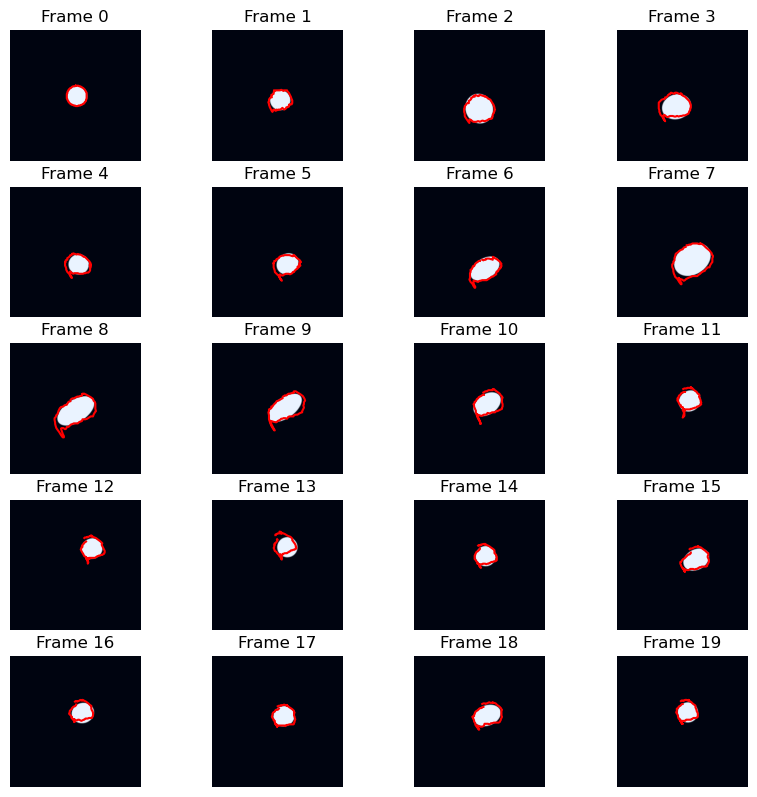

Epoch 1340, IOU: 0.792722
Epoch 1341, Loss: 13.54
Epoch 1342, Loss: 12.76
Epoch 1343, Loss: 13.34
Epoch 1344, Loss: 10.70
Epoch 1345, Loss: 11.43


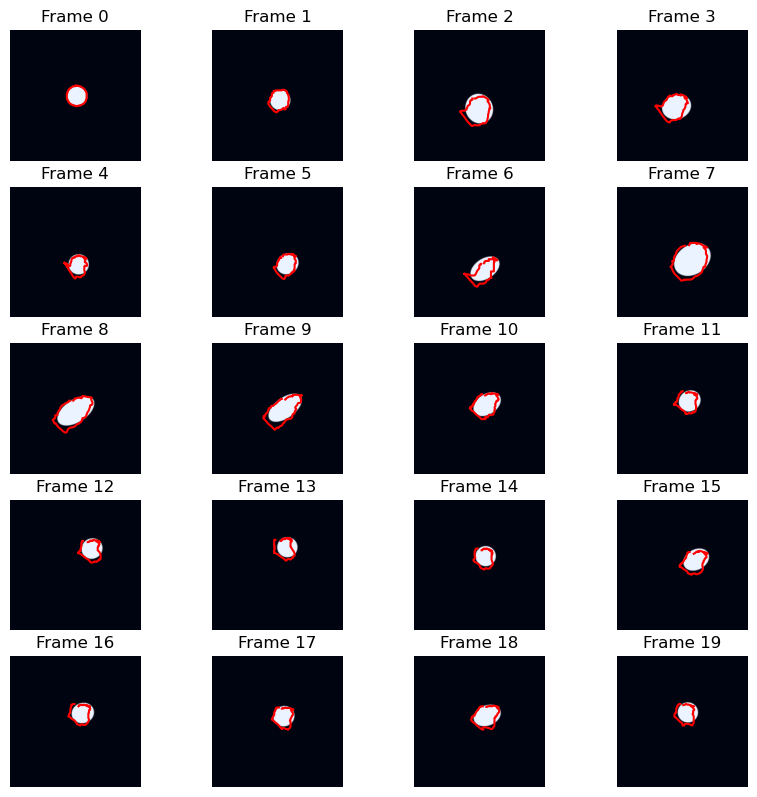

Epoch 1345, IOU: 0.737869
Epoch 1346, Loss: 13.03
Epoch 1347, Loss: 11.88
Epoch 1348, Loss: 11.54
Epoch 1349, Loss: 10.08
Epoch 1350, Loss: 12.28


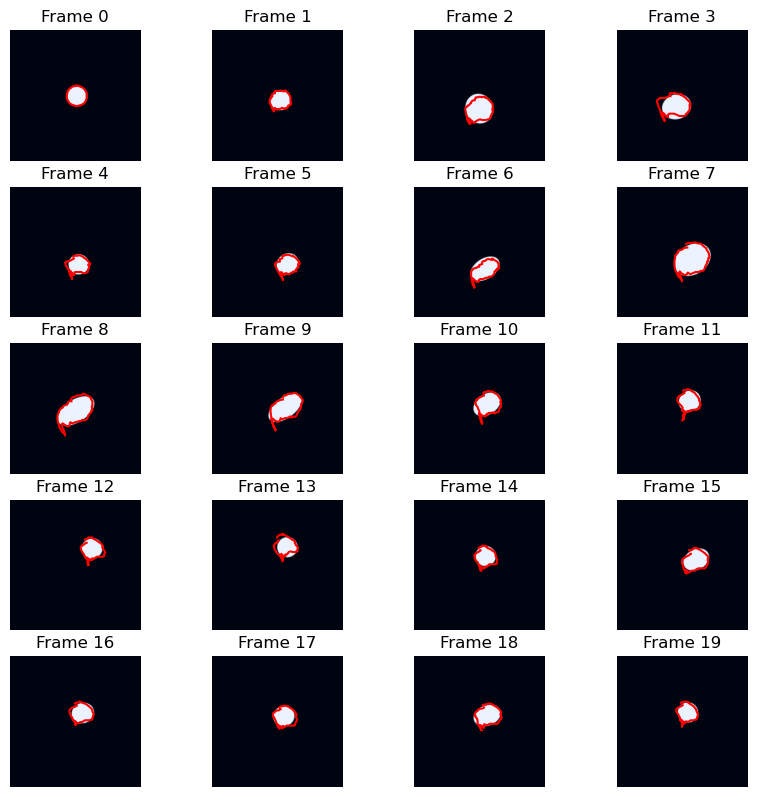

Epoch 1350, IOU: 0.814970
Epoch 1351, Loss: 15.12
Epoch 1352, Loss: 12.78
Epoch 1353, Loss: 11.02
Epoch 1354, Loss: 12.12
Epoch 1355, Loss: 11.15


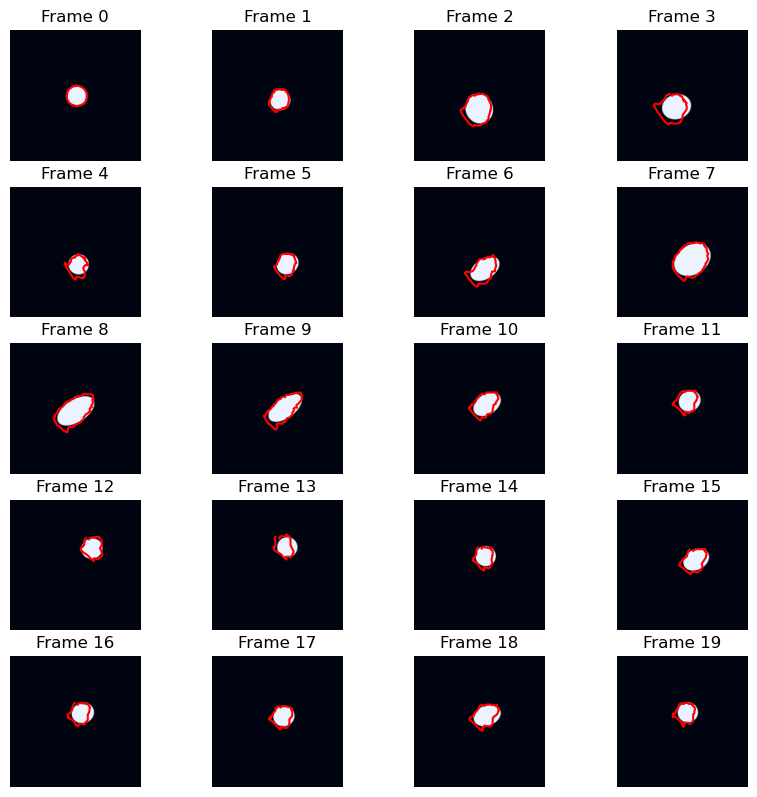

Epoch 1355, IOU: 0.760683
Epoch 1356, Loss: 13.74
Epoch 1357, Loss: 12.02
Epoch 1358, Loss: 11.47
Epoch 1359, Loss: 11.21
Epoch 1360, Loss: 9.98


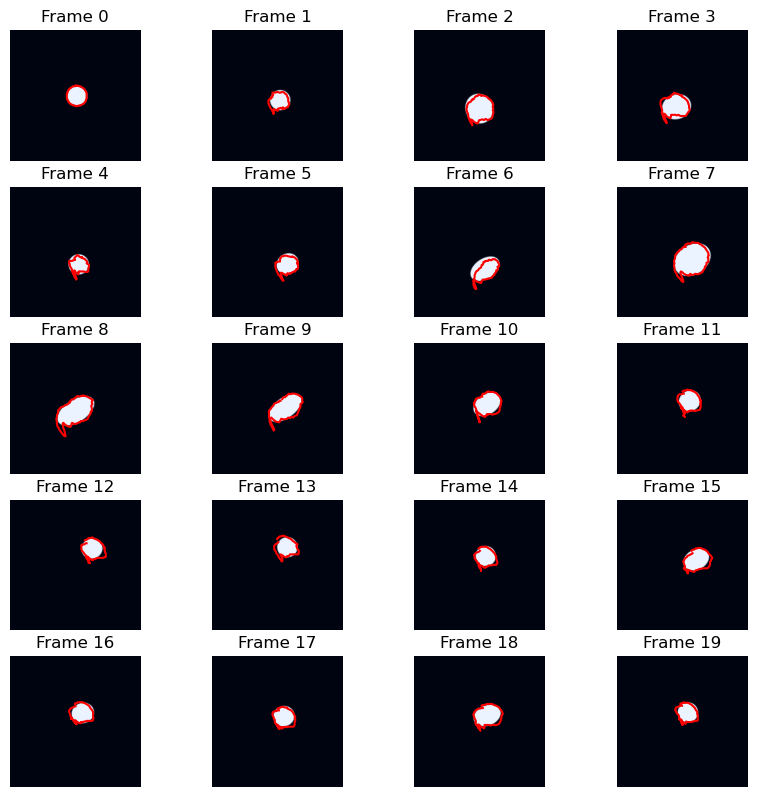

Epoch 1360, IOU: 0.805963
Epoch 1361, Loss: 14.67
Epoch 1362, Loss: 10.89
Epoch 1363, Loss: 11.36
Epoch 1364, Loss: 11.44
Epoch 1365, Loss: 10.97


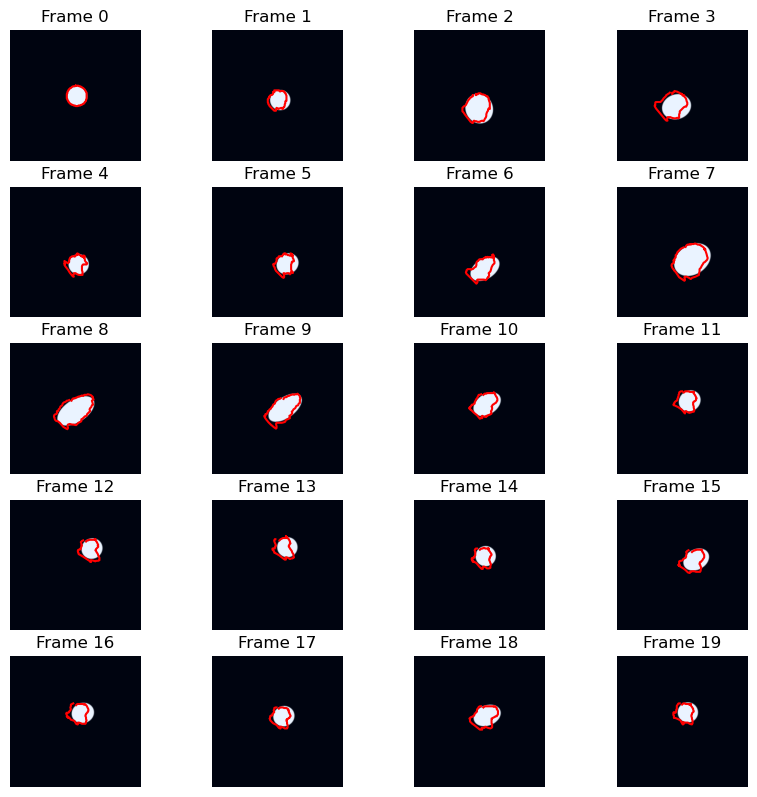

Epoch 1365, IOU: 0.711522
Epoch 1366, Loss: 14.47
Epoch 1367, Loss: 11.42
Epoch 1368, Loss: 10.40
Epoch 1369, Loss: 12.71
Epoch 1370, Loss: 11.42


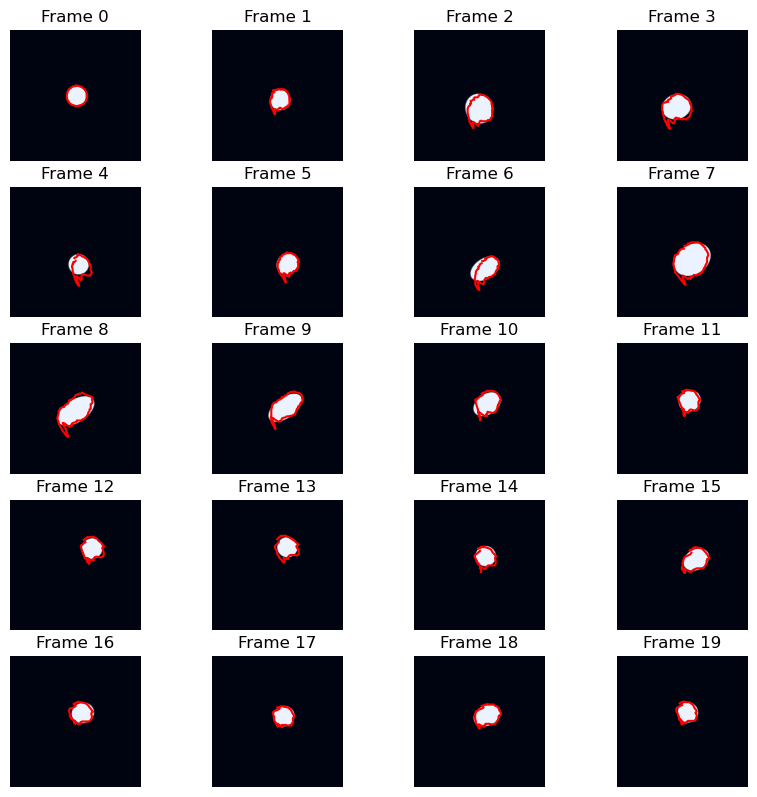

Epoch 1370, IOU: 0.815101
Epoch 1371, Loss: 16.11
Epoch 1372, Loss: 14.29
Epoch 1373, Loss: 11.74
Epoch 1374, Loss: 11.20
Epoch 1375, Loss: 11.97


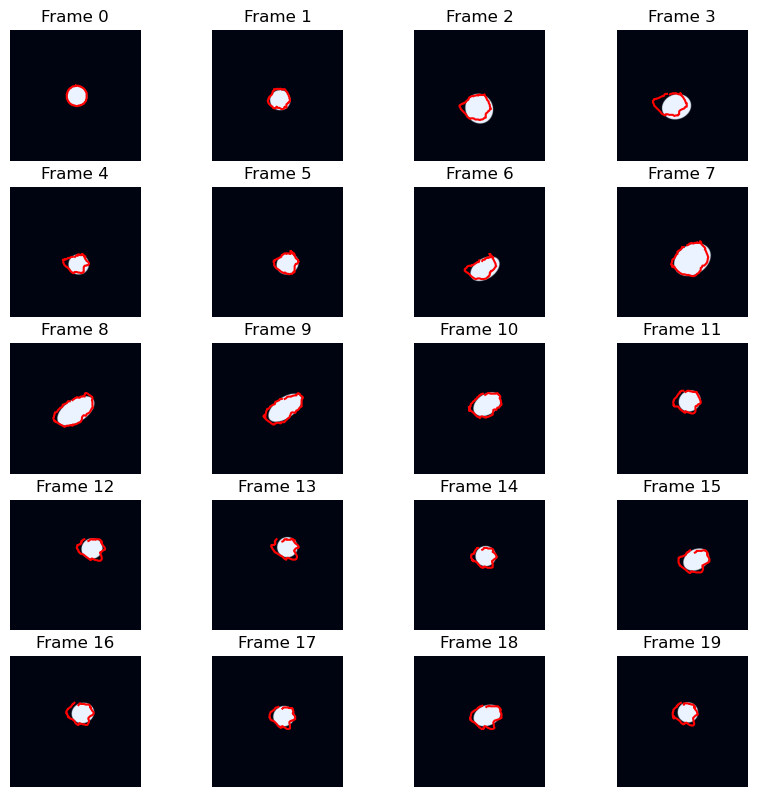

Epoch 1375, IOU: 0.772899
Epoch 1376, Loss: 14.22
Epoch 1377, Loss: 13.46
Epoch 1378, Loss: 11.28
Epoch 1379, Loss: 11.13
Epoch 1380, Loss: 10.67


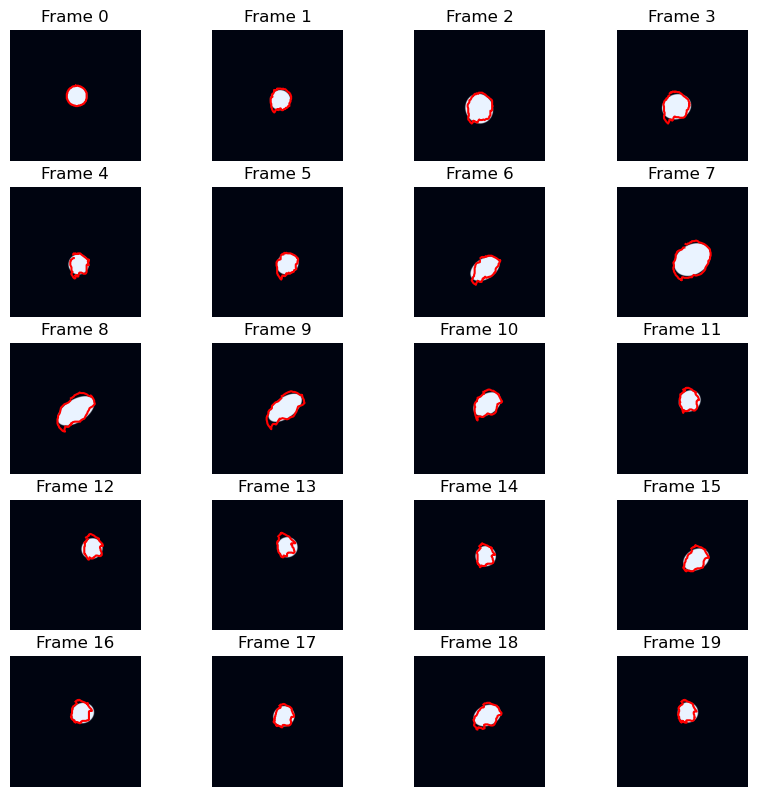

Epoch 1380, IOU: 0.798601
Epoch 1381, Loss: 13.81
Epoch 1382, Loss: 11.70
Epoch 1383, Loss: 11.86
Epoch 1384, Loss: 11.80
Epoch 1385, Loss: 11.65


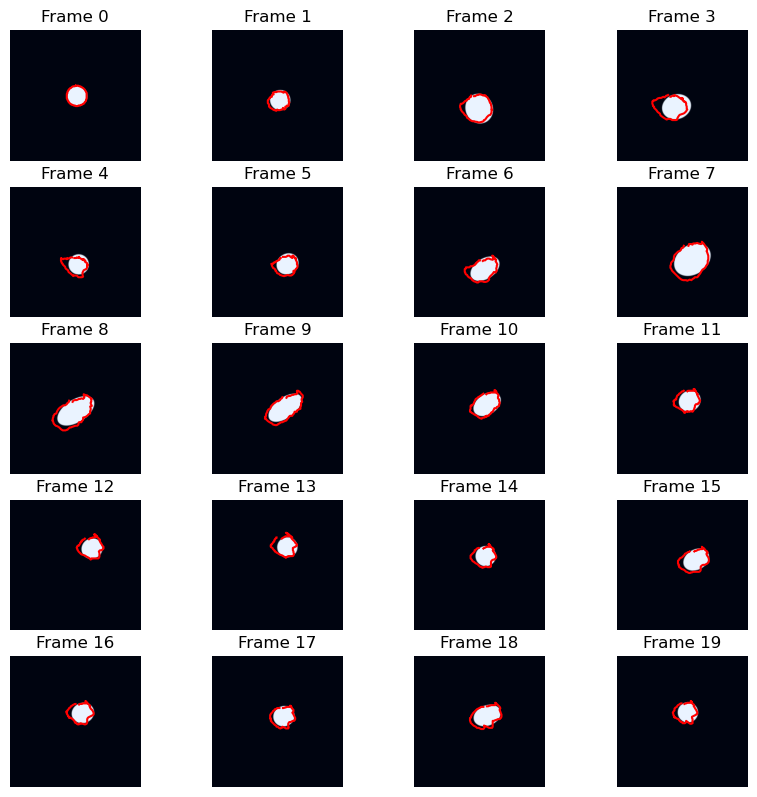

Epoch 1385, IOU: 0.767709
Epoch 1386, Loss: 13.60
Epoch 1387, Loss: 12.42
Epoch 1388, Loss: 11.80
Epoch 1389, Loss: 10.27
Epoch 1390, Loss: 11.68


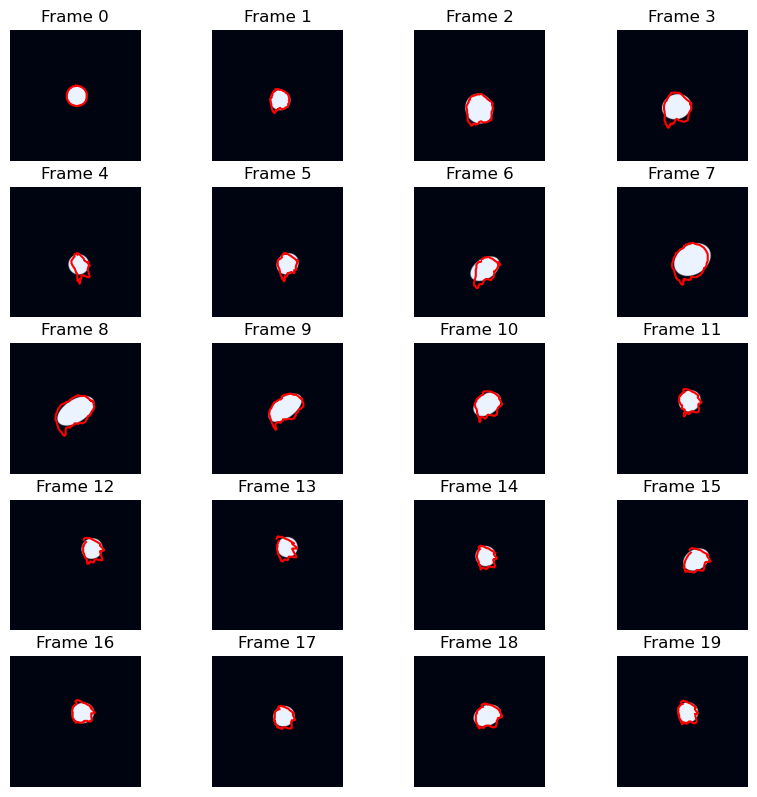

Epoch 1390, IOU: 0.790706
Epoch 1391, Loss: 15.85
Epoch 1392, Loss: 13.06
Epoch 1393, Loss: 11.36
Epoch 1394, Loss: 12.21
Epoch 1395, Loss: 11.21


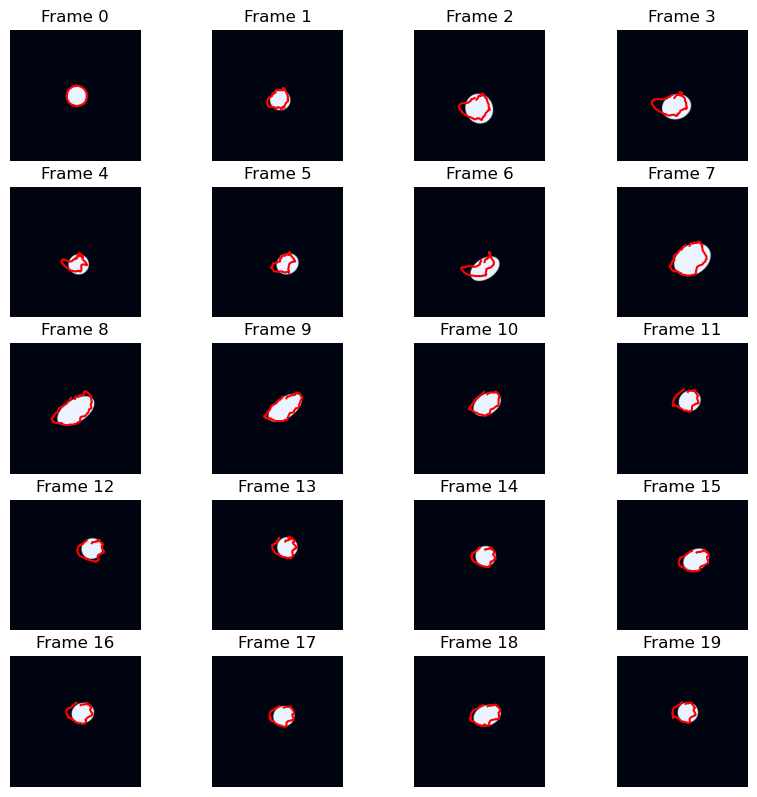

Epoch 1395, IOU: 0.717141
Epoch 1396, Loss: 14.98
Epoch 1397, Loss: 11.11
Epoch 1398, Loss: 10.24
Epoch 1399, Loss: 13.03
Epoch 1400, Loss: 10.57


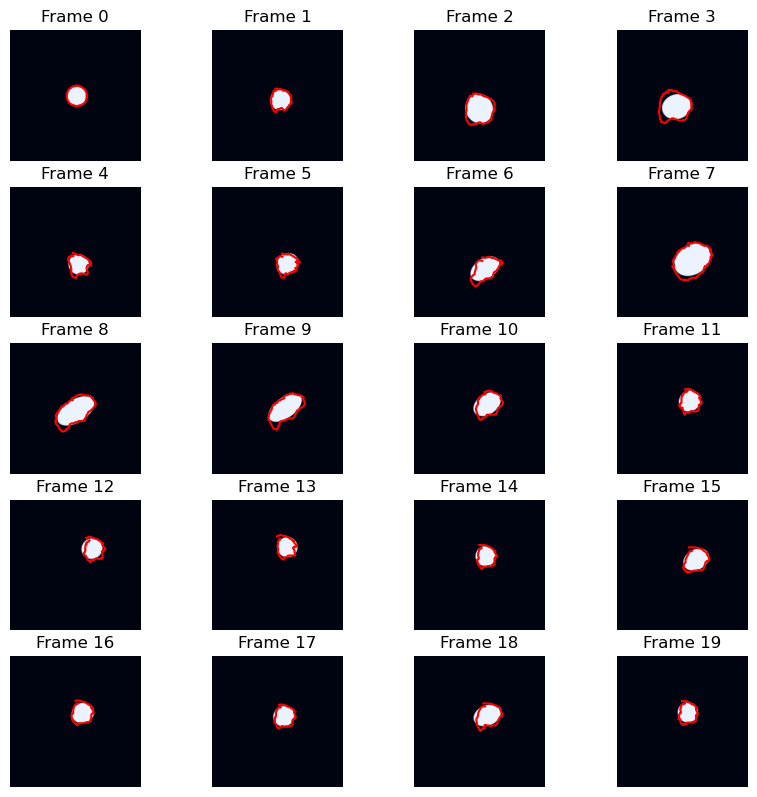

Epoch 1400, IOU: 0.812351
Epoch 1401, Loss: 13.20
Epoch 1402, Loss: 11.07
Epoch 1403, Loss: 10.34
Epoch 1404, Loss: 10.27
Epoch 1405, Loss: 11.79


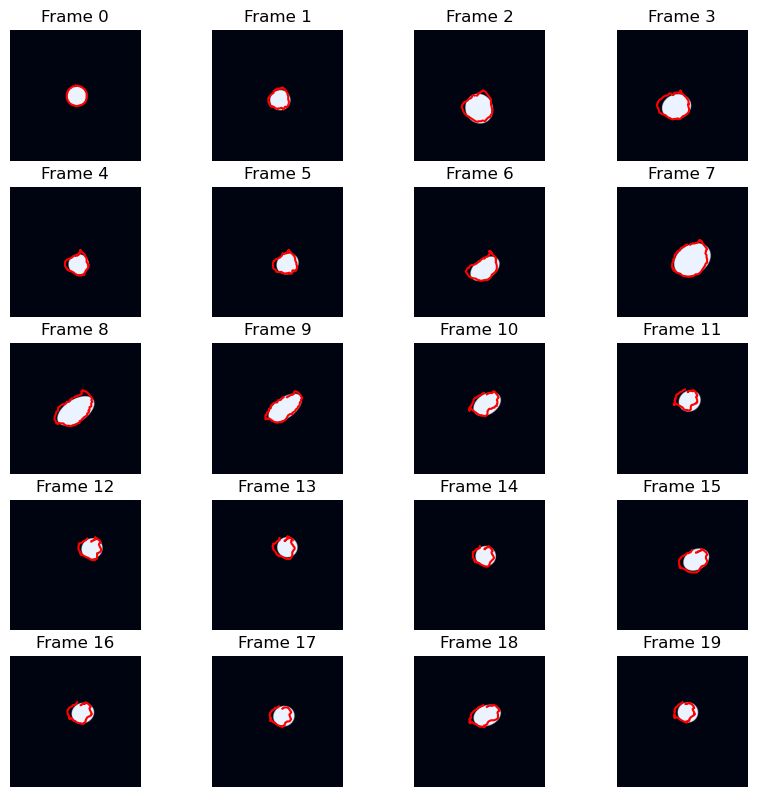

Epoch 1405, IOU: 0.776677
Epoch 1406, Loss: 12.94
Epoch 1407, Loss: 11.15
Epoch 1408, Loss: 10.31
Epoch 1409, Loss: 9.87
Epoch 1410, Loss: 10.70


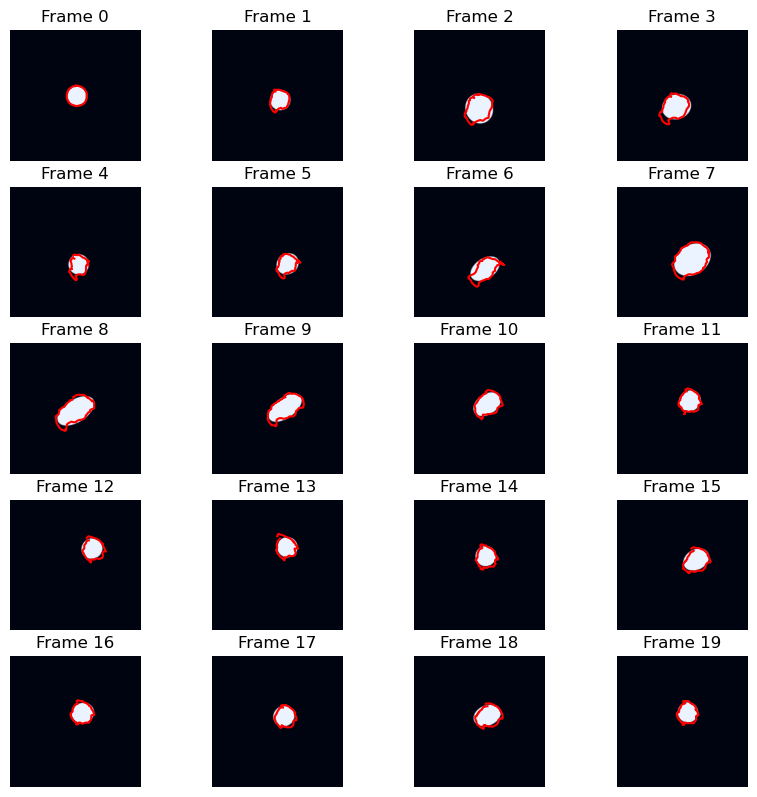

Epoch 1410, IOU: 0.815611
Epoch 1411, Loss: 12.35
Epoch 1412, Loss: 10.85
Epoch 1413, Loss: 10.67
Epoch 1414, Loss: 11.12
Epoch 1415, Loss: 10.59


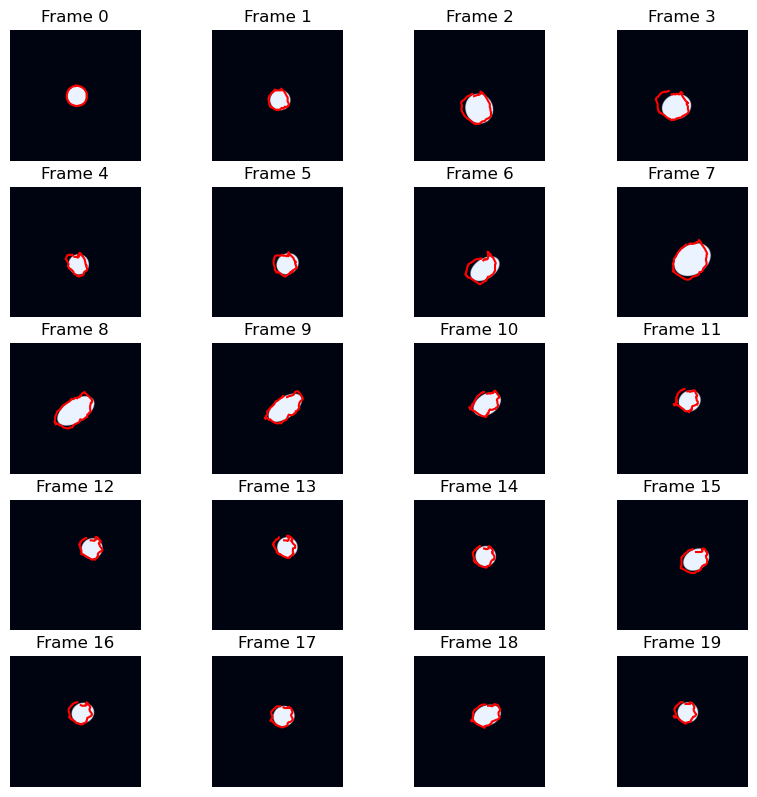

Epoch 1415, IOU: 0.776096
Epoch 1416, Loss: 12.26
Epoch 1417, Loss: 11.36
Epoch 1418, Loss: 10.87
Epoch 1419, Loss: 10.44
Epoch 1420, Loss: 10.67


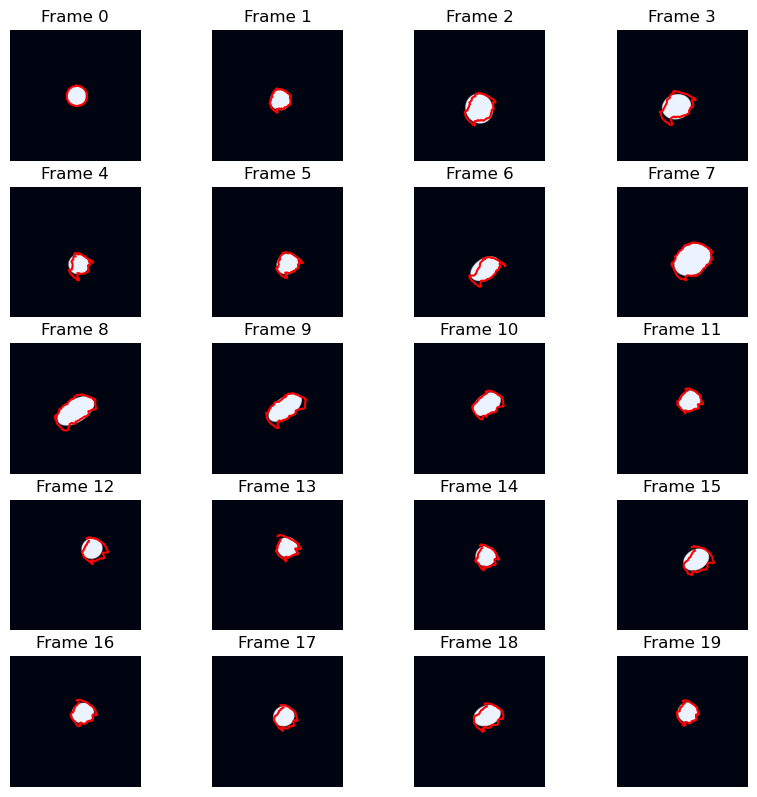

Epoch 1420, IOU: 0.791856
Epoch 1421, Loss: 14.60
Epoch 1422, Loss: 10.65
Epoch 1423, Loss: 10.30
Epoch 1424, Loss: 10.31
Epoch 1425, Loss: 10.58


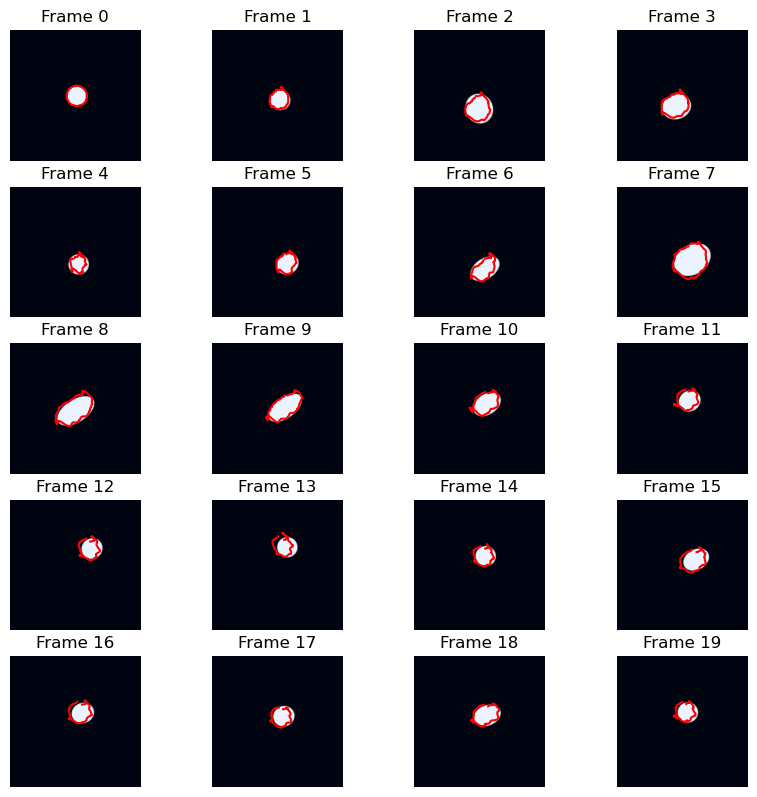

Epoch 1425, IOU: 0.757182
Epoch 1426, Loss: 12.53
Epoch 1427, Loss: 12.58
Epoch 1428, Loss: 11.36
Epoch 1429, Loss: 10.69
Epoch 1430, Loss: 11.52


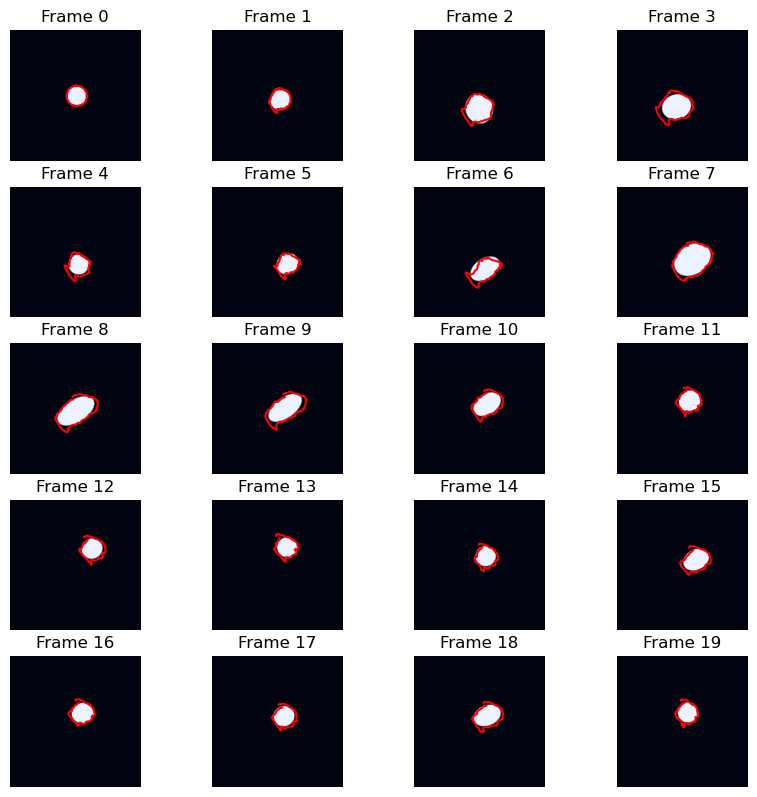

Epoch 1430, IOU: 0.791045
Epoch 1431, Loss: 14.08
Epoch 1432, Loss: 10.69
Epoch 1433, Loss: 10.50
Epoch 1434, Loss: 11.60
Epoch 1435, Loss: 11.04


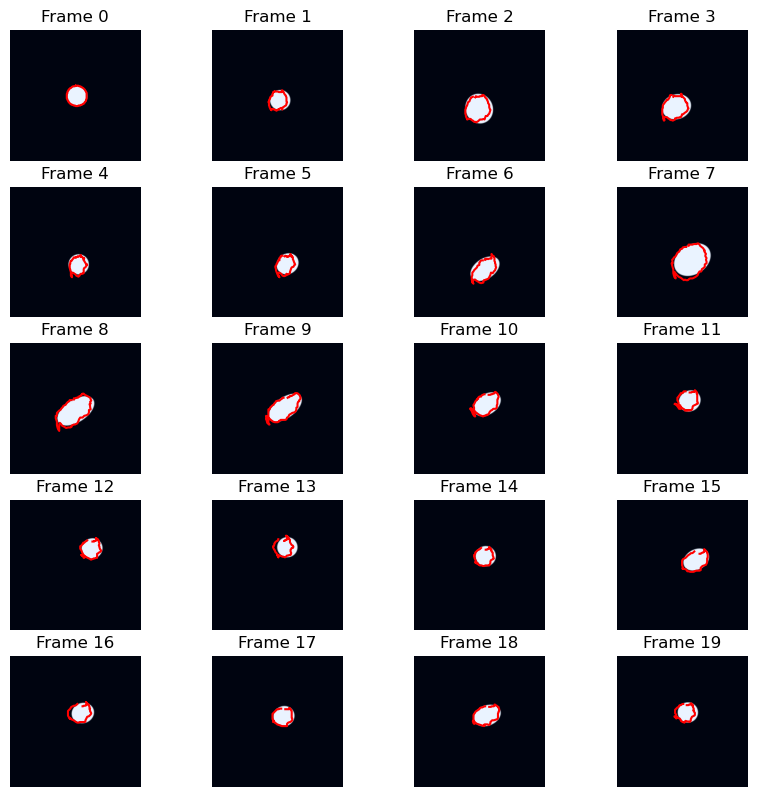

Epoch 1435, IOU: 0.766230
Epoch 1436, Loss: 13.26
Epoch 1437, Loss: 10.85
Epoch 1438, Loss: 10.35
Epoch 1439, Loss: 10.00
Epoch 1440, Loss: 10.25


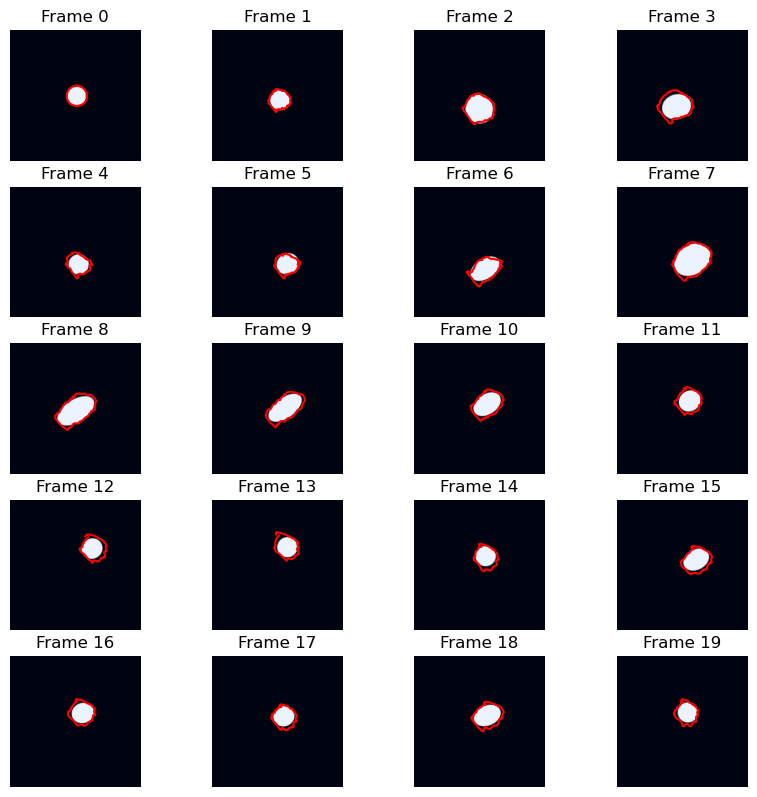

Epoch 1440, IOU: 0.782328
Epoch 1441, Loss: 12.63
Epoch 1442, Loss: 11.22
Epoch 1443, Loss: 10.69
Epoch 1444, Loss: 10.74
Epoch 1445, Loss: 11.67


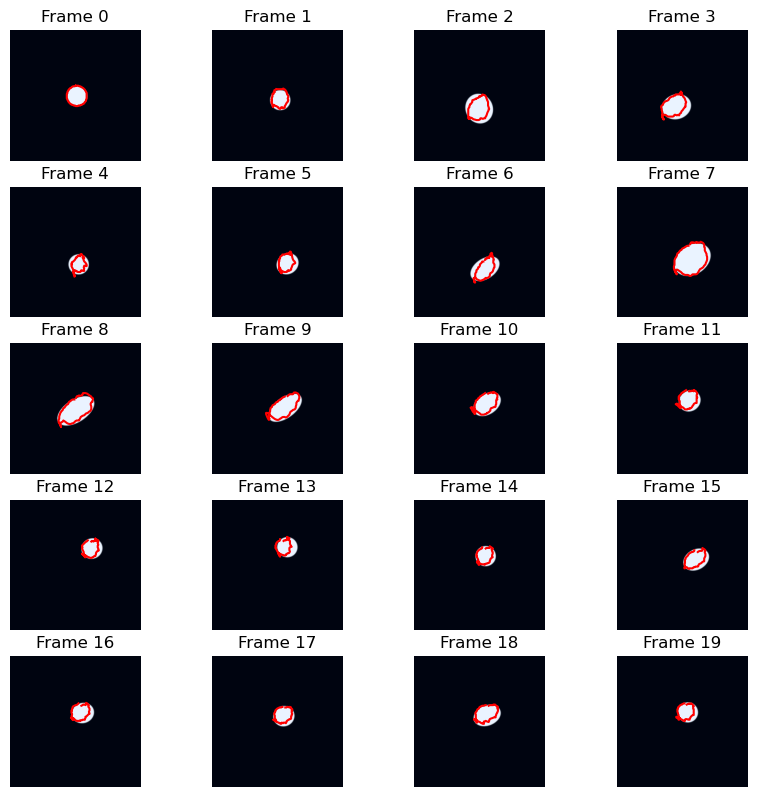

Epoch 1445, IOU: 0.694913
Epoch 1446, Loss: 15.02
Epoch 1447, Loss: 11.79
Epoch 1448, Loss: 11.02
Epoch 1449, Loss: 11.00
Epoch 1450, Loss: 11.13


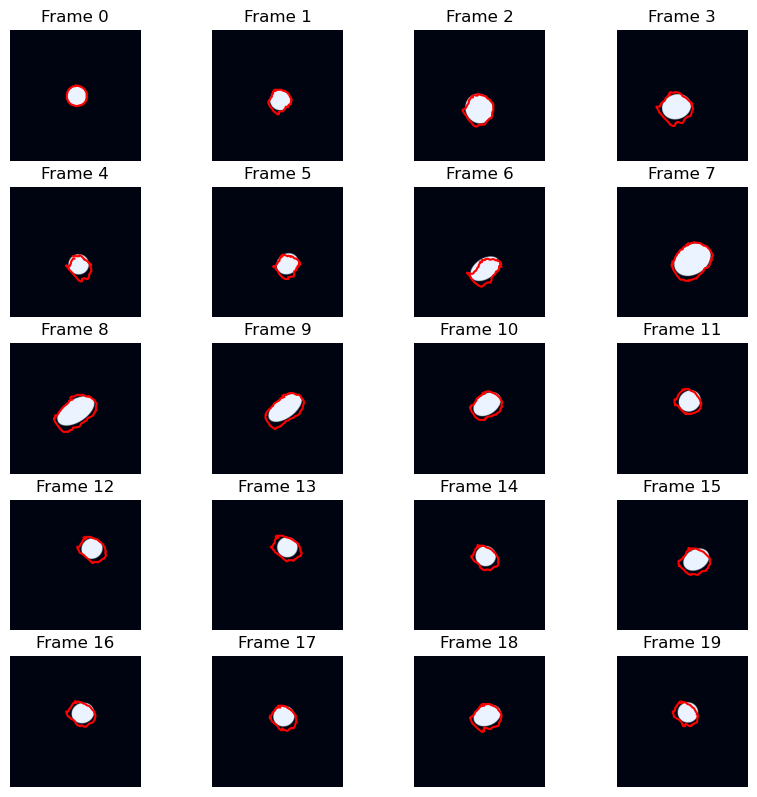

Epoch 1450, IOU: 0.733871
Epoch 1451, Loss: 15.45
Epoch 1452, Loss: 10.89
Epoch 1453, Loss: 11.20
Epoch 1454, Loss: 11.23
Epoch 1455, Loss: 10.22


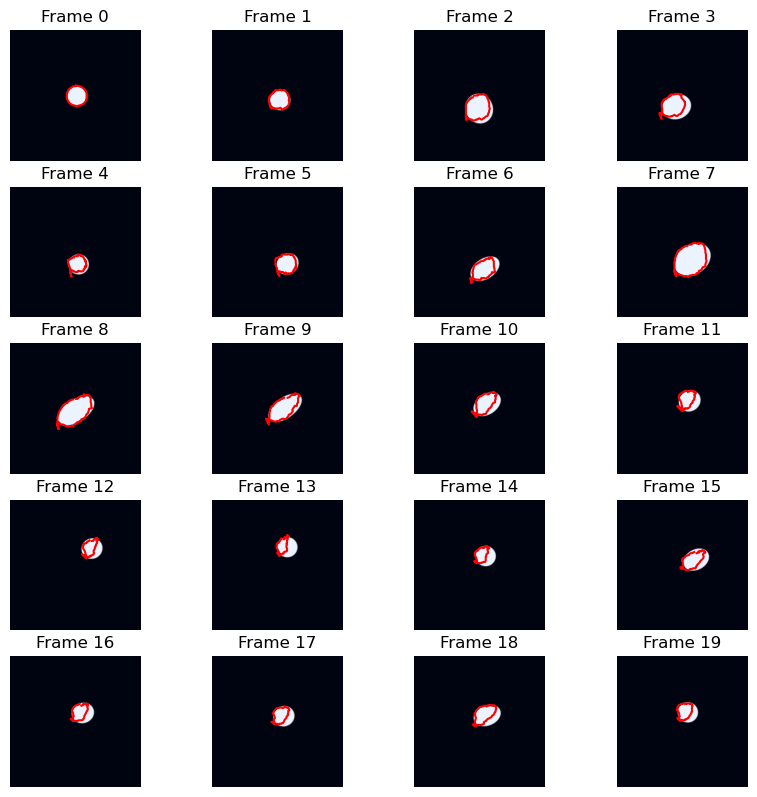

Epoch 1455, IOU: 0.683180
Epoch 1456, Loss: 15.05
Epoch 1457, Loss: 12.55
Epoch 1458, Loss: 11.55
Epoch 1459, Loss: 11.39
Epoch 1460, Loss: 9.90


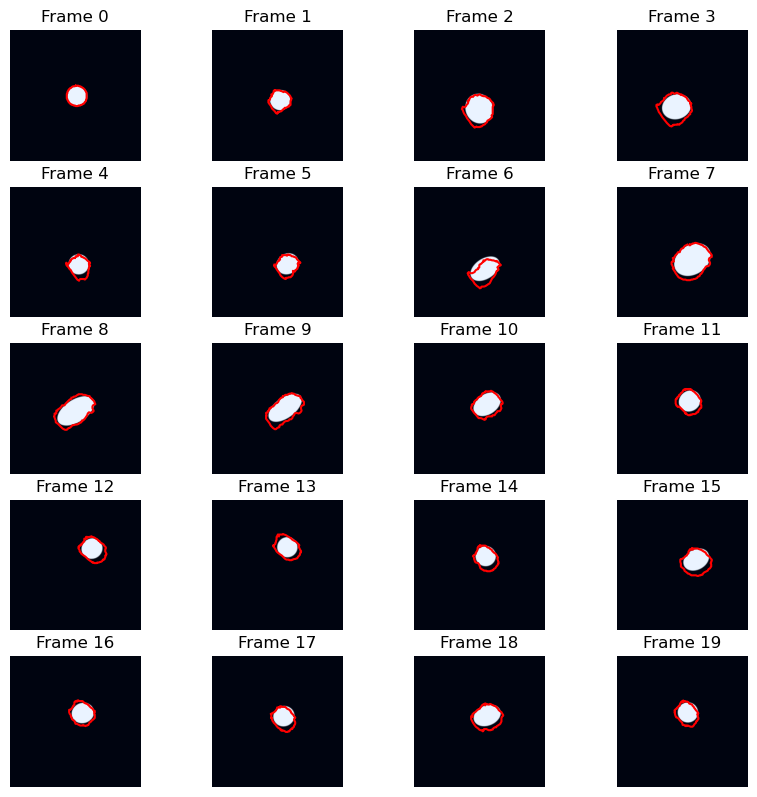

Epoch 1460, IOU: 0.749609
Epoch 1461, Loss: 12.40
Epoch 1462, Loss: 11.27
Epoch 1463, Loss: 10.33
Epoch 1464, Loss: 8.96
Epoch 1465, Loss: 10.86


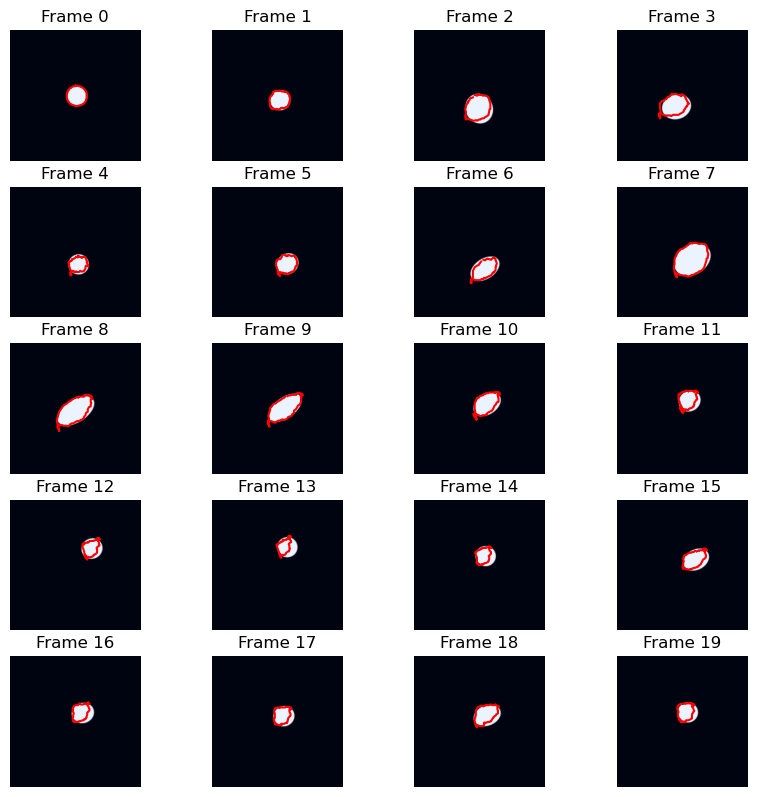

Epoch 1465, IOU: 0.751195
Epoch 1466, Loss: 13.88
Epoch 1467, Loss: 11.57
Epoch 1468, Loss: 11.78
Epoch 1469, Loss: 10.02
Epoch 1470, Loss: 9.97


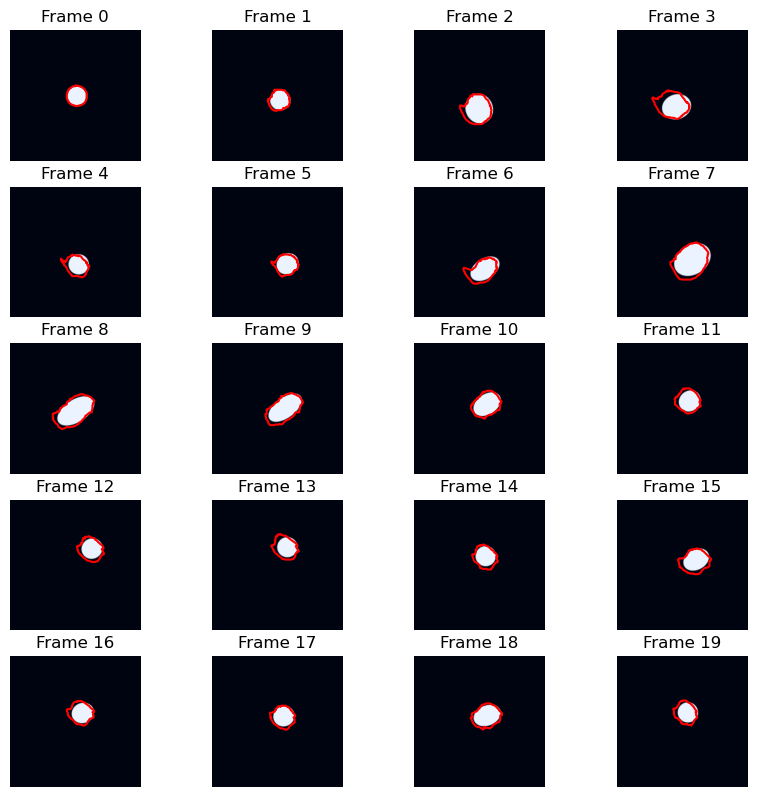

Epoch 1470, IOU: 0.774212
Epoch 1471, Loss: 12.49
Epoch 1472, Loss: 10.73
Epoch 1473, Loss: 11.36
Epoch 1474, Loss: 9.71
Epoch 1475, Loss: 9.49


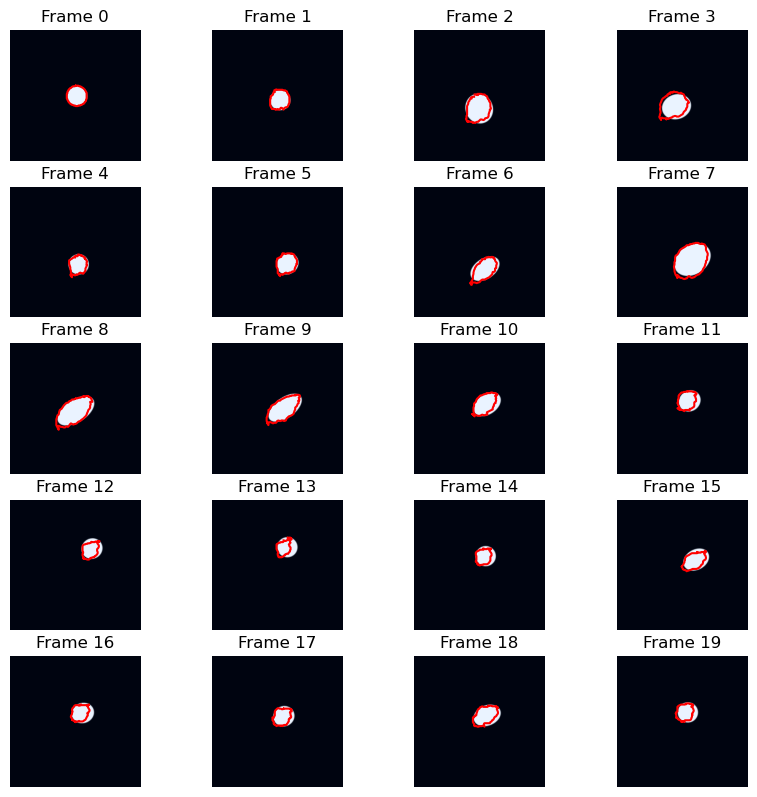

Epoch 1475, IOU: 0.760650
Epoch 1476, Loss: 12.27
Epoch 1477, Loss: 10.78
Epoch 1478, Loss: 11.96
Epoch 1479, Loss: 10.88
Epoch 1480, Loss: 10.95


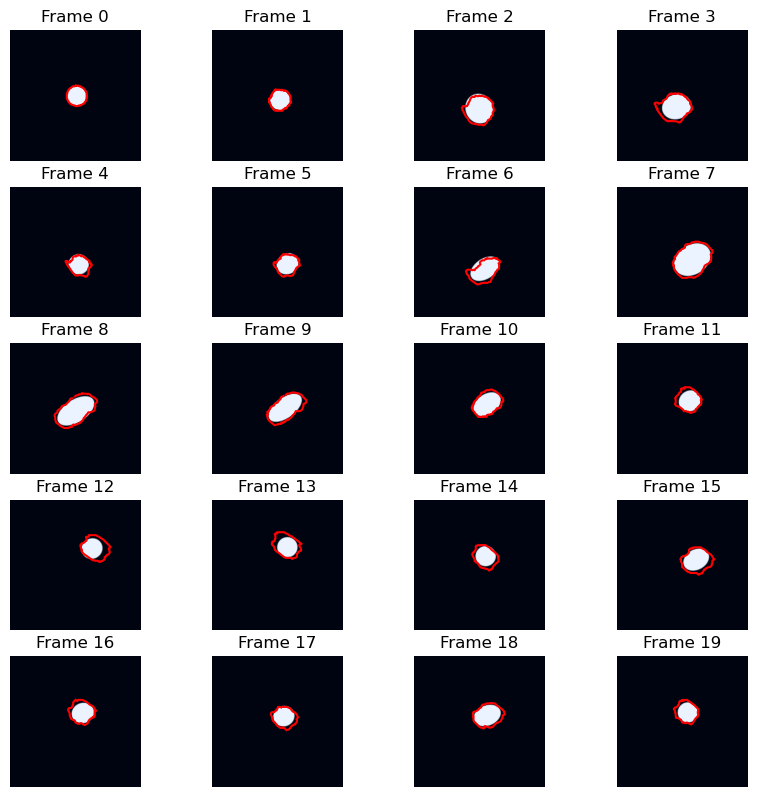

Epoch 1480, IOU: 0.774424
Epoch 1481, Loss: 11.66
Epoch 1482, Loss: 10.82
Epoch 1483, Loss: 10.02
Epoch 1484, Loss: 10.63
Epoch 1485, Loss: 10.11


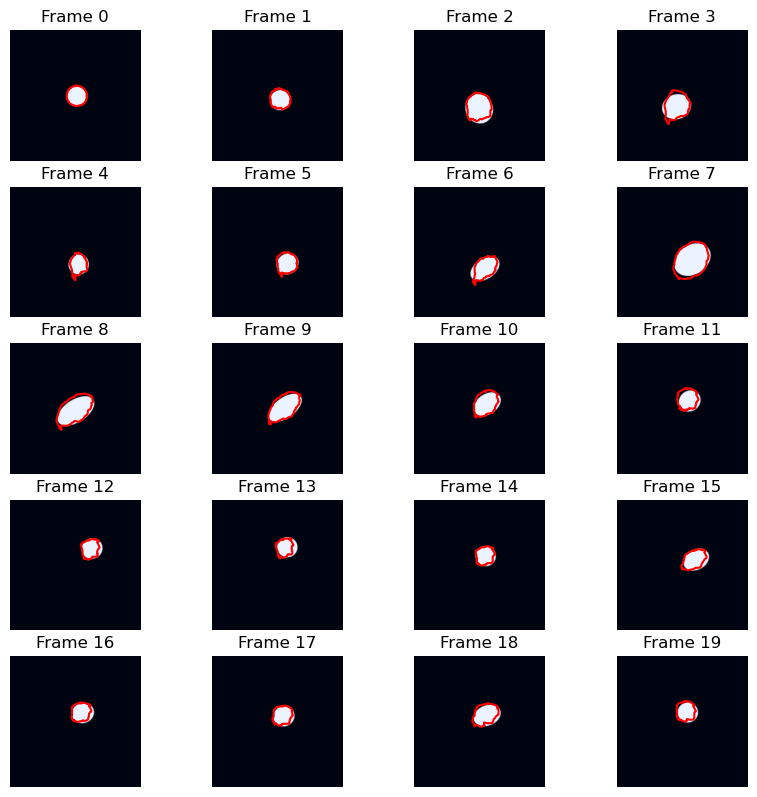

Epoch 1485, IOU: 0.799268
Epoch 1486, Loss: 13.15
Epoch 1487, Loss: 10.25
Epoch 1488, Loss: 9.66
Epoch 1489, Loss: 10.97
Epoch 1490, Loss: 11.20


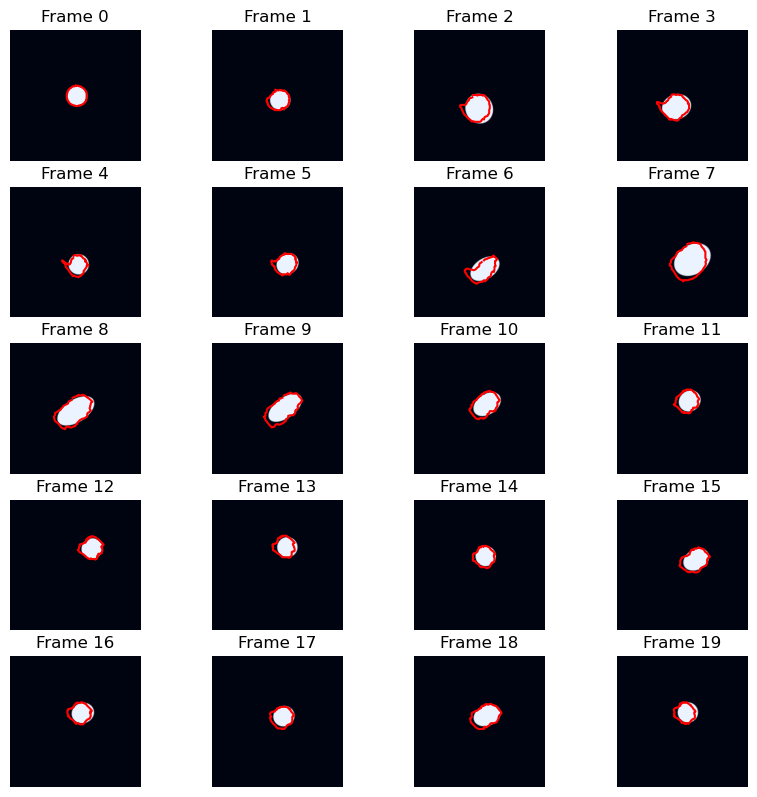

Epoch 1490, IOU: 0.786782
Epoch 1491, Loss: 11.72
Epoch 1492, Loss: 9.45
Epoch 1493, Loss: 9.95
Epoch 1494, Loss: 11.11
Epoch 1495, Loss: 9.46


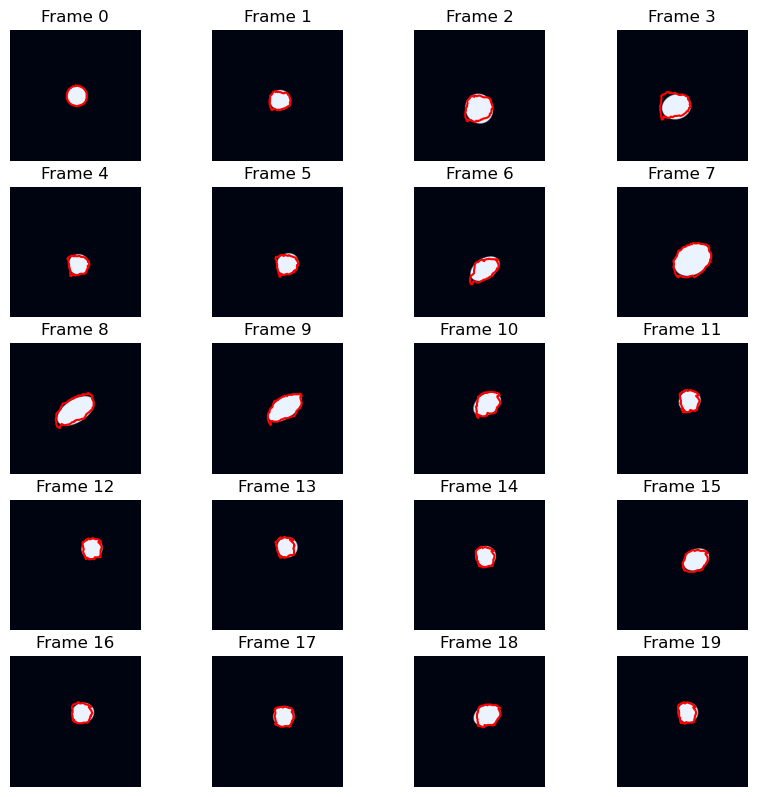

Epoch 1495, IOU: 0.849649
Epoch 1496, Loss: 11.05
Epoch 1497, Loss: 9.23
Epoch 1498, Loss: 9.76
Epoch 1499, Loss: 9.35
Epoch 1500, Loss: 10.24


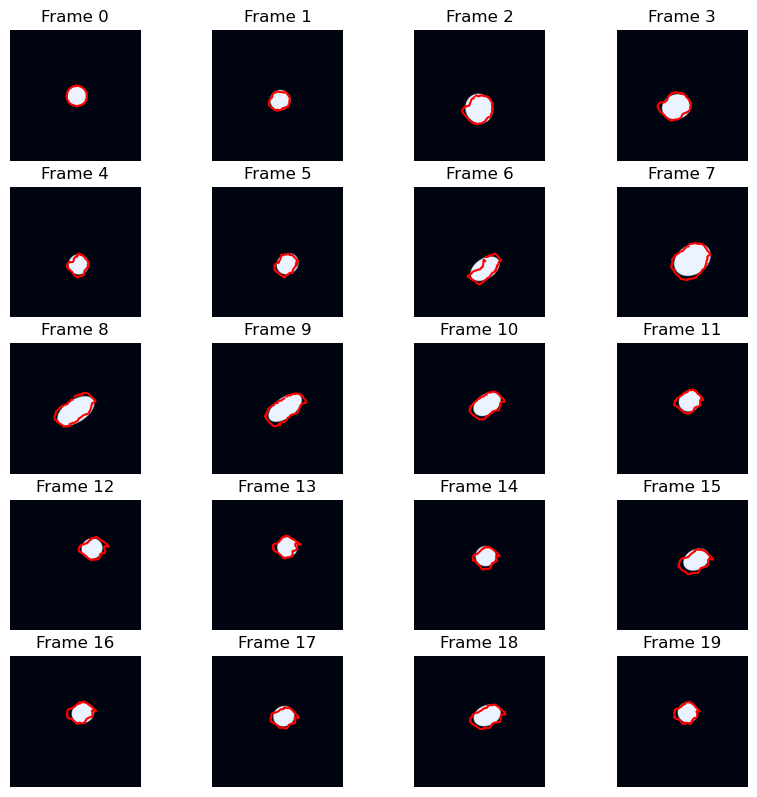

Epoch 1500, IOU: 0.794209
Epoch 1501, Loss: 13.19
Epoch 1502, Loss: 10.89
Epoch 1503, Loss: 9.75
Epoch 1504, Loss: 10.42
Epoch 1505, Loss: 9.73


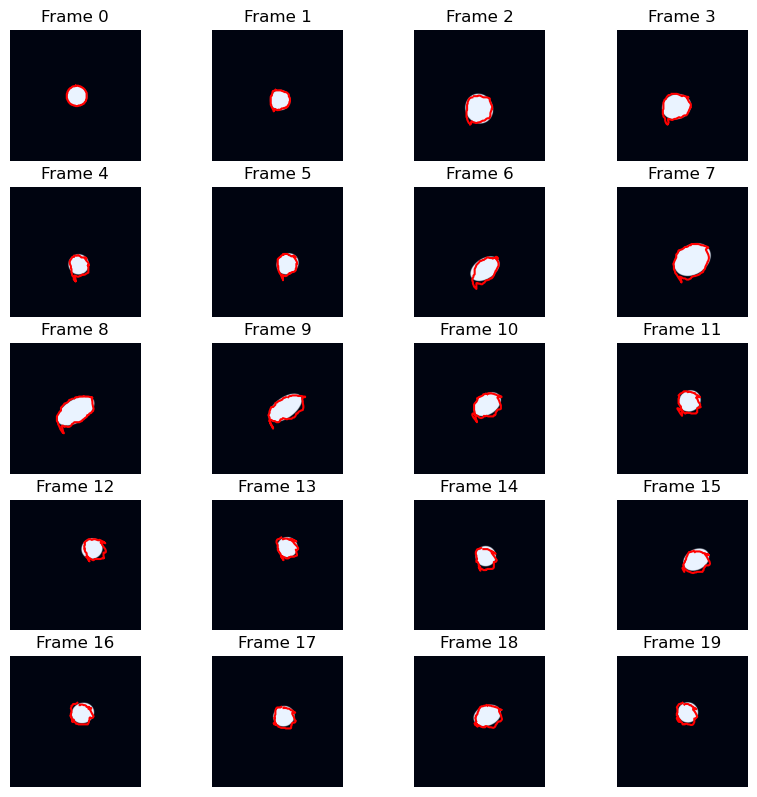

Epoch 1505, IOU: 0.815012
Epoch 1506, Loss: 13.26
Epoch 1507, Loss: 11.76
Epoch 1508, Loss: 10.89
Epoch 1509, Loss: 10.00


KeyboardInterrupt: 

In [26]:
for interval in range(interval_num):
    for e in range(interval_epochs):
        model.train()
        mean_loss = 0
        for first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx in data_loader:
            pre_idx = pre_idx.item()
            curr_idx = curr_idx.item()
            pre_boundary = model_infer.get_boundary(pre_idx)
            pre_boundary = pre_boundary.unsqueeze(0).to("cuda")
            first_boundary = first_boundary.to("cuda")
            first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary = (
                first_frame.to("cuda"),
                first_boundary.to("cuda"),
                pre_frame.to("cuda"),
                curr_frame.to("cuda"),
                pre_boundary.to("cuda"),
                curr_boundary.to("cuda"),
            )
            optimizer.zero_grad()
            results = model(first_frame, first_boundary, pre_frame, curr_frame, pre_boundary)
            refine_num = len(results)
            loss = 0
            for i in range(refine_num):
                loss += 0.8 ** (refine_num - i - 1) * loss_func(results[i], curr_boundary)
            mean_loss += loss.item()
            # nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            loss.backward()
            optimizer.step()
        mean_loss /= len(data_loader)
        epoch_index += 1
        print(f"Epoch {epoch_index}, Loss: {mean_loss:.2f}")
        dict_loss[epoch_index] = mean_loss
    model_infer.infer_model(model)
    iou = model_infer.show_infer_result(0)
    dict_iou[epoch_index] = iou
    print(f"Epoch {epoch_index}, IOU: {iou:5f}")
    if interval_epochs > 100:
        interval_epochs = 50
    elif interval_epochs > 5:
        interval_epochs -= 5

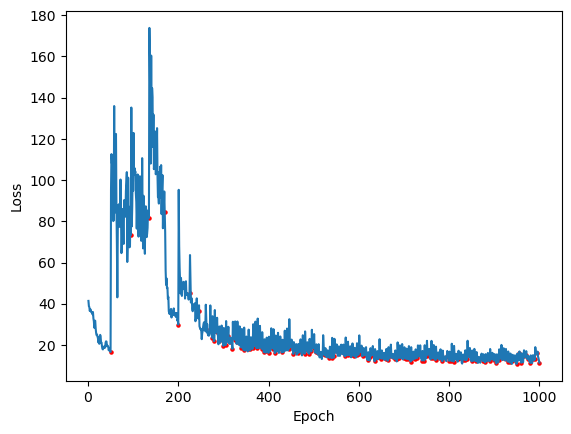

In [21]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()))
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plot the update points
plt.scatter(list(dict_iou.keys()), [dict_loss[i] for i in list(dict_iou.keys())], c="r", s=5)
plt.show()

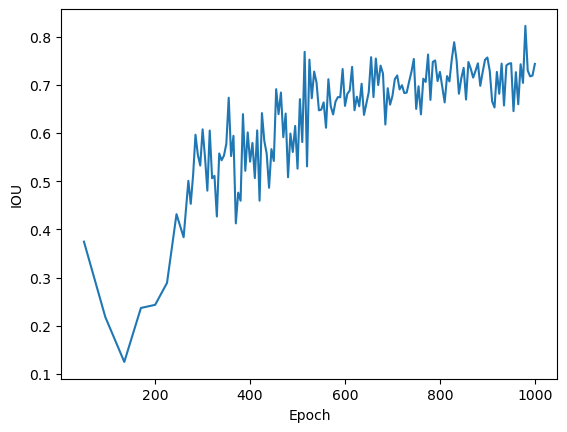

In [22]:
# plot the iou
plt.plot(list(dict_iou.keys()), list(dict_iou.values()))
plt.xlabel("Epoch")
plt.ylabel("IOU")
plt.show()

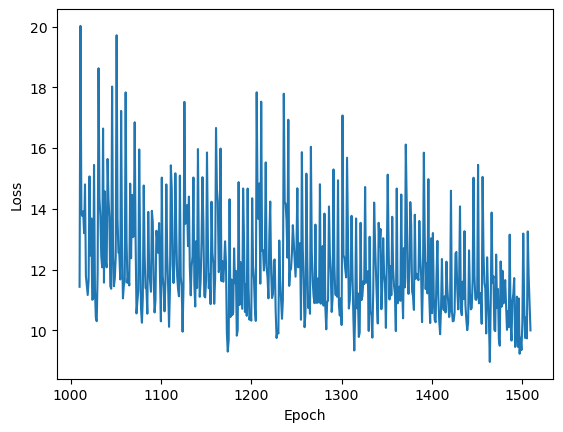

In [29]:
# plot last 500 epochs loss
plt.plot(list(dict_loss.keys())[-500:], list(dict_loss.values())[-500:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plot the update points
# plt.scatter(
#     list(dict_iou.keys())[-500:], [dict_loss[i] for i in list(dict_iou.keys())[-500:]], c="r", s=5
# )
plt.show()

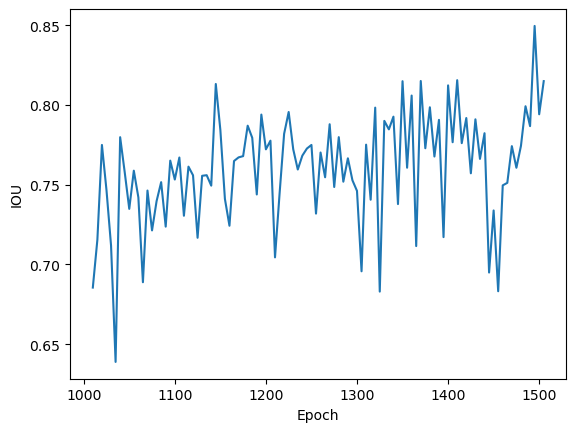

In [32]:
# plot last 500 epochs iou
last_index = -100
plt.plot(list(dict_iou.keys())[last_index:], list(dict_iou.values())[last_index:])
plt.xlabel("Epoch")
plt.ylabel("IOU")
plt.show()
